***
# Starting Kit - Black Swan HiggsML Course
***

In [1]:
COLAB = "google.colab" in str(get_ipython())

In [2]:
if COLAB:
    ! git clone --depth 1 https://github.com/blackSwanCS/Higgs_collaborations.git

    ! git status
    %cd Higgs_collaborations

In [3]:
# HiggsML utility package should not be modified
%pip install HiggsML

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simpleNote: you may need to restart the kernel to use updated packages.

  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/f2/94/3af39d34be01a24a6e65433d19e107099374224905f1e0cc6bbe1fd22a2f/argparse-1.4.0-py2.py3-none-any.whl (23 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [4]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys

warnings.filterwarnings("ignore")

### Directories

In [5]:
root_dir = os.getcwd()
print("Root directory is", root_dir)
submission_dir = os.path.join(root_dir, "sample_code_submission")

# The directory where results and other outputs from the participant's code will be written
output_dir = os.path.join(root_dir, "sample_result_submission")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Root directory is c:\Users\lenovo\Higgs_collaborations_Juefan


## Import Submission Model
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements a basic model with 2 different model trained to predict the class label. 

* 1 XGBoost BDT ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/boosted_decision_tree.py) )
* 2 Tebsorflow NN  ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/neural_network.py) )

The feature engineering is in where you can include derived quantities and decide which feature should be needed. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/feature_engineering.py) ) 

the statistical analysis part is where yoiu write the mu finding calculation using the output of the classifier. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/statistical_analysis.py) ) 

If running in Collab, click the folder icon in the left sidebar to open the file browser.


In [6]:
path.append(submission_dir)
from model import Model

## Data
### Available data sets
1. blackSwan_data
2. sample_data
3. neurips2024_data 

In [7]:
from HiggsML.datasets import download_dataset

data = download_dataset(
    "blackSwan_data"
)  # change to "blackSwan_data" for the actual data

2025-06-06 10:26:22,518 - HiggsML.datasets     - INFO     - Handling as dataset name: blackSwan_data
2025-06-06 10:26:22,527 - HiggsML.datasets     - INFO     - Current working directory: c:\Users\lenovo\Higgs_collaborations_Juefan
2025-06-06 10:26:22,546 - HiggsML.datasets     - INFO     - Total rows: 2000000
2025-06-06 10:26:22,546 - HiggsML.datasets     - INFO     - Test size: 600000


### ⚠️ Note:
The data used here is a small subset of the full data is for demonstration only to get a view of what the data looks like. 

In [8]:
# load train set
data.load_train_set()
data_set = data.get_train_set()

2025-06-06 10:26:25,364 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-06-06 10:26:26,807 - HiggsML.datasets     - INFO     - Data loaded successfully


***
## Visualize the Data Set
***

In [9]:
from tabulate import tabulate

target = data_set["labels"]
weights = data_set["weights"]
detailed_label = data_set["detailed_labels"]
keys = np.unique(detailed_label)


weight_keys = {}
average_weights = {}
for key in keys:
    weight_keys[key] = weights[detailed_label == key]

table_data = []
for key in keys:
    table_data.append(
        [
            key,
            np.sum(weight_keys[key]),
            len(weight_keys[key]),
            np.mean(weight_keys[key]),
        ]
    )

table_data.append(
    [
        "Total Signal",
        np.sum(weights[target == 1]),
        len(weights[target == 1]),
        np.mean(weights[target == 1]),
    ]
)
table_data.append(
    [
        "Total Background",
        np.sum(weights[target == 0]),
        len(weights[target == 0]),
        np.mean(weights[target == 0]),
    ]
)


print("[*] --- Detailed Label Summary")
print(
    tabulate(
        table_data,
        headers=[
            "Detailed Label",
            "Total Weight",
            "Number of events",
            "Average Weight",
        ],
        tablefmt="grid",
    )
)

[*] --- Detailed Label Summary
+------------------+----------------+--------------------+------------------+
| Detailed Label   |   Total Weight |   Number of events |   Average Weight |
+==================+================+====================+==================+
| diboson          |        382.109 |               3406 |       0.112187   |
+------------------+----------------+--------------------+------------------+
| htautau          |        675.897 |             462981 |       0.00145988 |
+------------------+----------------+--------------------+------------------+
| ttbar            |       4404.72  |              39293 |       0.112099   |
+------------------+----------------+--------------------+------------------+
| ztautau          |     100256     |             894320 |       0.112103   |
+------------------+----------------+--------------------+------------------+
| Total Signal     |        675.897 |             462981 |       0.00145988 |
+------------------+-------------

In [10]:
print("\n[*] --- Examples of all features\n")
display(data_set.head())


[*] --- Examples of all features



PRI_lep_pt  PRI_lep_eta  PRI_lep_phi  PRI_had_pt  PRI_had_eta  PRI_had_phi  \
0   37.472000        0.676       -1.520   46.752998        0.623        1.500   
1   26.006001       -0.087       -1.412   60.009998       -0.290       -0.099   
2   20.622999       -0.922       -0.436   41.917999       -1.356        2.524   
3   48.394001        0.202        0.816   27.916000       -0.552       -2.387   
4   39.840000       -0.005        1.487   30.997000        1.747        2.681   

   PRI_jet_leading_pt  PRI_jet_leading_eta  PRI_jet_leading_phi  \
0          -25.000000              -25.000              -25.000   
1          134.770996                0.350                2.894   
2          -25.000000              -25.000              -25.000   
3          -25.000000              -25.000              -25.000   
4           73.082001                3.369               -1.286   

   PRI_jet_subleading_pt  ...    DER_pt_h  DER_deltaeta_jet_jet  \
0                -25.000  ...   30.256184               -25.000   
1                 49.673  ...  124.359779                 2.009   
2                -25.000  ...   10.601603               -25.000   
3                -25.000  ...   10.455322               -25.000   
4                 31.274  ...   92.074677                 3.370   

   DER_mass_jet_jet  DER_prodeta_jet_jet  DER_deltar_had_lep  DER_pt_tot  \
0        -25.000000           -25.000000            3.020465   30.256184   
1        232.705902            -0.580650            1.328600    9.316307   
2        -25.000000           -25.000000            2.991648   10.601603   
3        -25.000000           -25.000000            3.171129   10.455322   
4        254.889191            -0.003369            2.120175    6.207835   

   DER_sum_pt DER_pt_ratio_lep_had  DER_met_phi_centrality  \
0   84.224998             0.801489                1.365776   
1  270.459991             0.433361                1.413247   
2   62.541000             0.491984                1.315526   
3   76.309998             1.733558               -1.409702   
4  175.192993             1.285286                1.037429   

   DER_lep_eta_centrality  
0              -25.000000  
1                0.726747  
2              -25.000000  
3              -25.000000  
4                0.366135  

[5 rows x 31 columns]

In [11]:
print("\n[*] --- Description of all features\n")
display(data_set.describe())


[*] --- Description of all features



PRI_lep_pt   PRI_lep_eta   PRI_lep_phi    PRI_had_pt   PRI_had_eta  \
count  1.400000e+06  1.400000e+06  1.400000e+06  1.400000e+06  1.400000e+06   
mean   3.396482e+01 -1.664071e-03  3.532688e-04  4.310186e+01 -1.059442e-03   
std    1.806436e+01  1.223419e+00  1.813047e+00  2.134356e+01  1.246117e+00   
min    2.000000e+01 -2.500000e+00 -3.142000e+00  2.287700e+01 -2.690000e+00   
25%    2.395100e+01 -9.520000e-01 -1.568000e+00  3.077000e+01 -9.770000e-01   
50%    2.901600e+01 -1.000000e-03  1.000000e-03  3.816800e+01 -1.000000e-03   
75%    3.716600e+01  9.500000e-01  1.572000e+00  4.813200e+01  9.730000e-01   
max    1.101770e+03  2.500000e+00  3.142000e+00  8.452980e+02  2.680000e+00   

        PRI_had_phi  PRI_jet_leading_pt  PRI_jet_leading_eta  \
count  1.400000e+06        1.400000e+06         1.400000e+06   
mean  -7.431224e-04        2.039557e+01        -1.315356e+01   
std    1.813856e+00        6.307355e+01         1.255423e+01   
min   -3.142000e+00       -2.500000e+01        -2.500000e+01   
25%   -1.572000e+00       -2.500000e+01        -2.500000e+01   
50%    3.000000e-03       -2.500000e+01        -2.500000e+01   
75%    1.570000e+00        4.706200e+01        -1.560000e-01   
max    3.142000e+00        1.203860e+03         4.991000e+00   

       PRI_jet_leading_phi  PRI_jet_subleading_pt  ...      DER_pt_h  \
count         1.400000e+06           1.400000e+06  ...  1.400000e+06   
mean         -1.315217e+01          -8.396195e+00  ...  4.182135e+01   
std           1.254495e+01           3.432262e+01  ...  5.431841e+01   
min          -2.500000e+01          -2.500000e+01  ...  1.173875e-02   
25%          -2.500000e+01          -2.500000e+01  ...  1.094507e+01   
50%          -2.500000e+01          -2.500000e+01  ...  2.156595e+01   
75%          -1.780000e-01          -2.500000e+01  ...  4.885020e+01   
max           3.142000e+00           1.001000e+03  ...  1.175087e+03   

       DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
count          1.400000e+06      1.400000e+06         1.400000e+06   
mean          -1.887505e+01      5.100177e+01        -1.941999e+01   
std            1.143358e+01      2.382271e+02         1.057919e+01   
min           -2.500000e+01     -2.500000e+01        -2.500000e+01   
25%           -2.500000e+01     -2.500000e+01        -2.500000e+01   
50%           -2.500000e+01     -2.500000e+01        -2.500000e+01   
75%           -2.500000e+01     -2.500000e+01        -2.500000e+01   
max            9.666000e+00      6.555388e+03         2.229731e+01   

       DER_deltar_had_lep    DER_pt_tot    DER_sum_pt  DER_pt_ratio_lep_had  \
count        1.400000e+06  1.400000e+06  1.400000e+06          1.400000e+06   
mean         2.738726e+00  1.806350e+01  1.273698e+02          8.796806e-01   
std          6.103445e-01  1.601432e+01  1.094018e+02          5.094582e-01   
min          5.641427e-01  1.173875e-02  4.304400e+01          3.400616e-02   
25%          2.509546e+00  8.491425e+00  6.449300e+01          5.891082e-01   
50%          2.957897e+00  1.439308e+01  8.531300e+01          7.759828e-01   
75%          3.127119e+00  2.271586e+01  1.433570e+02          1.024202e+00   
max          5.804204e+00  7.199706e+02  2.497039e+03          2.160489e+01   

       DER_met_phi_centrality  DER_lep_eta_centrality  
count            1.400000e+06            1.400000e+06  
mean             2.691063e-01           -1.930729e+01  
std              1.217131e+00            1.060158e+01  
min             -1.414214e+00           -2.500000e+01  
25%             -1.332358e+00           -2.500000e+01  
50%              9.866624e-01           -2.500000e+01  
75%              1.385667e+00           -2.500000e+01  
max              1.414214e+00            1.000000e+00  

[8 rows x 30 columns]

[*] --- PRI_lep_pt histogram
[*] --- PRI_lep_eta histogram
[*] --- PRI_lep_phi histogram
[*] --- PRI_had_pt histogram


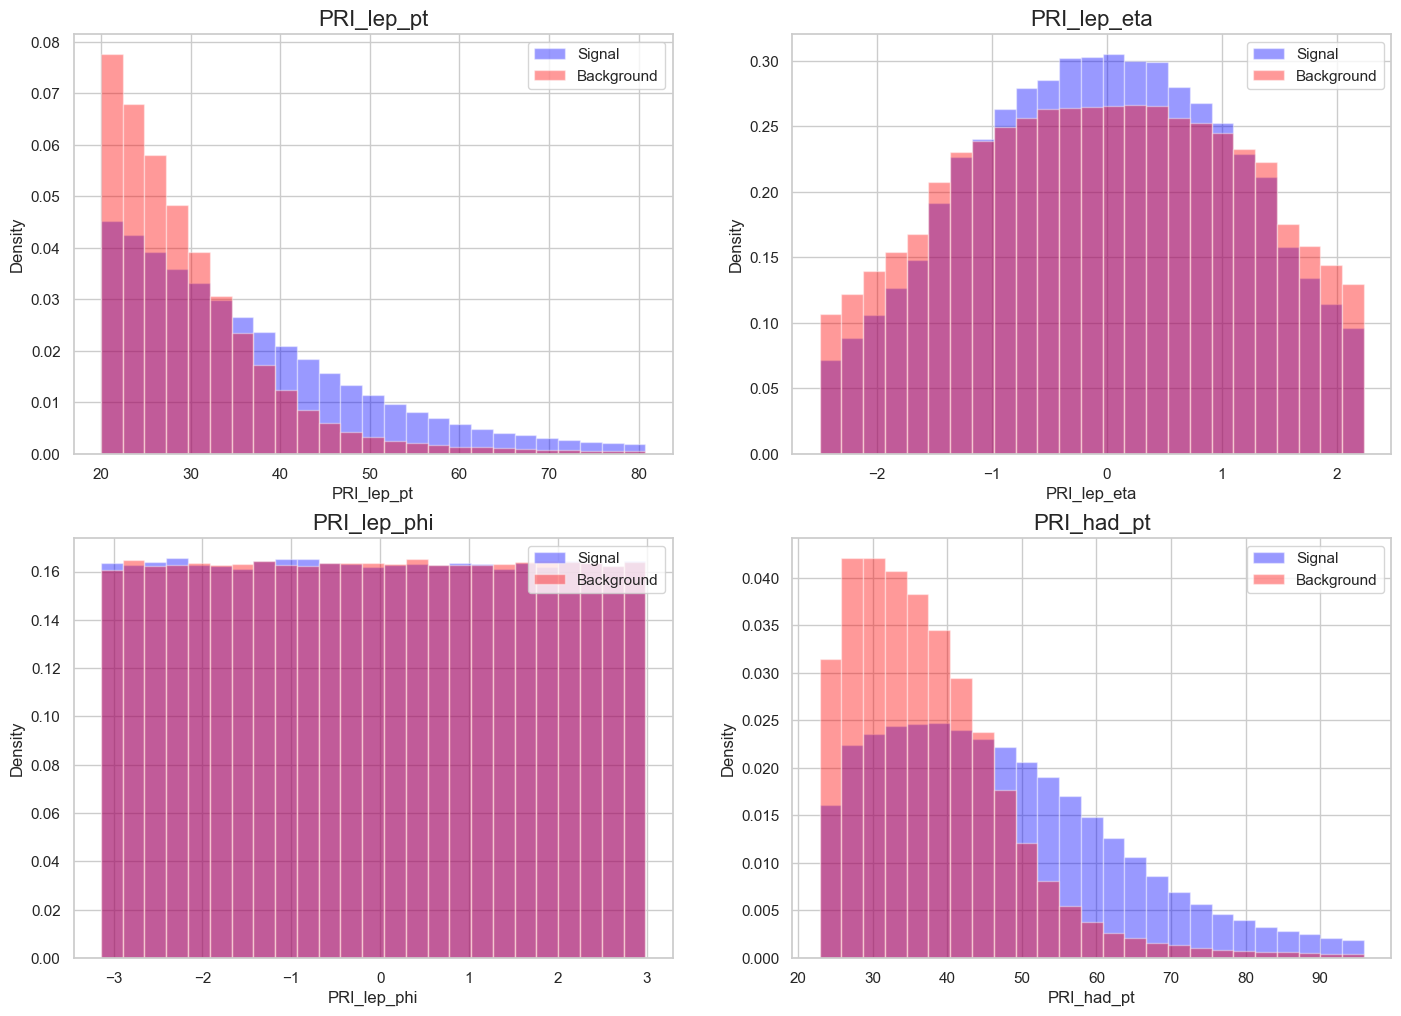

[*] --- PRI_had_eta histogram
[*] --- PRI_had_phi histogram
[*] --- PRI_jet_leading_pt histogram
[*] --- PRI_jet_leading_eta histogram


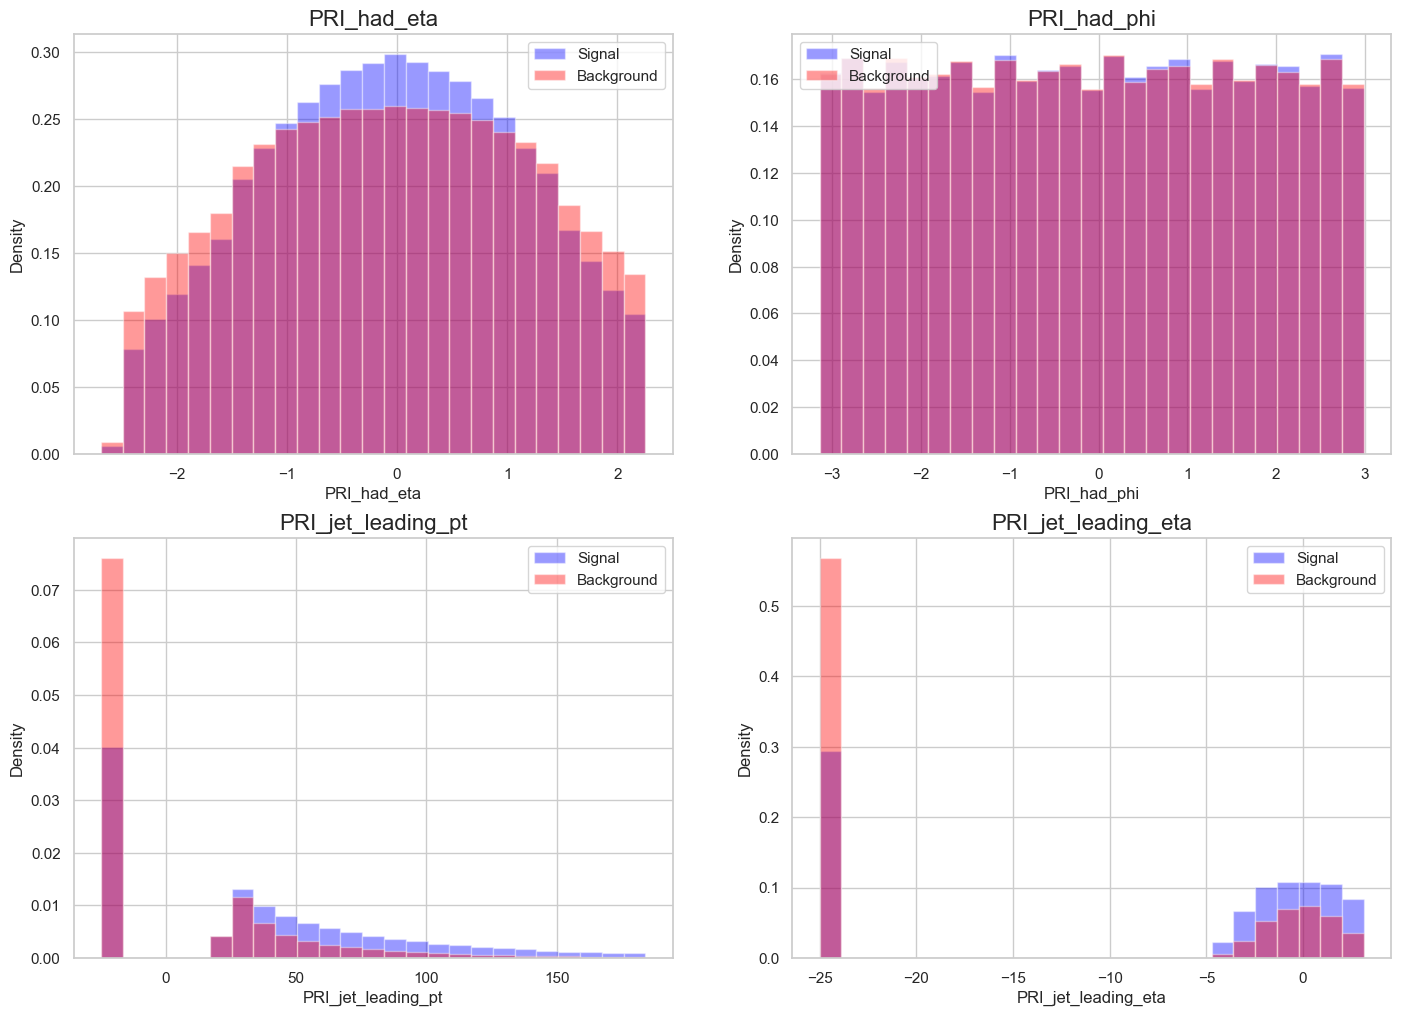

[*] --- PRI_jet_leading_phi histogram
[*] --- PRI_jet_subleading_pt histogram
[*] --- PRI_jet_subleading_eta histogram
[*] --- PRI_jet_subleading_phi histogram


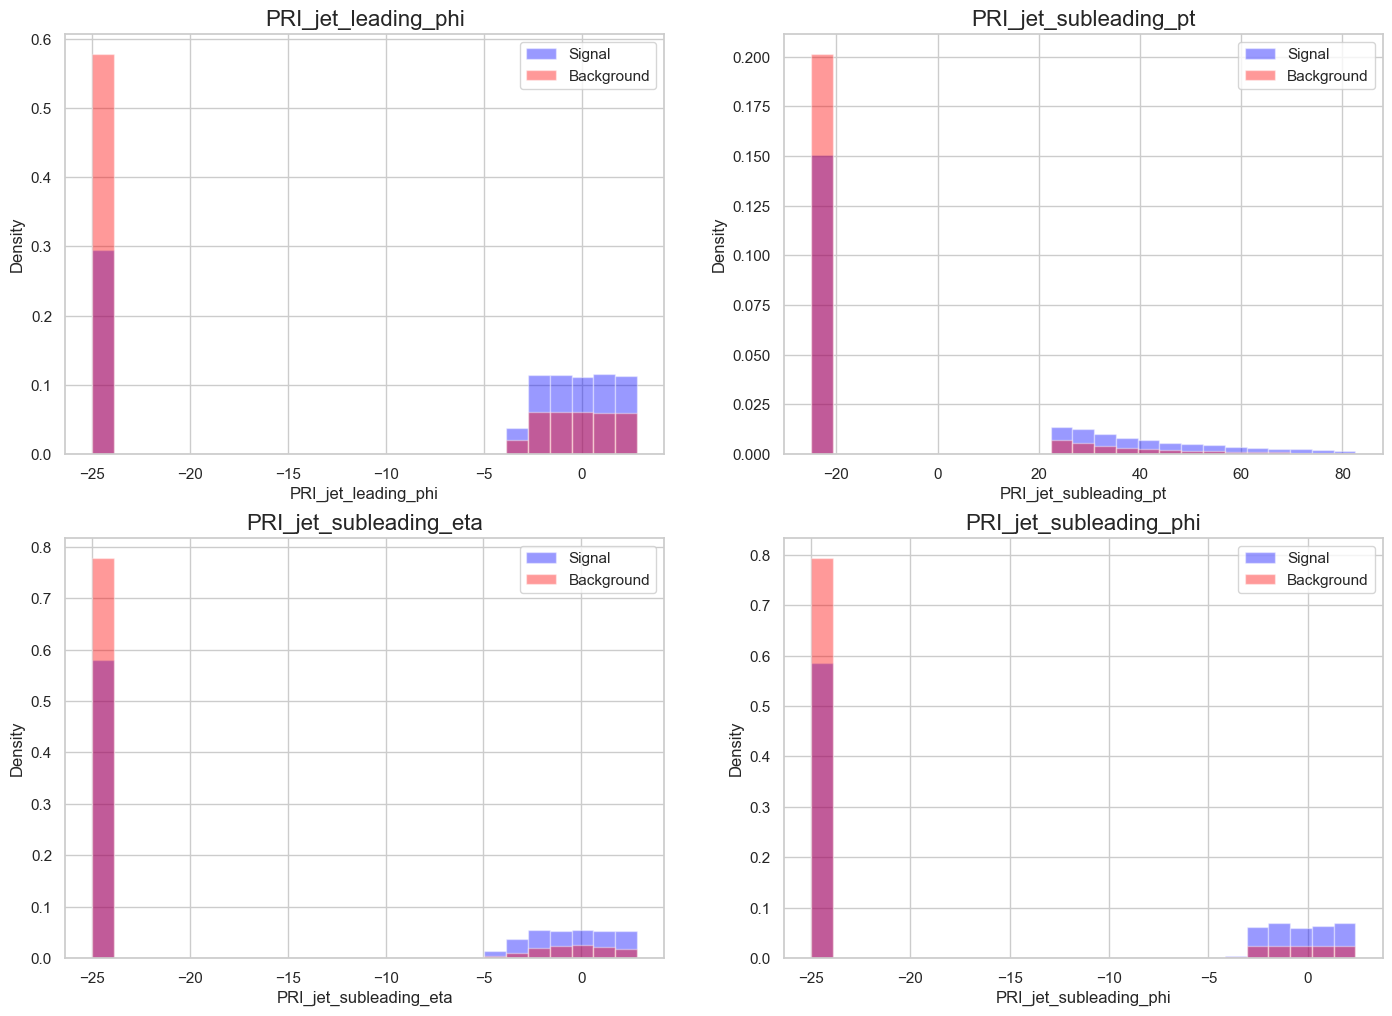

[*] --- PRI_n_jets histogram
[*] --- PRI_jet_all_pt histogram
[*] --- PRI_met histogram
[*] --- PRI_met_phi histogram


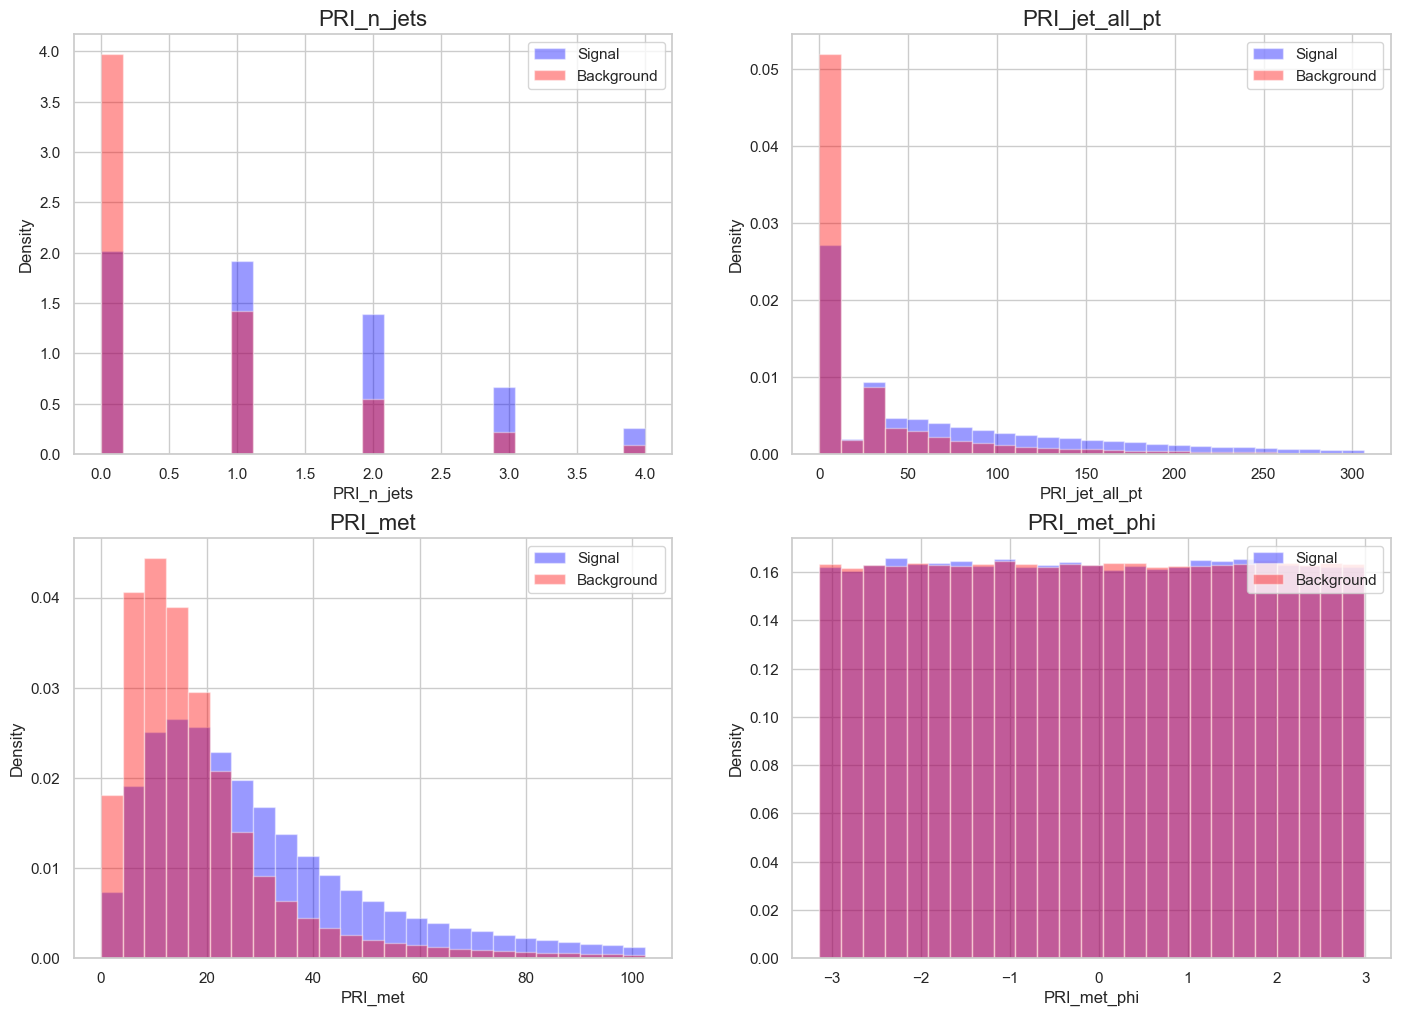

[*] --- DER_mass_transverse_met_lep histogram
[*] --- DER_mass_vis histogram
[*] --- DER_pt_h histogram
[*] --- DER_deltaeta_jet_jet histogram


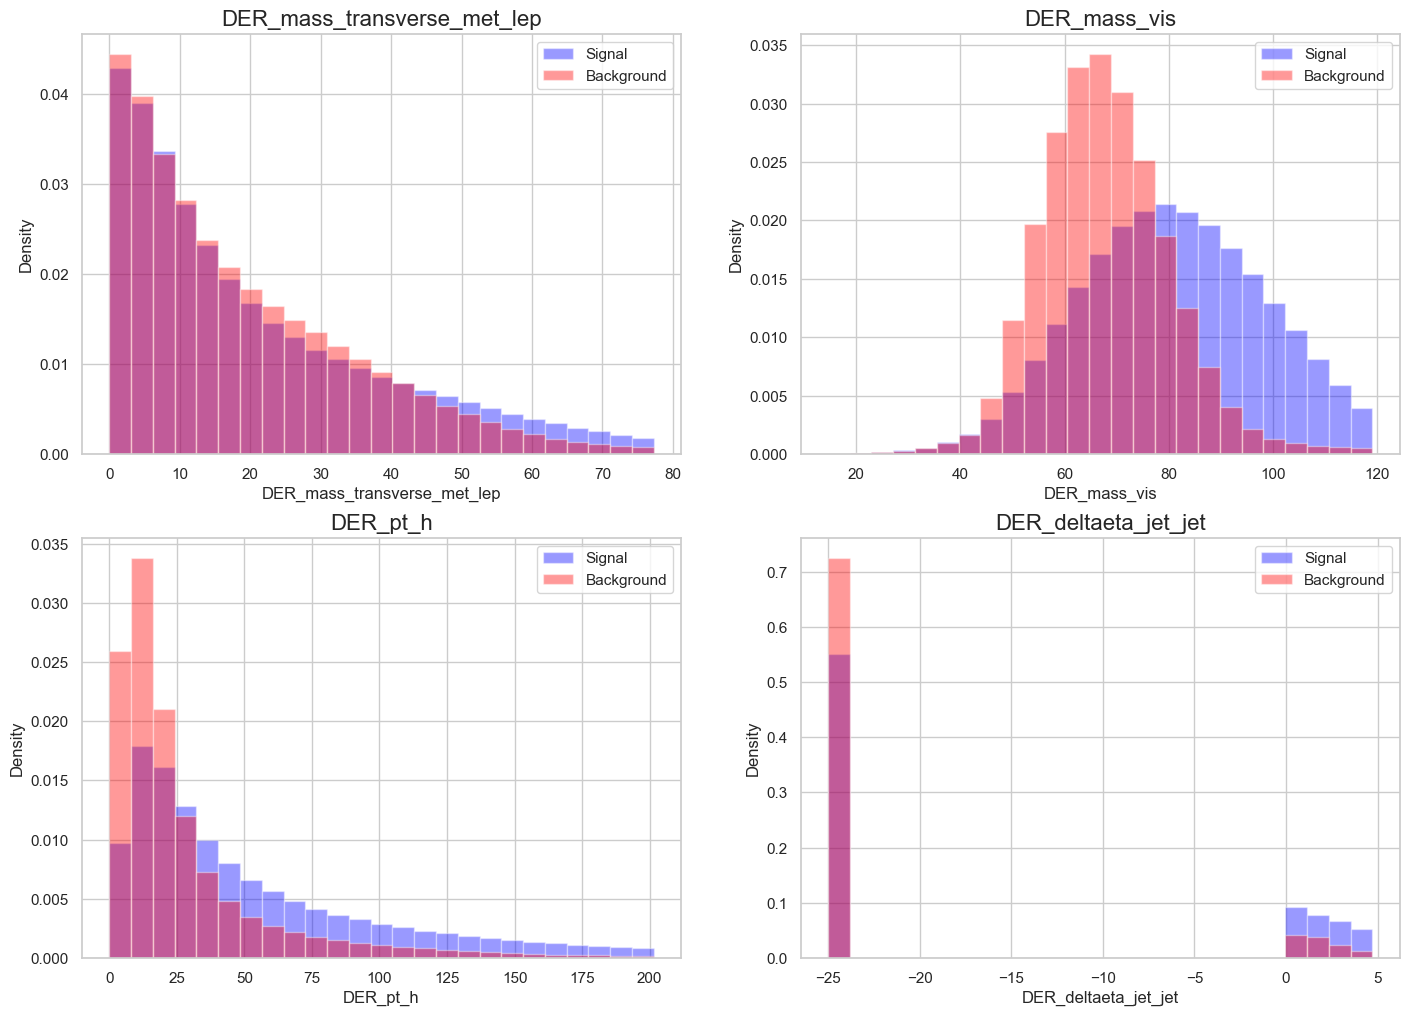

[*] --- DER_mass_jet_jet histogram
[*] --- DER_prodeta_jet_jet histogram
[*] --- DER_deltar_had_lep histogram
[*] --- DER_pt_tot histogram


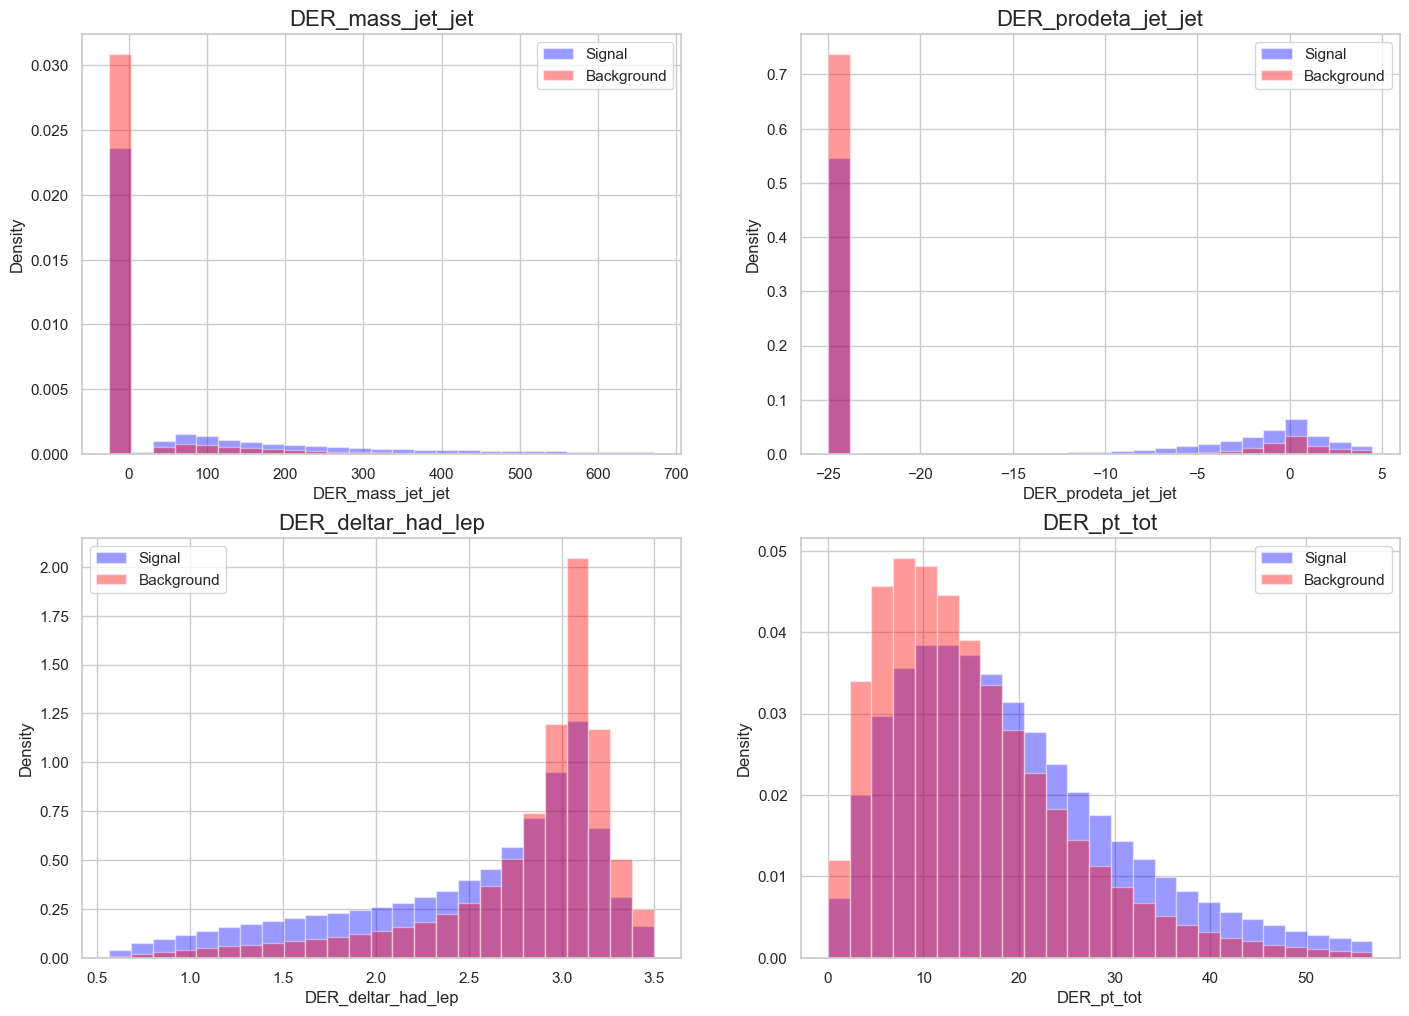

[*] --- DER_sum_pt histogram
[*] --- DER_pt_ratio_lep_had histogram
[*] --- DER_met_phi_centrality histogram
[*] --- DER_lep_eta_centrality histogram


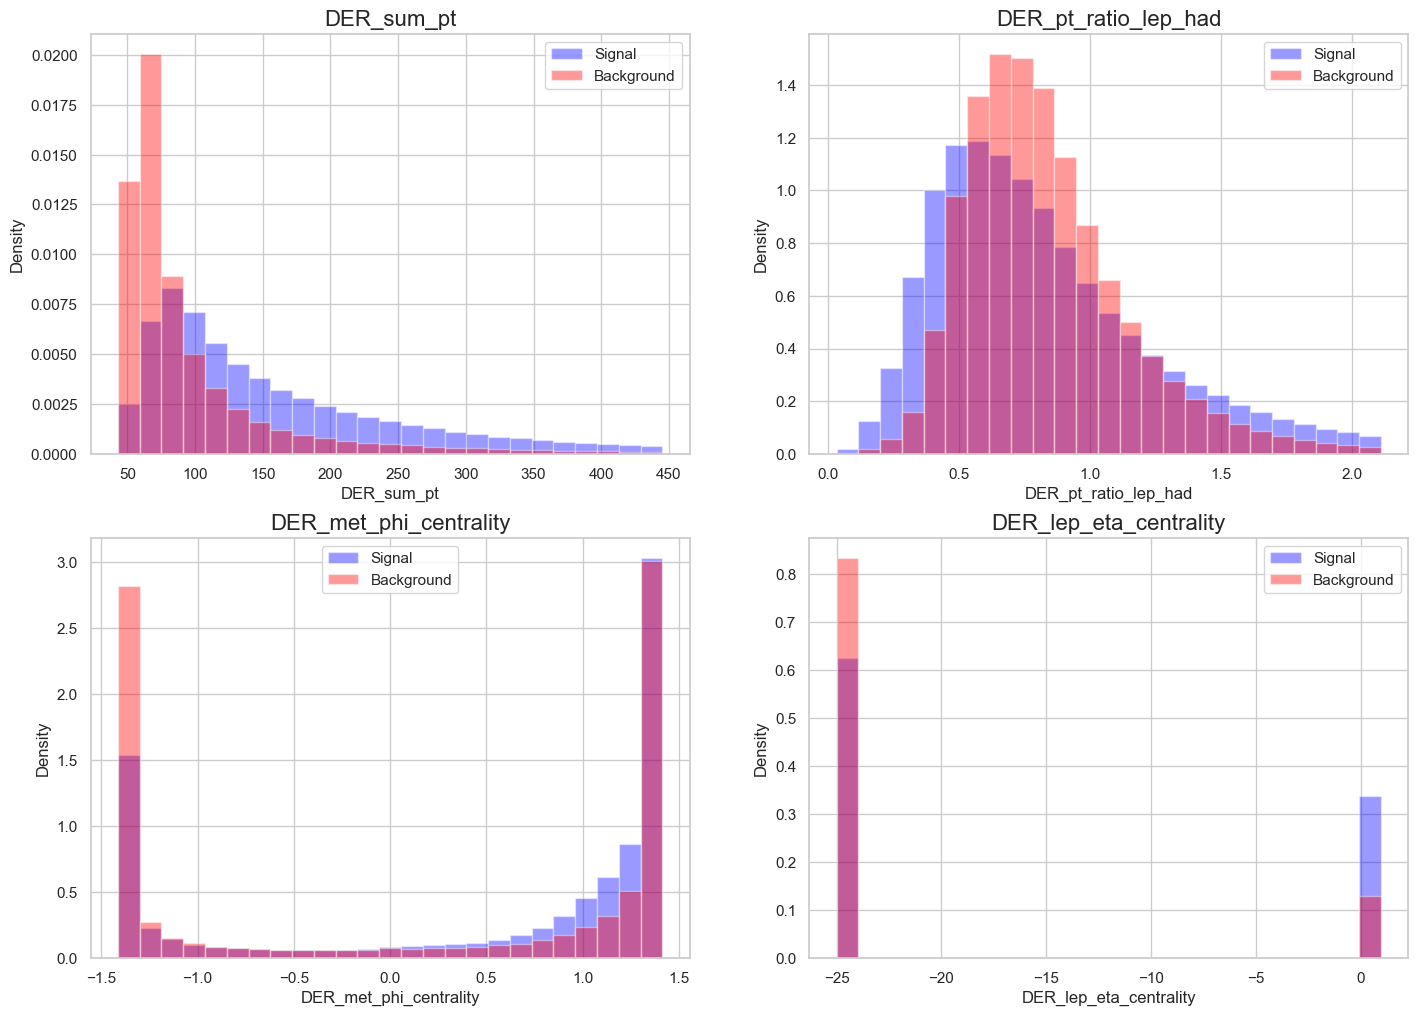

In [12]:
from utils import histogram_dataset

feature_columns = [col for col in data_set.columns if col.startswith("PRI_") or col.startswith("DER_")]

for i in range(0, len(feature_columns), 4):
    subset = feature_columns[i:i+4]
    histogram_dataset(data_set, data_set["labels"], data_set["weights"], columns=subset)

[*] --- PRI_lep_phi histogram
[*] --- PRI_met histogram
[*] --- DER_mass_vis histogram
[*] --- DER_deltaeta_jet_jet histogram


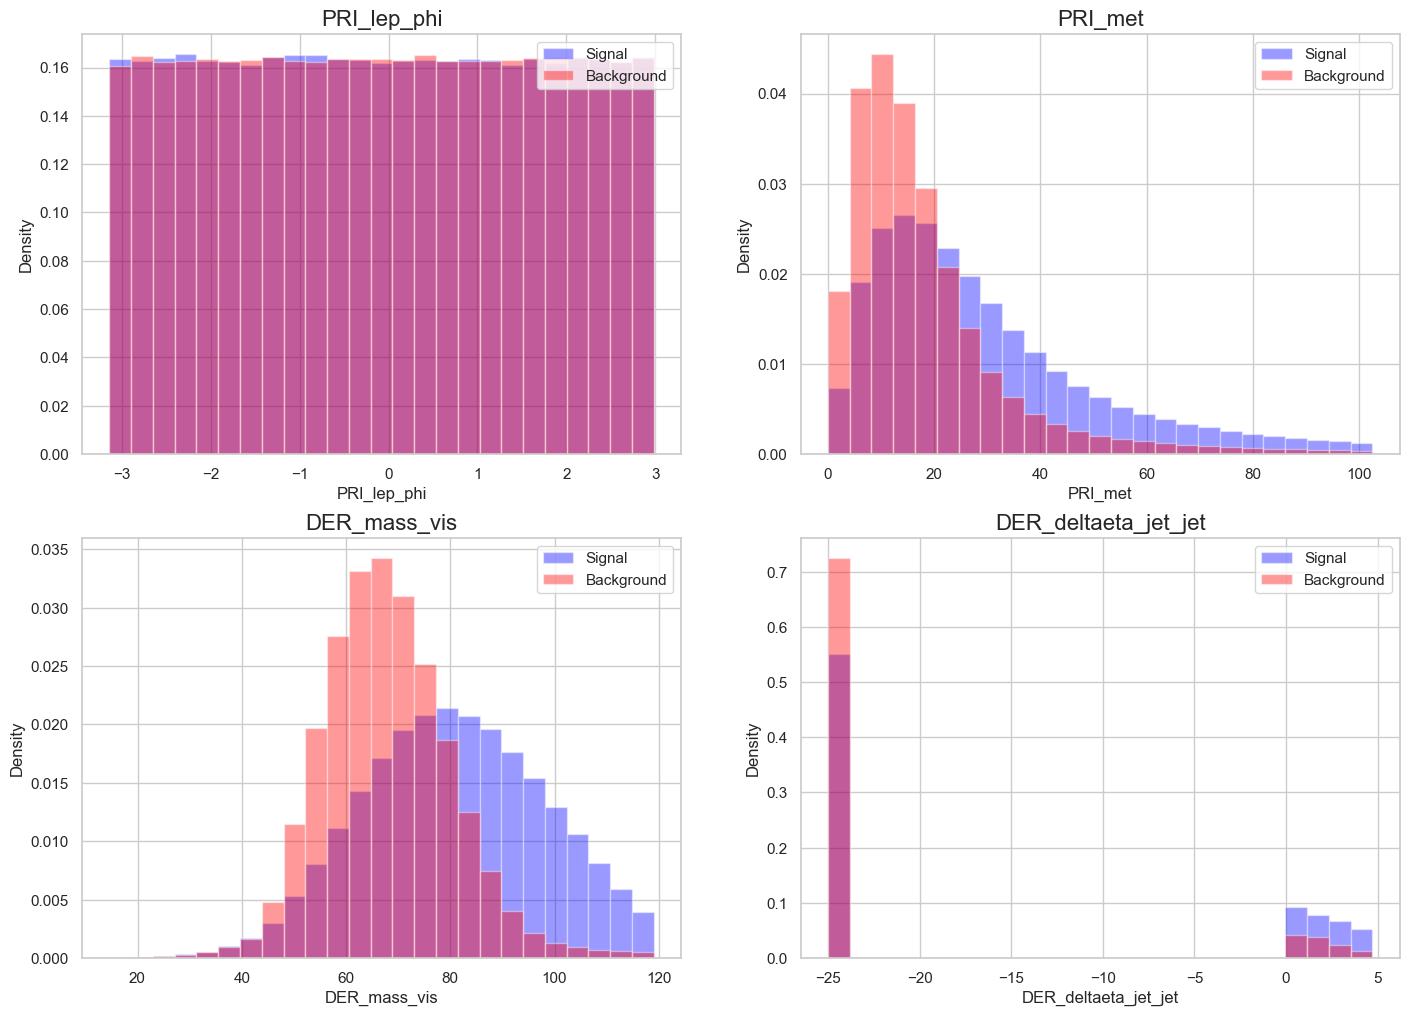

In [13]:
from utils import histogram_dataset

# this function is defined in utils.py in the sample_code_submission directory. feel free to modify it as needed

histogram_dataset(
    data_set,
    target,
    weights,
    columns=["PRI_lep_phi", "PRI_met", "DER_mass_vis", "DER_deltaeta_jet_jet"],
)

Signal feature  correlation matrix


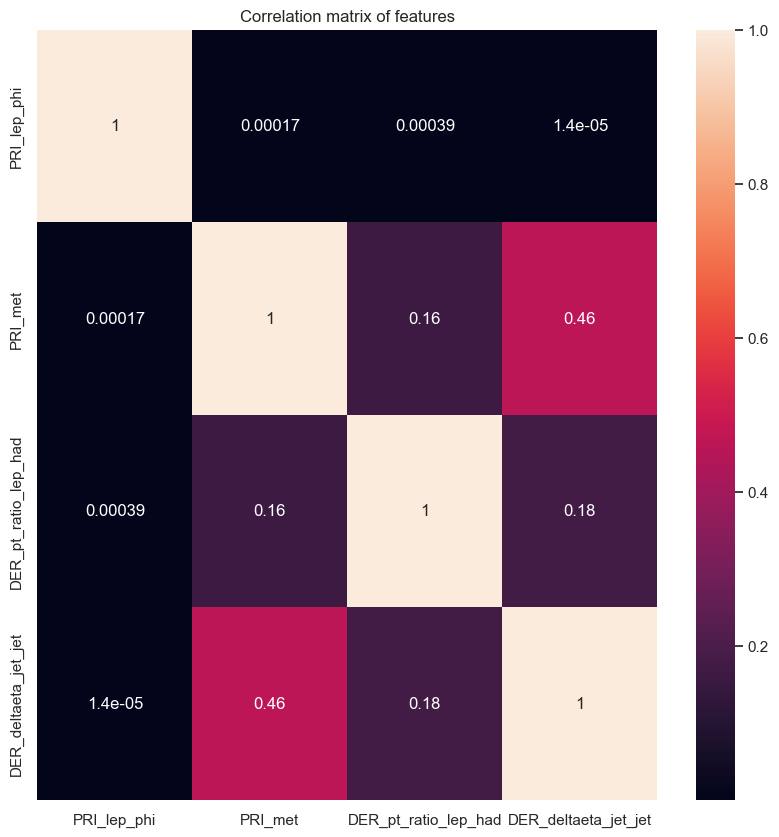

Background feature  correlation matrix


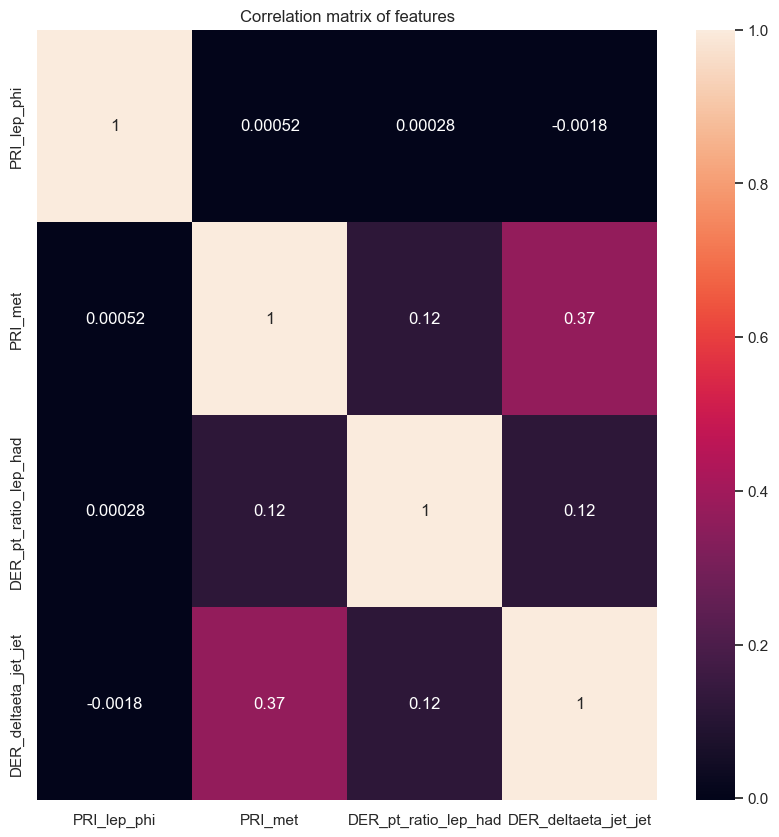

In [14]:
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (10, 10)}, style="whitegrid")

caption = ["Signal feature", "Background feature"]

for i in range(2):

    dfplot = pd.DataFrame(
        data_set,
        columns=[
            "PRI_lep_phi",
            "PRI_met",
            "DER_pt_ratio_lep_had",
            "DER_deltaeta_jet_jet",
        ],
    )

    print(caption[i], " correlation matrix")
    corrMatrix = dfplot[target == i].corr()
    sns.heatmap(corrMatrix, annot=True)
    plt.title("Correlation matrix of features")
    plt.show()

del dfplot

keys ['diboson' 'htautau' 'ttbar' 'ztautau']
keys 2 dict_keys(['diboson', 'htautau', 'ttbar', 'ztautau'])
htautau (30,)


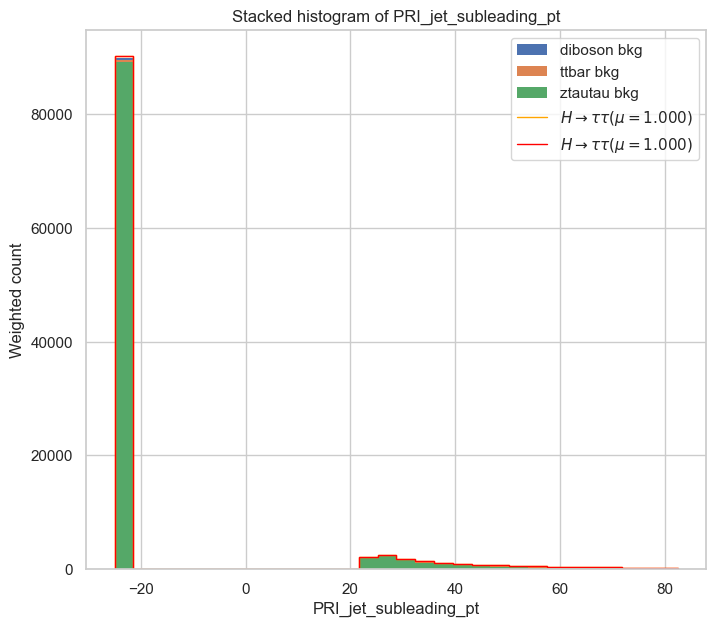

In [15]:
from HiggsML.visualization import stacked_histogram

stacked_histogram(data_set, target, weights, detailed_label, "PRI_jet_subleading_pt")

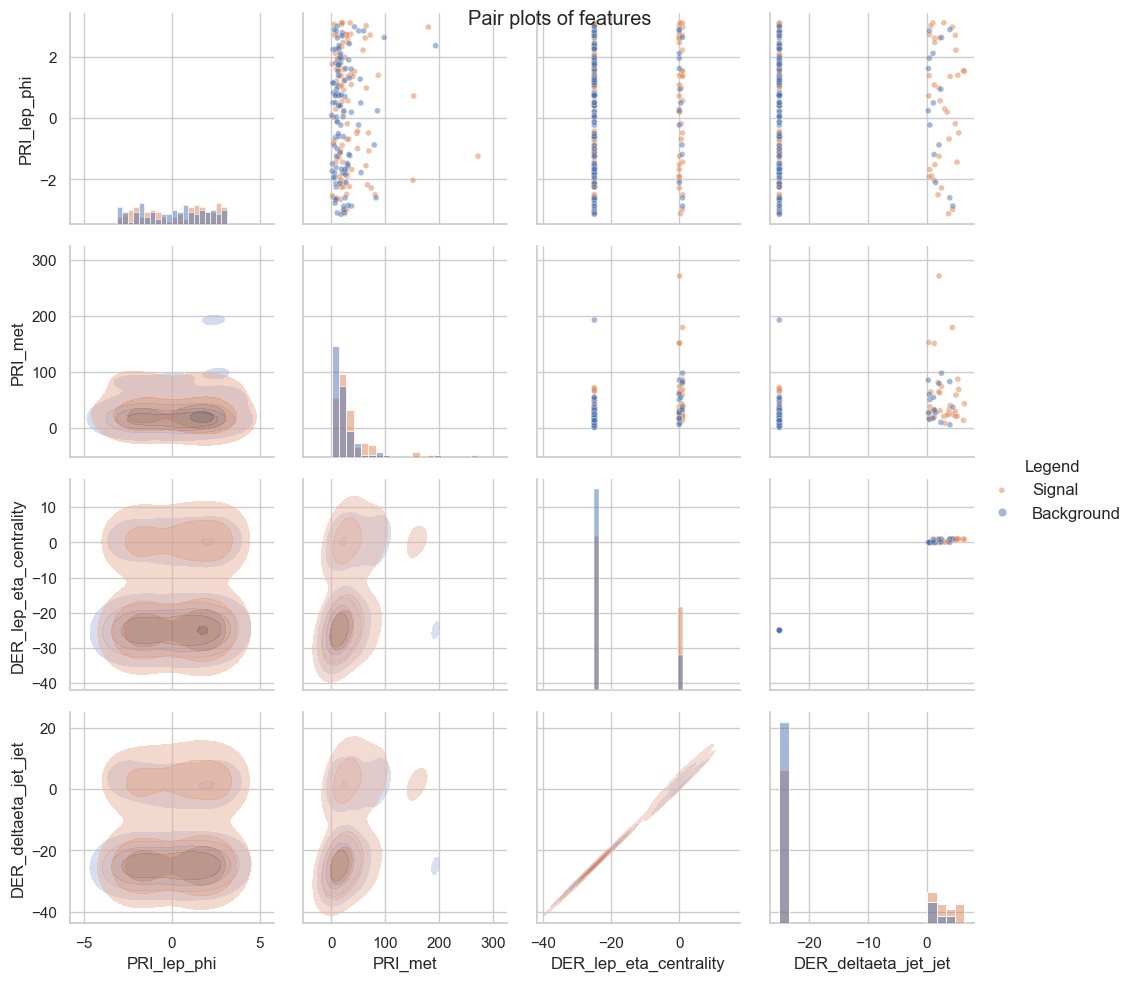

In [16]:
from HiggsML.visualization import pair_plots

# Show data summary
pair_plots(
    data_set,
    target,
    sample_size=100,
    columns=[
        "PRI_lep_phi",
        "PRI_met",
        "DER_lep_eta_centrality",
        "DER_deltaeta_jet_jet",
    ],
)

In [19]:
print("Signal weight sum:", weights[labels == 1].sum())
print("Background weight sum:", weights[labels == 0].sum())


Signal weight sum: 675.8967059699785
Background weight sum: 105043.10329403


2025-06-04 16:08:52,026 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-06-04 16:08:52,922 - HiggsML.datasets     - INFO     - Data loaded successfully


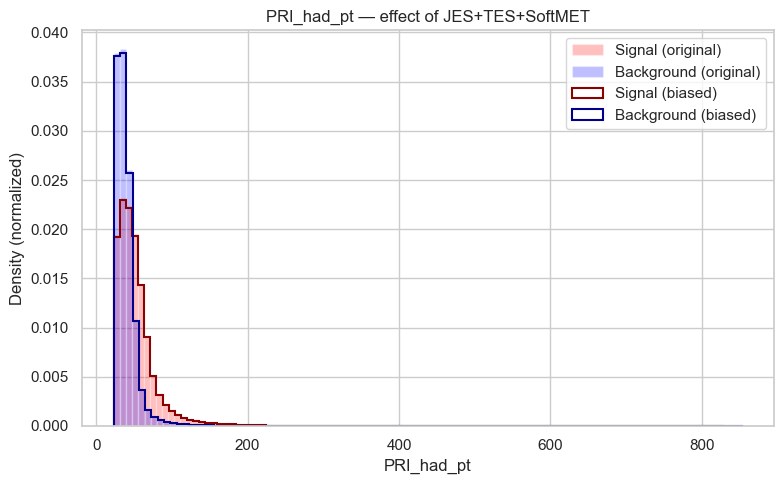

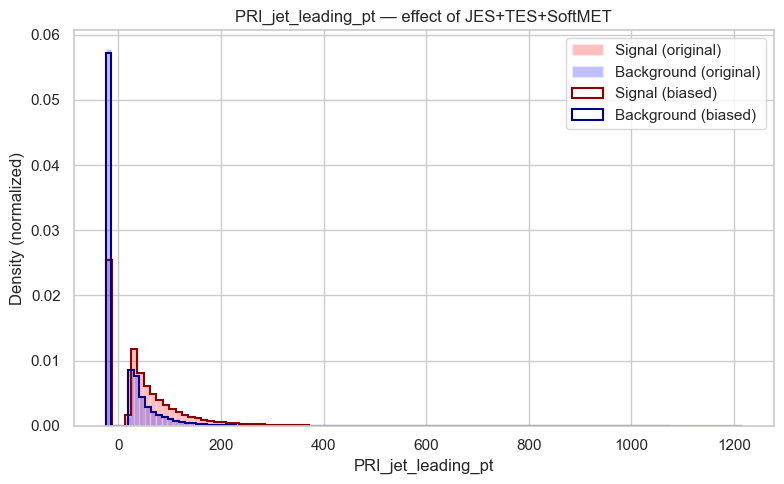

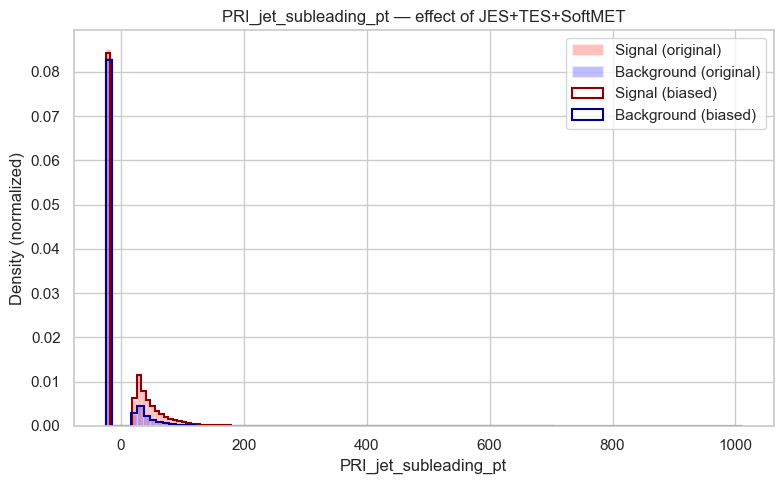

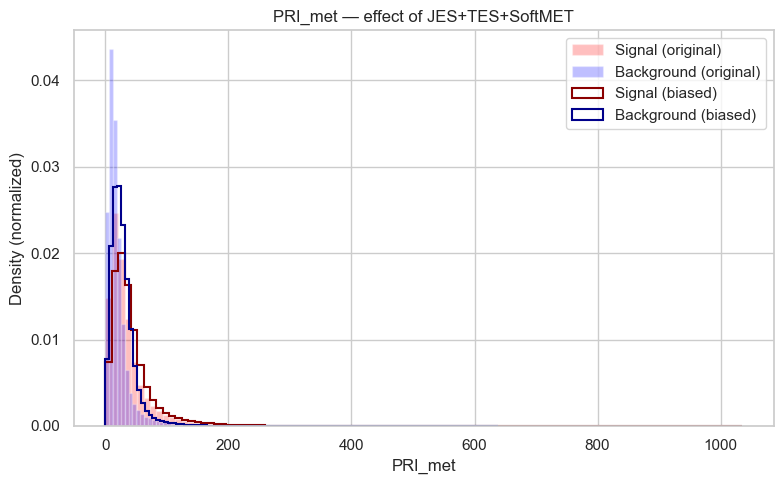

In [37]:
# import numpy as np
# import matplotlib.pyplot as plt
# from systematics import systematics

# # ==== 加载原始数据集（假设你已经有 original_df） ====
# # 如果没有，请先运行：
# data.load_train_set()
# original_df = data.get_train_set()

# # ==== 应用系统偏差 ====
# biased_df = systematics(
#     {"data": original_df, "weights": np.ones(len(original_df))},
#     tes=1.01,
#     jes=1.01,
#     soft_met=15,
#     ttbar_scale=1.0,
#     diboson_scale=1.0,
#     bkg_scale=1.0,
#     dopostprocess=False
# )["data"]

# # ==== 可视化设置 ====
# features = ["PRI_tau_pt", "PRI_jet_leading_pt", "PRI_jet_subleading_pt", "PRI_met"]
# colors = {
#     "Signal (original)": "red",
#     "Signal (biased)": "darkred",
#     "Background (original)": "blue",
#     "Background (biased)": "darkblue"
# }

# labels = original_df["labels"]
# weights = original_df["weights"]

# biased_labels = biased_df["labels"]
# biased_weights = biased_df["weights"]

# # ==== 画图 ====
# for feat in features:
#     if feat not in original_df.columns or feat not in biased_df.columns:
#         continue

#     plt.figure(figsize=(8, 5))

#     # 原始数据
#     plt.hist(original_df[feat][labels == 1], bins=50, weights=weights[labels == 1],
#              label="Signal (original)", color=colors["Signal (original)"], alpha=0.25, density=True)
#     plt.hist(original_df[feat][labels == 0], bins=50, weights=weights[labels == 0],
#              label="Background (original)", color=colors["Background (original)"], alpha=0.25, density=True)

#     # 有偏数据
#     plt.hist(biased_df[feat][biased_labels == 1], bins=50, weights=biased_weights[biased_labels == 1],
#              label="Signal (biased)", histtype="step", color=colors["Signal (biased)"], linewidth=1.5, density=True)
#     plt.hist(biased_df[feat][biased_labels == 0], bins=50, weights=biased_weights[biased_labels == 0],
#              label="Background (biased)", histtype="step", color=colors["Background (biased)"], linewidth=1.5, density=True)

#     plt.title(f"{feat} — effect of JES+TES+SoftMET")
#     plt.xlabel(feat)
#     plt.ylabel("Density (normalized)")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


import numpy as np
import matplotlib.pyplot as plt
from HiggsML.systematics import systematics

# ==== Load the original dataset original_df ====
data.load_train_set()
original_df = data.get_train_set()

# === Apply systematic biases and extract data and weights ===
biased = systematics(
    {"data": original_df, "weights": np.ones(len(original_df))},
    tes=1.01,
    jes=1.01,
    soft_met=15,
    ttbar_scale=1.0,
    diboson_scale=1.0,
    bkg_scale=1.0,
    dopostprocess=False
)

biased_df = biased["data"]
biased_weights = biased["weights"]

# === Visualize affected features ===
features = ["PRI_had_pt", "PRI_jet_leading_pt", "PRI_jet_subleading_pt", "PRI_met"]
labels = original_df["labels"]
weights = original_df["weights"]
biased_labels = biased_df["labels"]

for feat in features:
    if feat not in original_df.columns or feat not in biased_df.columns:
        continue

    plt.figure(figsize=(8, 5))
    
    # Original signal and background
    plt.hist(original_df[feat][labels == 1], bins=100, weights=weights[labels == 1],
             label="Signal (original)", color="red", alpha=0.25, density=True)
    plt.hist(original_df[feat][labels == 0], bins=100, weights=weights[labels == 0],
             label="Background (original)", color="blue", alpha=0.25, density=True)

    # Biased signal and background
    plt.hist(biased_df[feat][biased_labels == 1], bins=100, weights=biased_weights[biased_labels == 1],
             label="Signal (biased)", histtype="step", color="darkred", linewidth=1.5, density=True)
    plt.hist(biased_df[feat][biased_labels == 0], bins=100, weights=biased_weights[biased_labels == 0],
             label="Background (biased)", histtype="step", color="darkblue", linewidth=1.5, density=True)

    plt.title(f"{feat} — effect of JES+TES+SoftMET")
    plt.xlabel(feat)
    plt.ylabel("Density (normalized)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
print("Columns in original_df:", original_df.columns.tolist())
print("Columns in biased_df:", biased_df.columns.tolist())

Columns in original_df: ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_n_jets', 'PRI_jet_all_pt', 'PRI_met', 'PRI_met_phi', 'weights', 'detailed_labels', 'labels', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_had', 'DER_met_phi_centrality', 'DER_lep_eta_centrality']
Columns in biased_df: ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_n_jets', 'PRI_jet_all_pt', 'PRI_met', 'PRI_met_phi', 'detailed_labels', 'labels', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'D

In [22]:
# 原始信号 + 背景总数
print("Full original signal:", (original_df["labels"] == 1).sum())
print("Full original background:", (original_df["labels"] == 0).sum())

# 当前参与绘图的信号/背景数量
print("Filtered signal used in plot:", sig.shape[0])
print("Filtered background used in plot:", bkg.shape[0])


Full original signal: 462981
Full original background: 937019
Filtered signal used in plot: 462981
Filtered background used in plot: 937019


2025-06-04 16:10:19,001 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-06-04 16:10:19,805 - HiggsML.datasets     - INFO     - Data loaded successfully


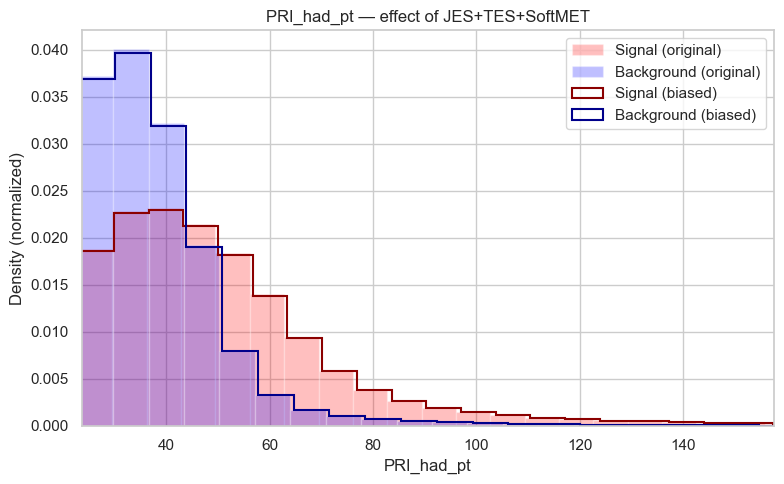

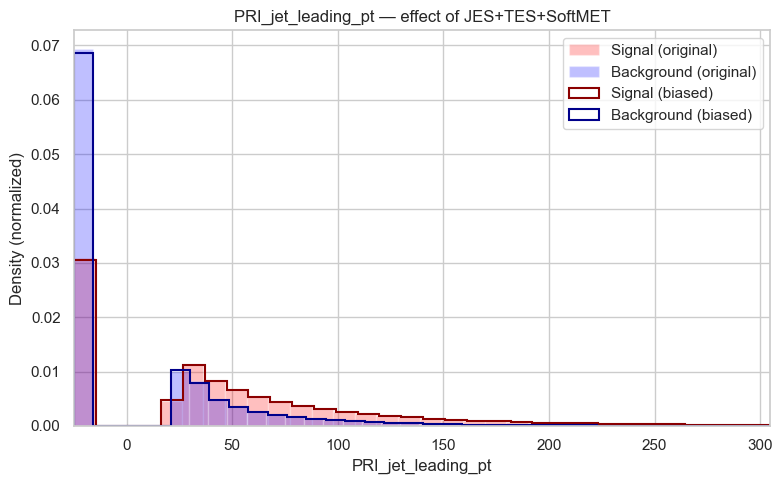

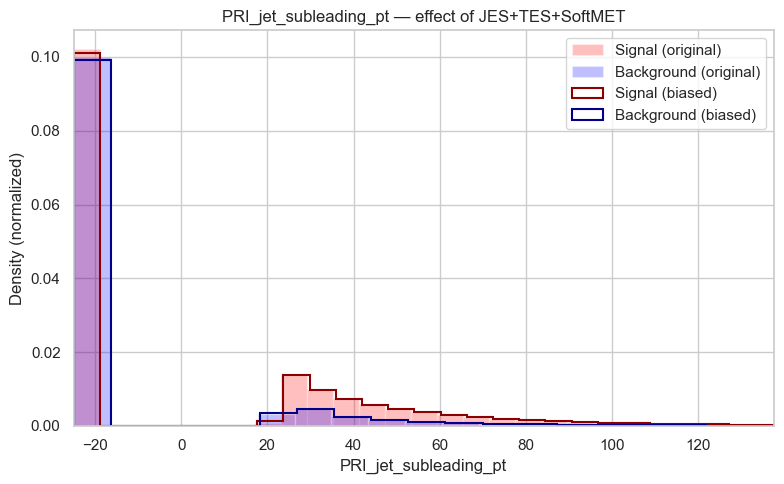

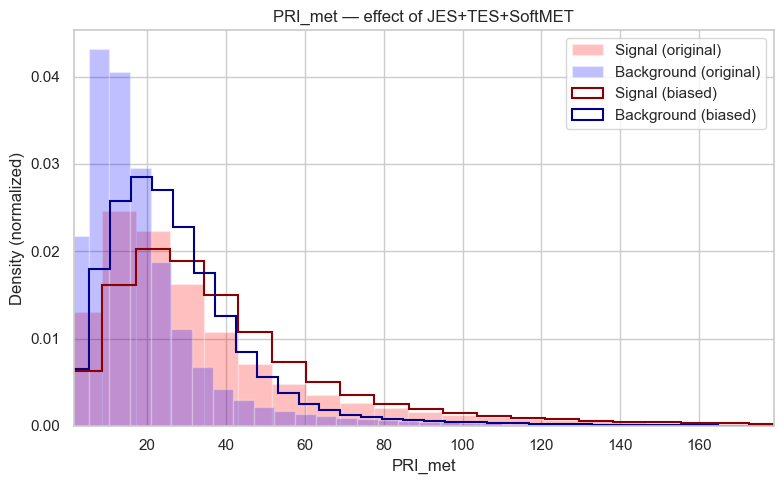

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from HiggsML.systematics import systematics

# ==== Load the original dataset ====
data.load_train_set()
original_df = data.get_train_set()

# === Apply systematic biases ===
biased = systematics(
    {"data": original_df, "weights": np.ones(len(original_df))},
    tes=1.01,
    jes=1.01,
    soft_met=15,
    ttbar_scale=1.0,
    diboson_scale=1.0,
    bkg_scale=1.0,
    dopostprocess=False
)

biased_df = biased["data"]
biased_weights = biased["weights"]

# === Define features to visualize ===
features = ["PRI_had_pt", "PRI_jet_leading_pt", "PRI_jet_subleading_pt", "PRI_met"]
labels = original_df["labels"]
weights = original_df["weights"]
biased_labels = biased_df["labels"]

for feat in features:
    if feat not in original_df.columns or feat not in biased_df.columns:
        continue

    # Combine all relevant values (original + biased) to compute robust x-axis range
    all_vals = pd.concat([original_df[feat], biased_df[feat]]).dropna()
    x_min, x_max = np.percentile(all_vals, [0.5, 99.5])  # Automatically clip extreme outliers

    plt.figure(figsize=(8, 5))

    # Original signal and background
    plt.hist(original_df[feat][labels == 1], bins=120, weights=weights[labels == 1],
             label="Signal (original)", color="red", alpha=0.25, density=True)
    plt.hist(original_df[feat][labels == 0], bins=120, weights=weights[labels == 0],
             label="Background (original)", color="blue", alpha=0.25, density=True)

    # Biased signal and background
    plt.hist(biased_df[feat][biased_labels == 1], bins=120, weights=biased_weights[biased_labels == 1],
             label="Signal (biased)", histtype="step", color="darkred", linewidth=1.5, density=True)
    plt.hist(biased_df[feat][biased_labels == 0], bins=120, weights=biased_weights[biased_labels == 0],
             label="Background (biased)", histtype="step", color="darkblue", linewidth=1.5, density=True)

    # Automatically set x-axis limit based on feature's central range
    plt.xlim(x_min, x_max)

    plt.title(f"{feat} — effect of JES+TES+SoftMET")
    plt.xlabel(feat)
    plt.ylabel("Density (normalized)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


2025-06-05 10:16:37,131 - HiggsML.datasets     - INFO     - Handling as dataset name: blackSwan_data
2025-06-05 10:16:37,133 - HiggsML.datasets     - INFO     - Current working directory: c:\Users\lenovo\Higgs_collaborations_Juefan
2025-06-05 10:16:37,133 - HiggsML.datasets     - INFO     - Total rows: 2000000
2025-06-05 10:16:37,133 - HiggsML.datasets     - INFO     - Test size: 600000
2025-06-05 10:16:37,249 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-06-05 10:16:38,095 - HiggsML.datasets     - INFO     - Data loaded successfully


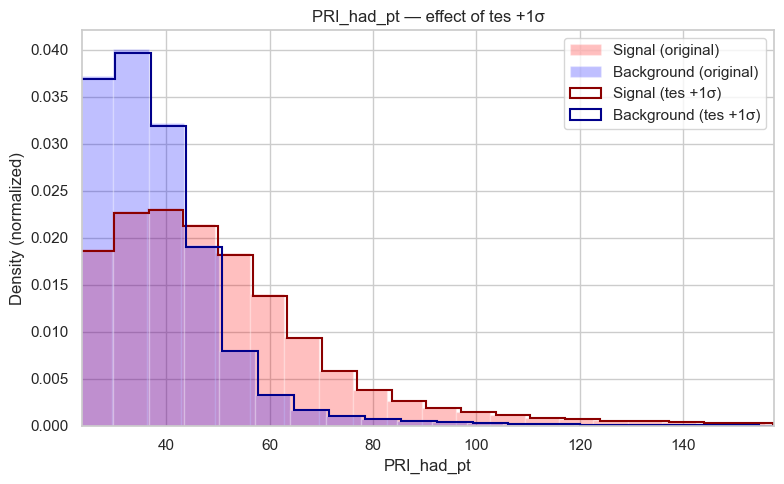

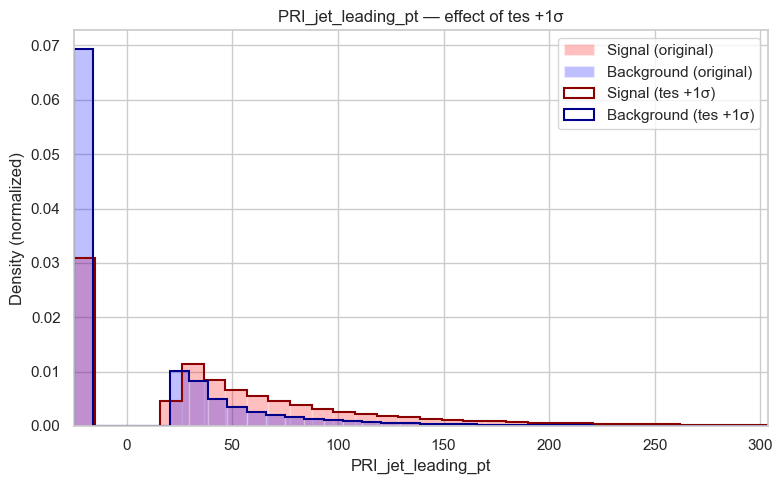

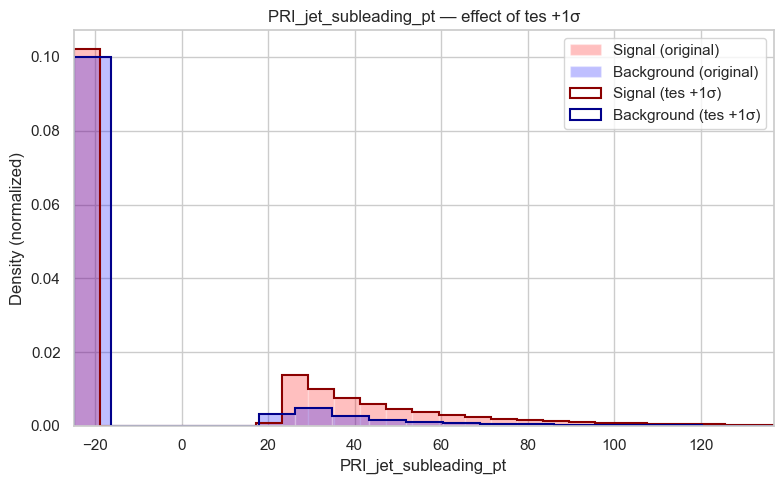

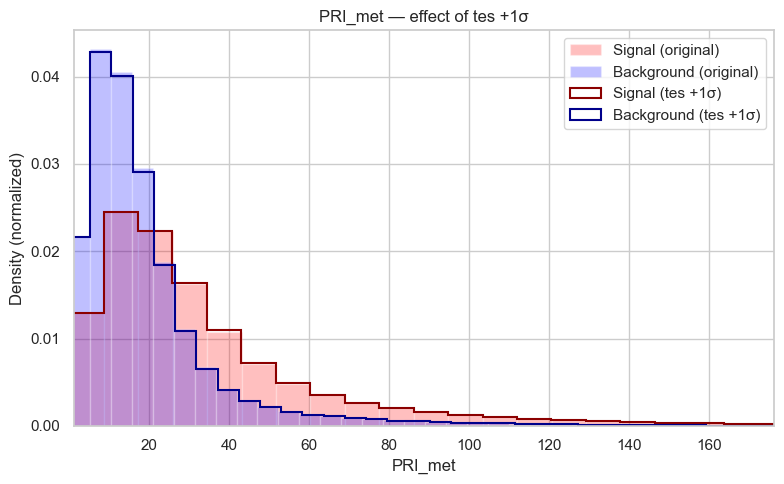

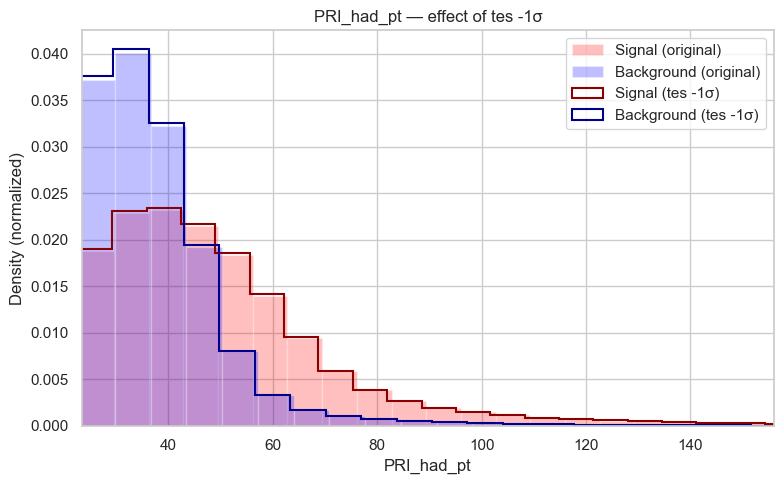

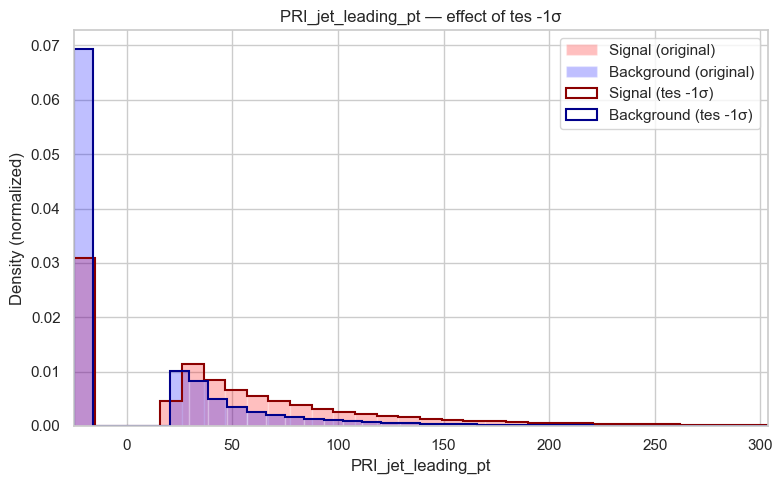

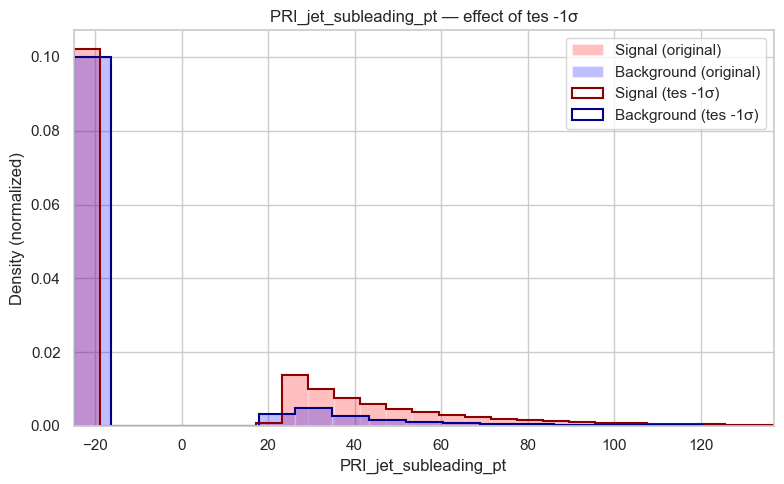

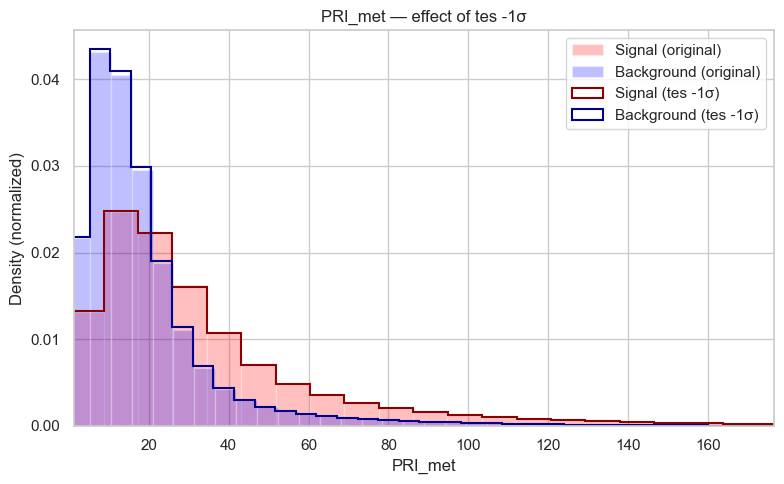

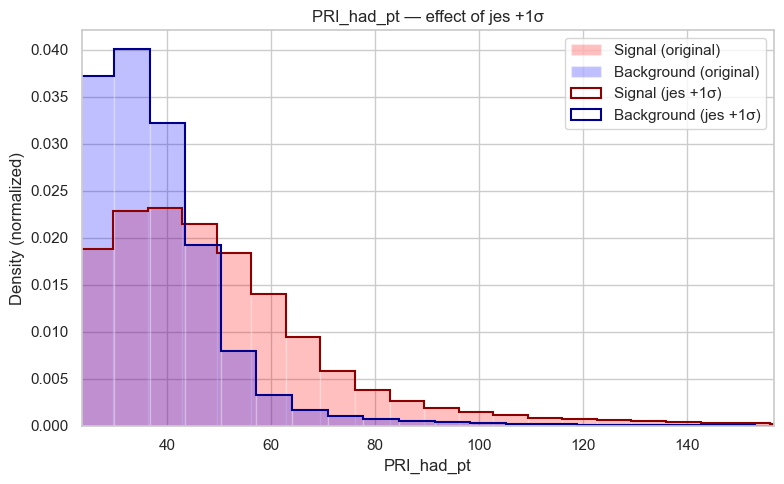

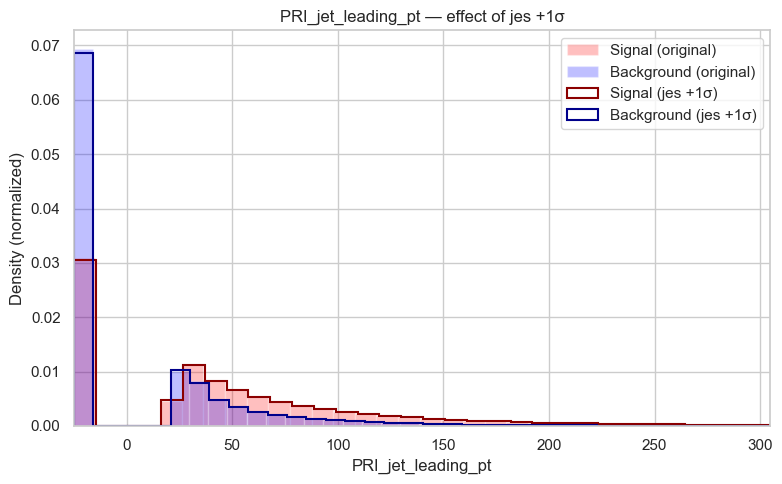

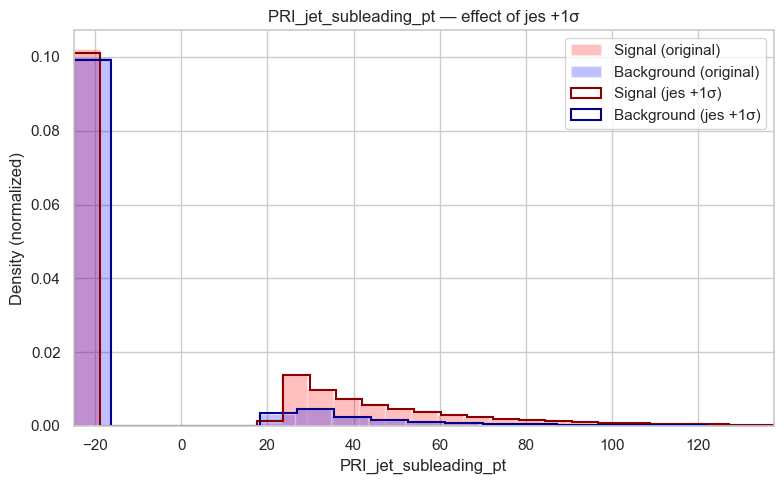

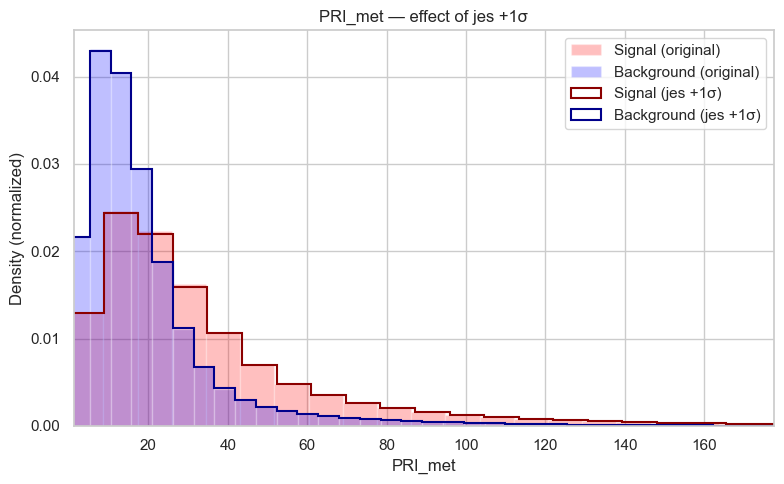

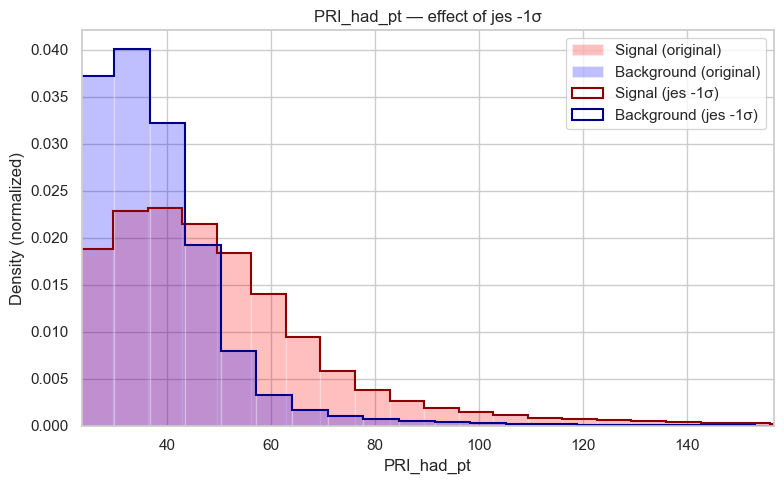

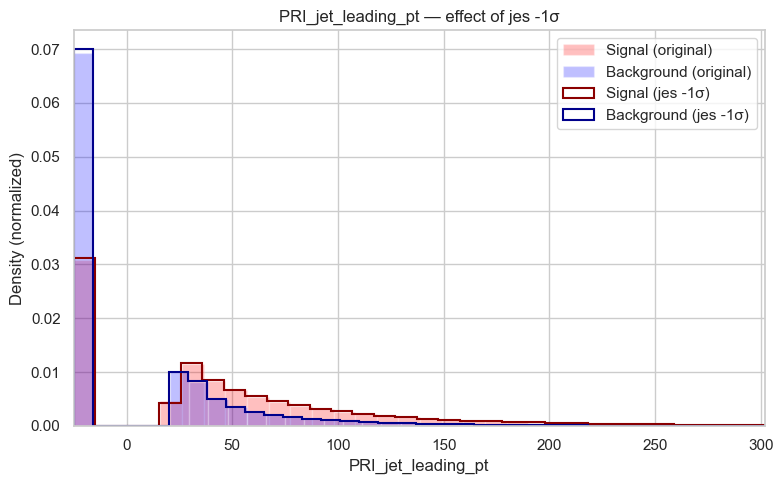

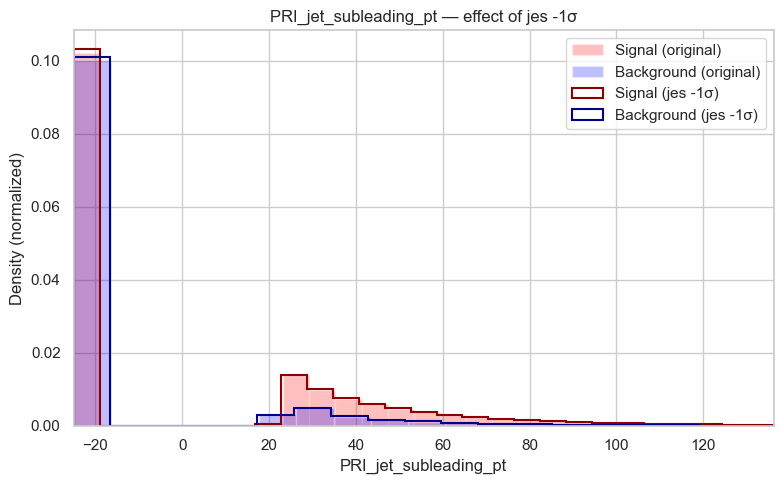

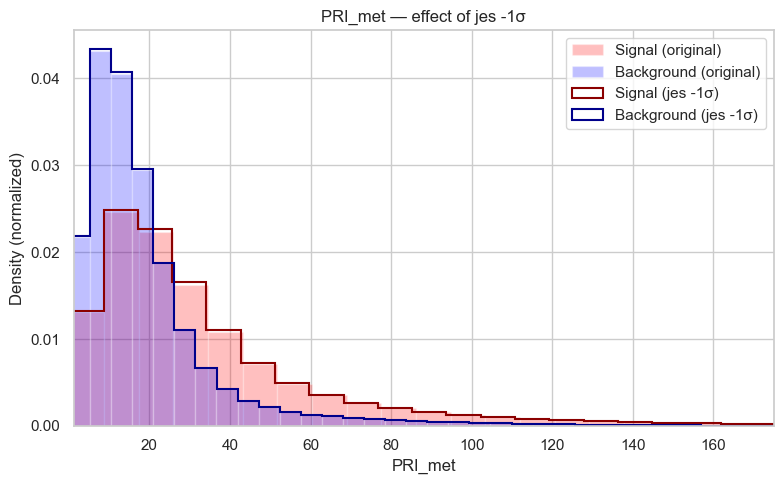

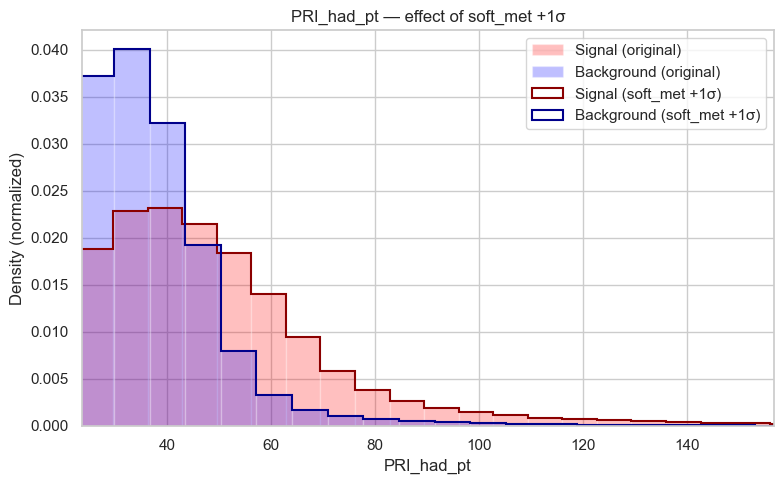

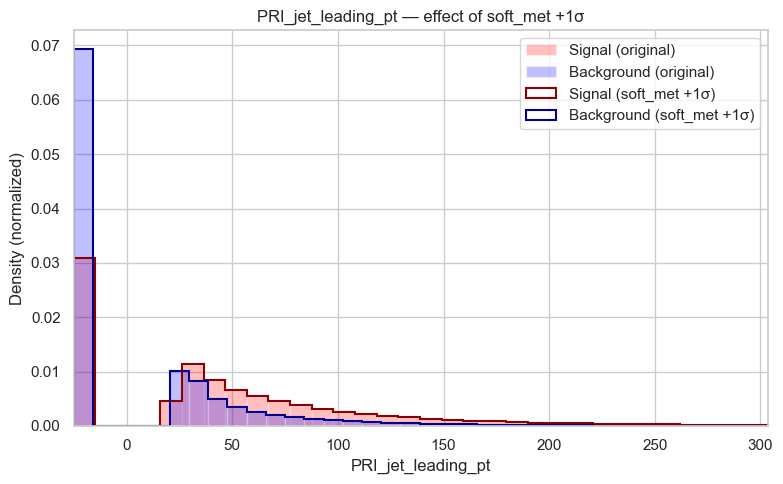

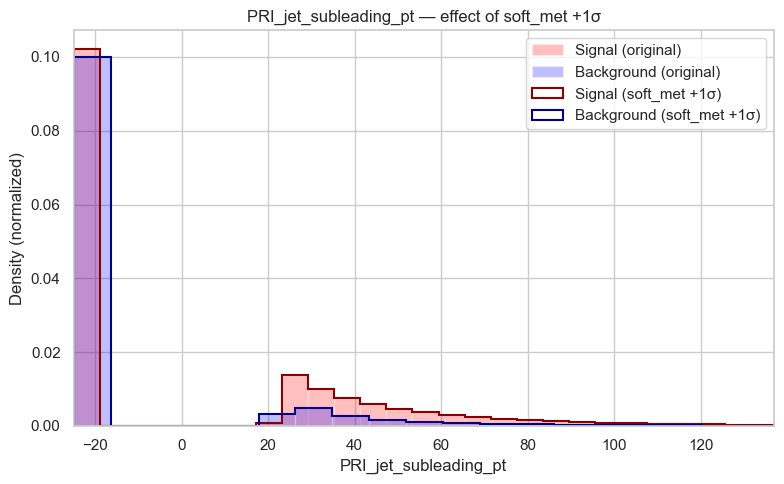

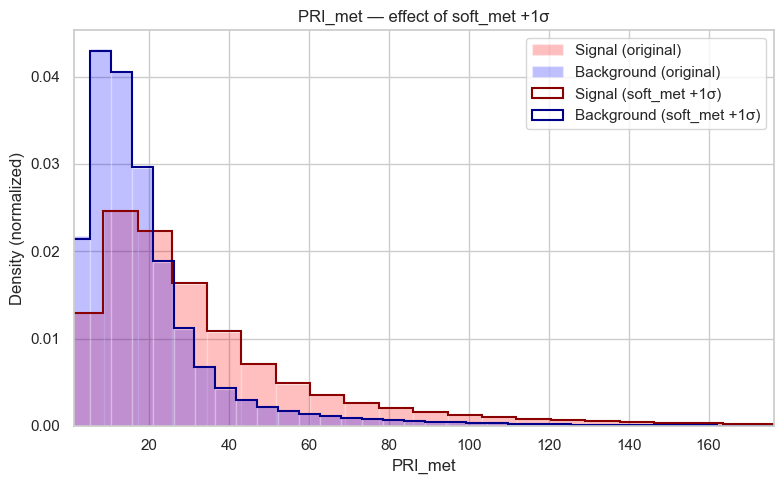

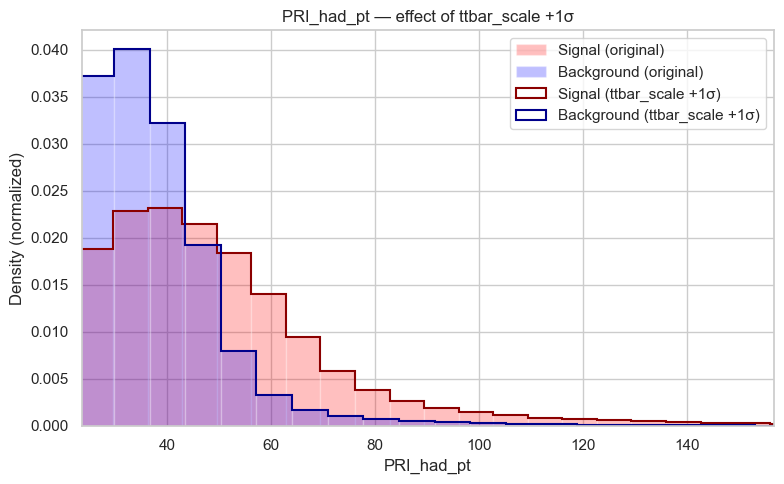

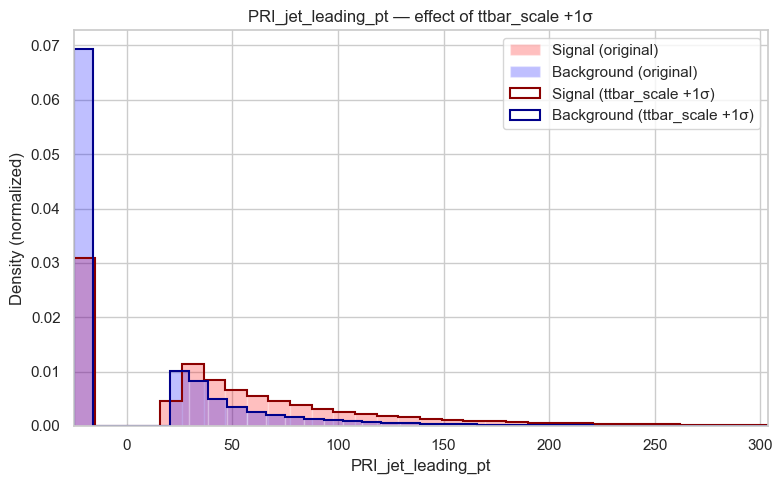

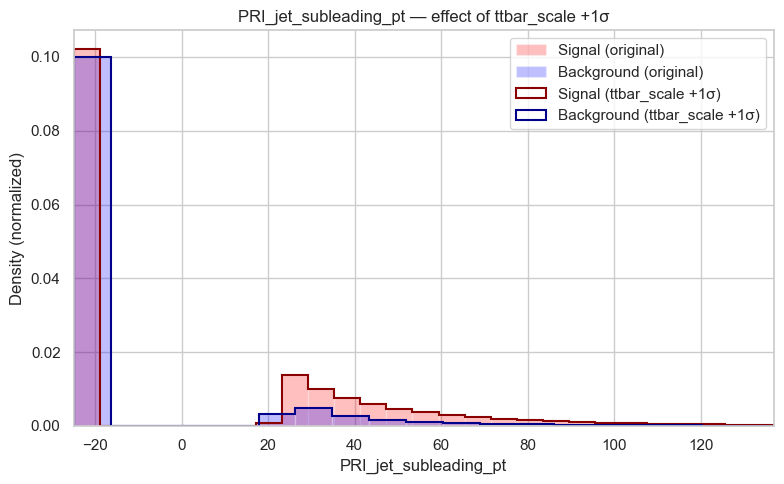

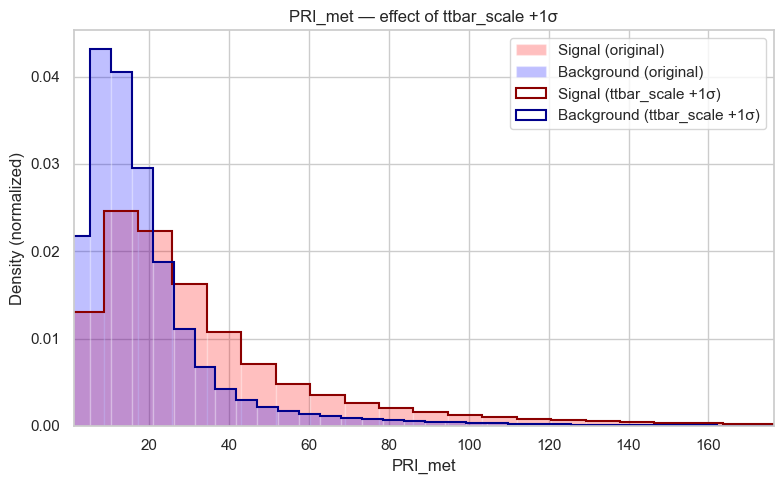

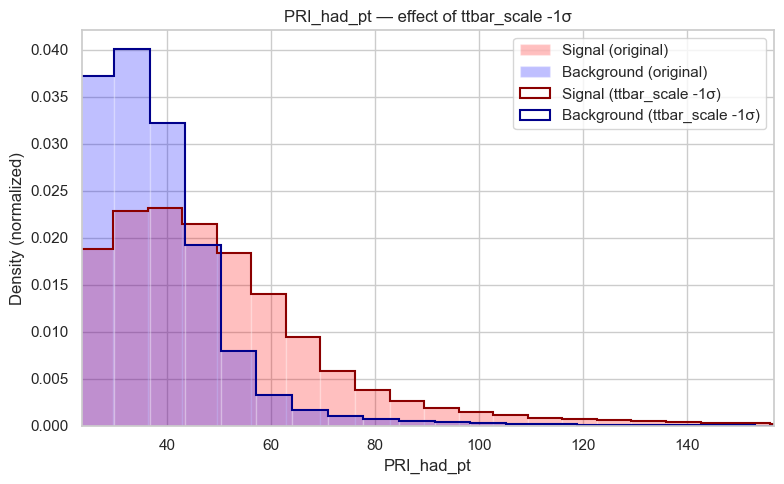

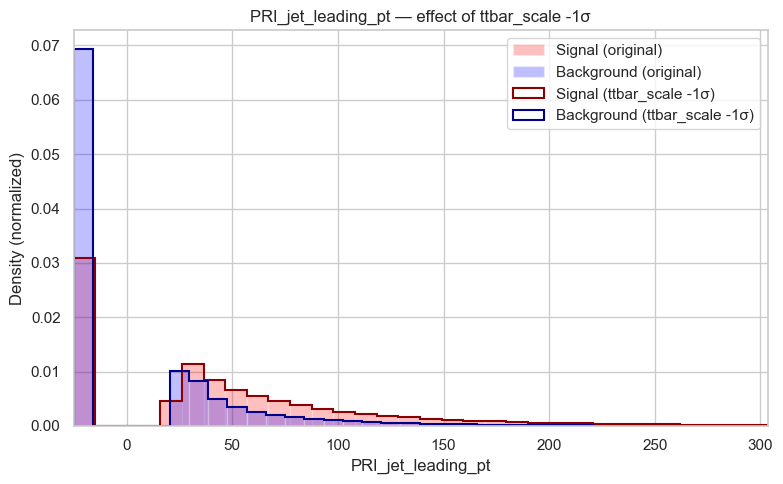

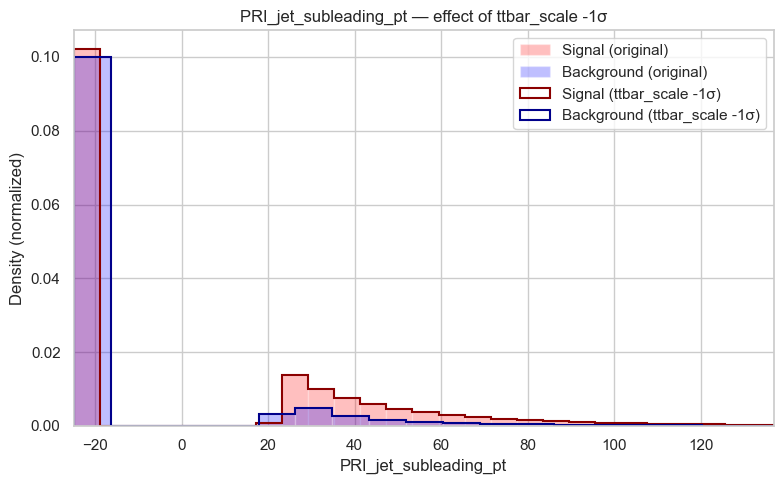

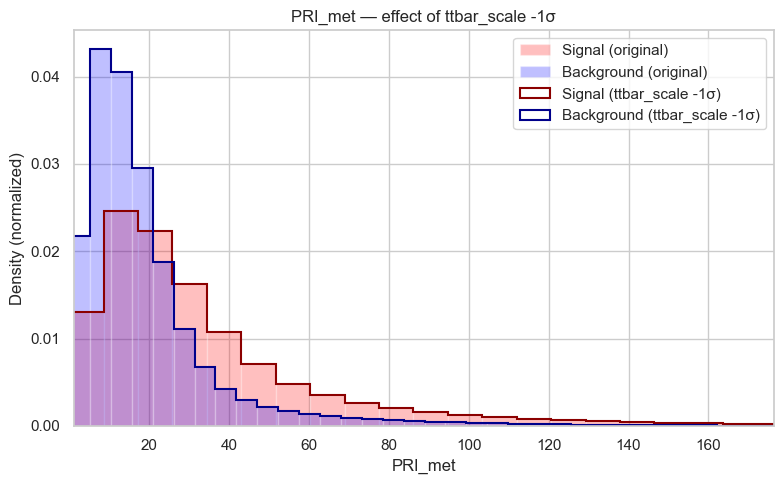

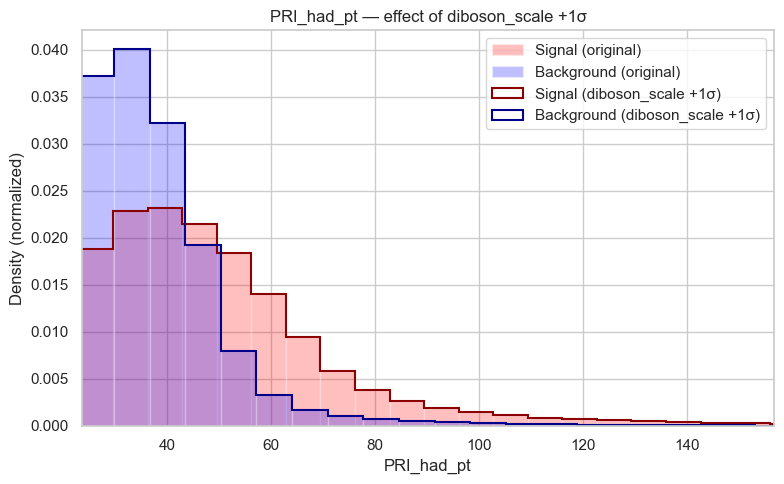

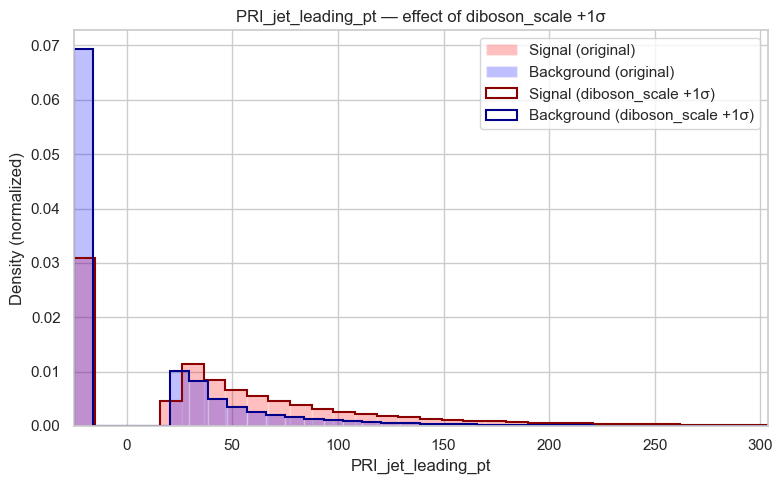

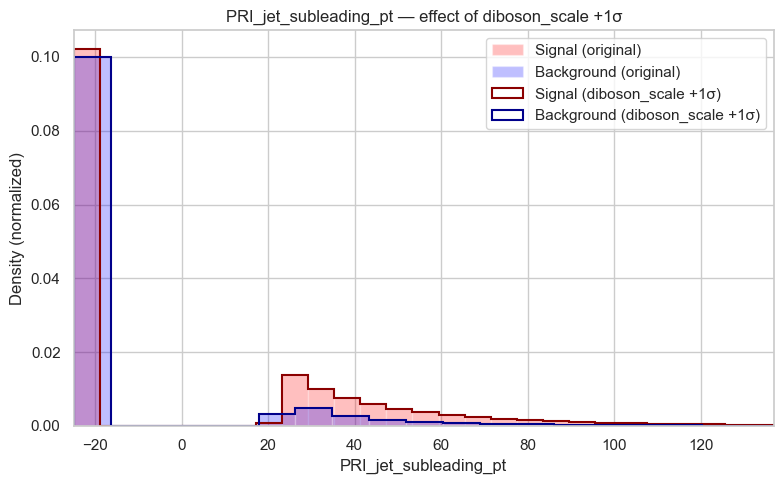

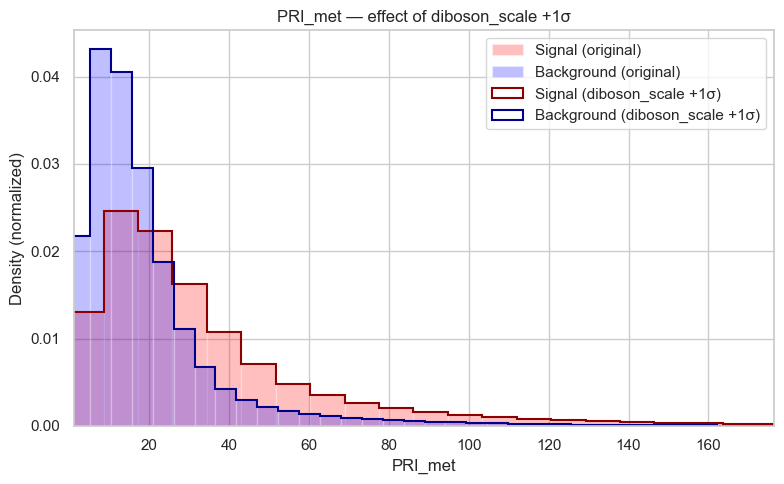

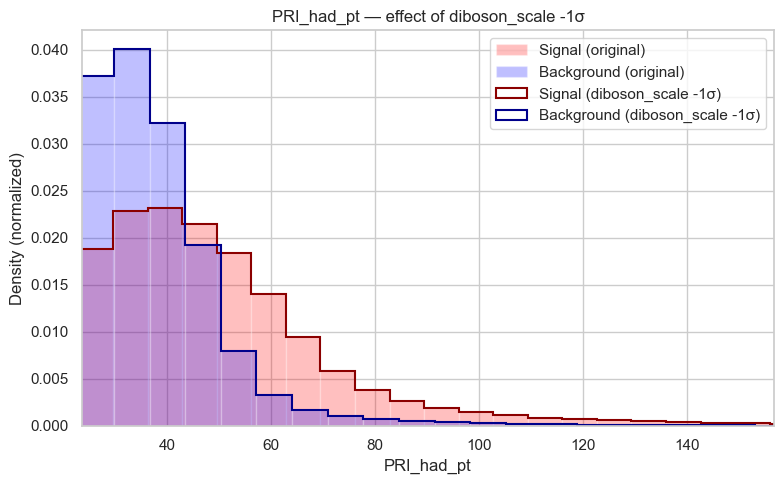

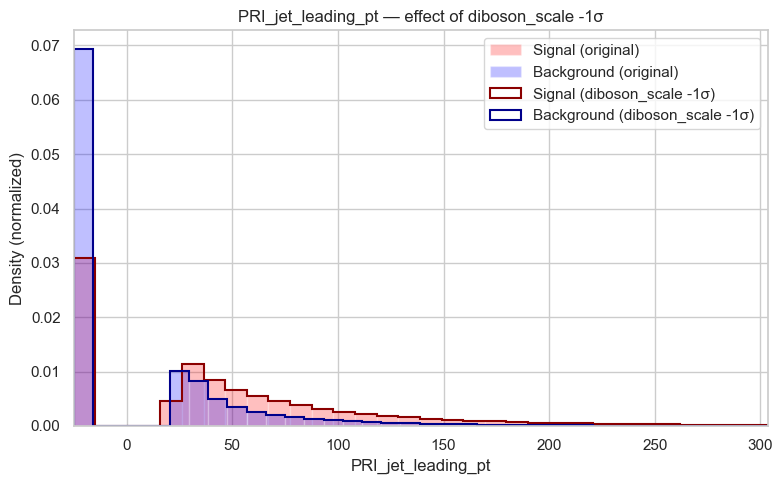

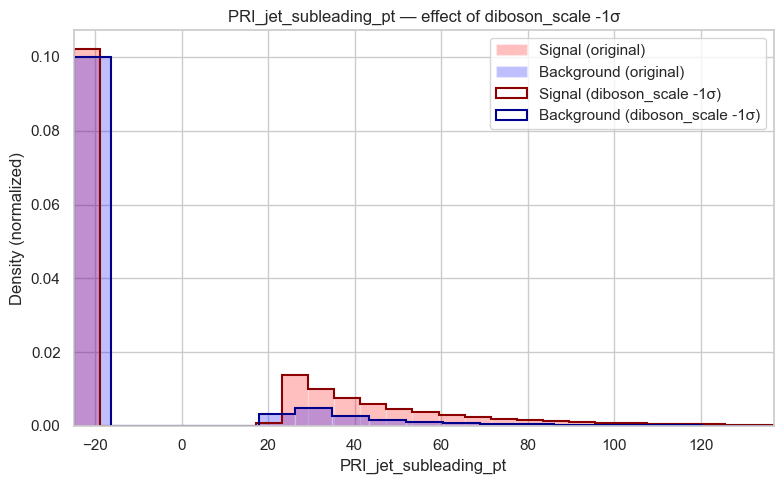

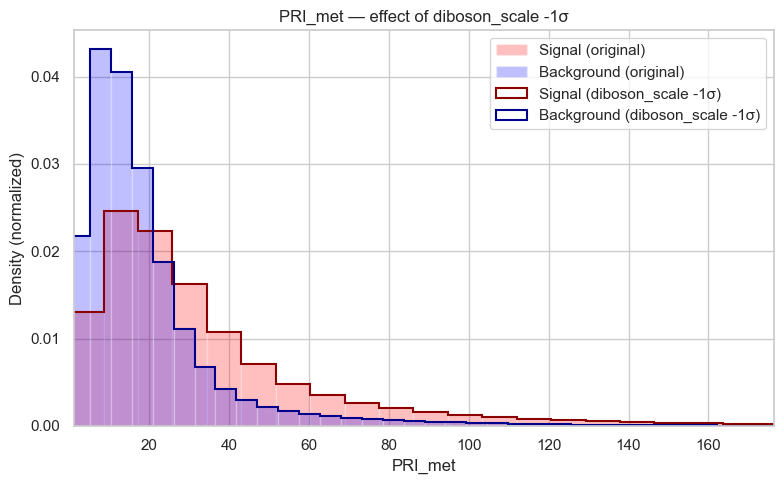

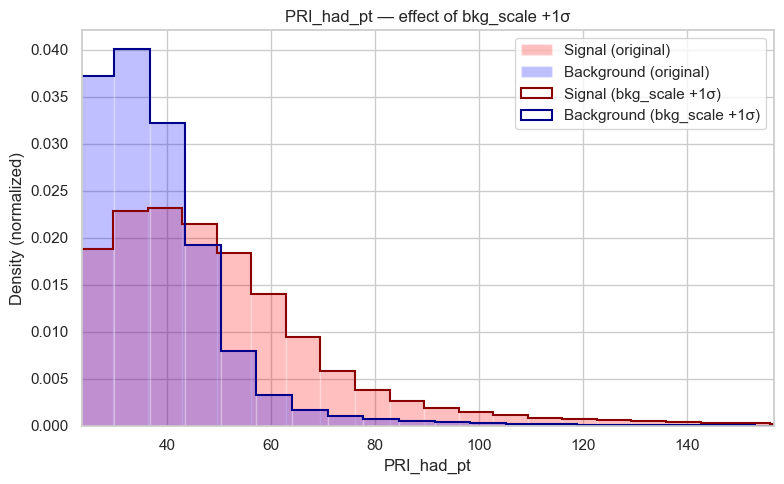

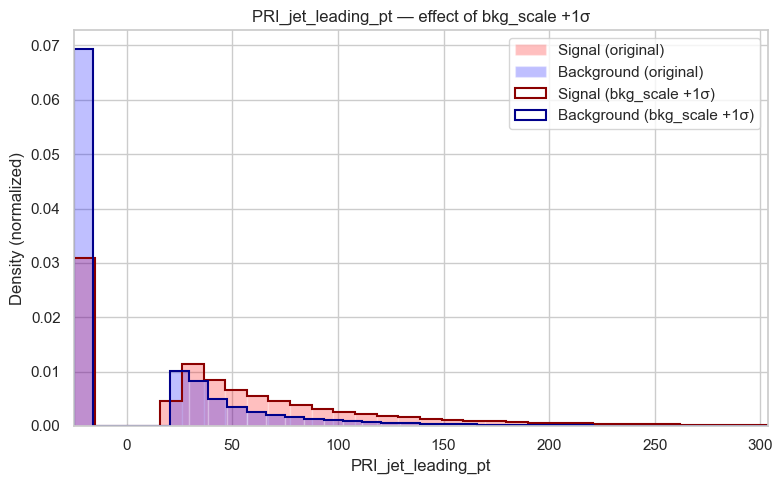

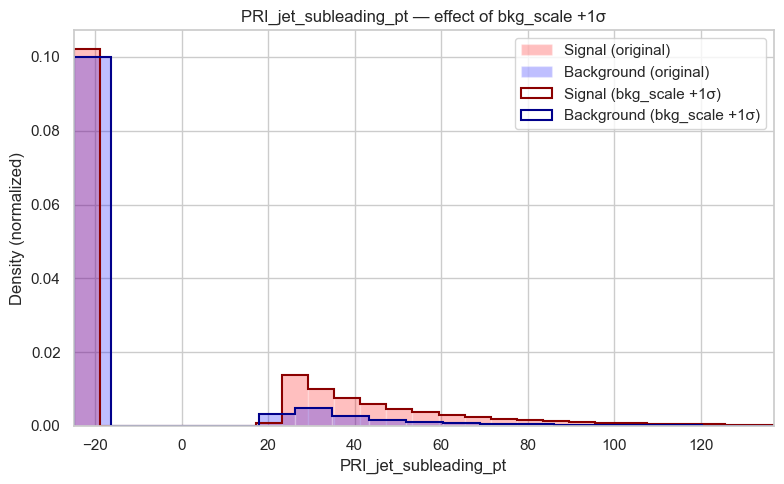

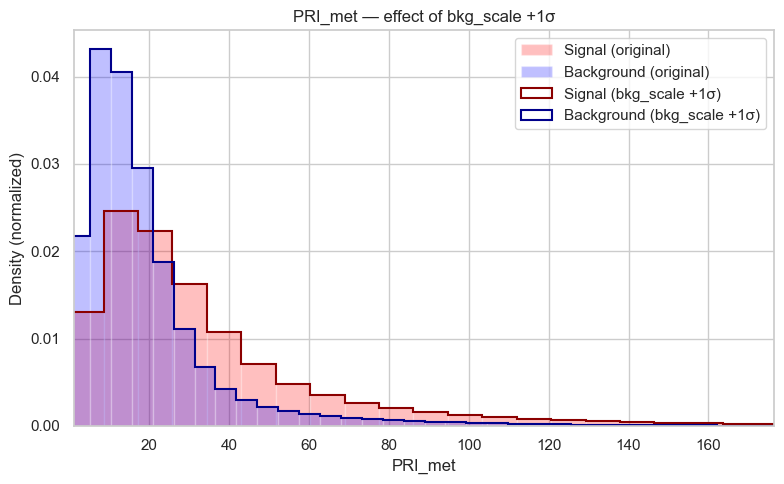

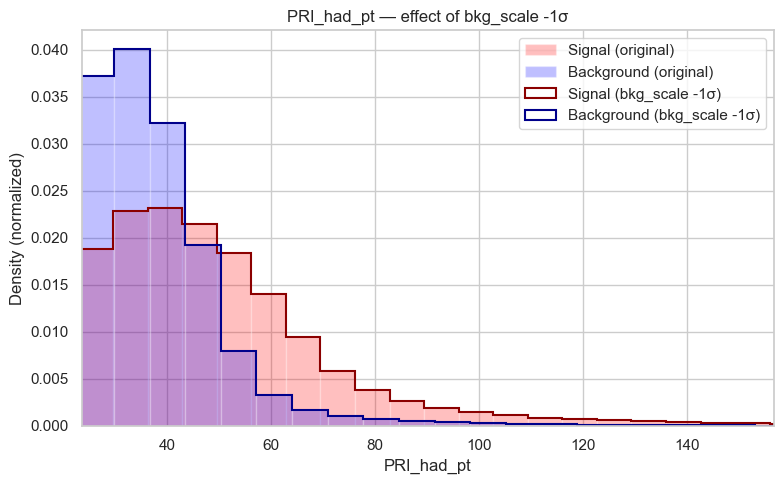

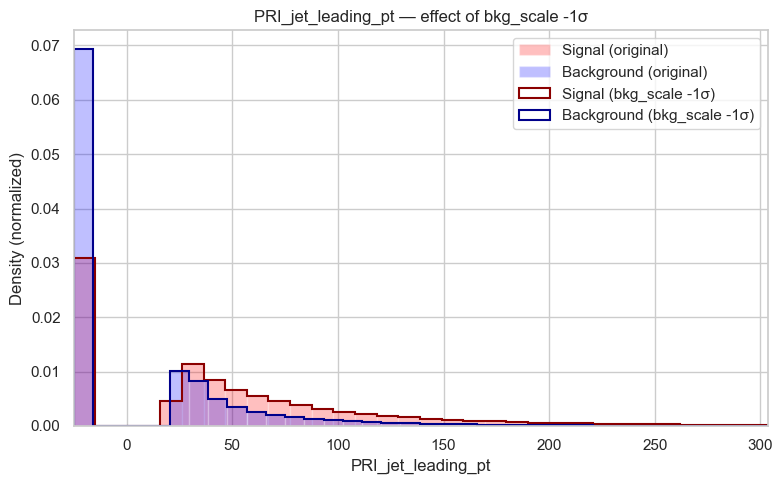

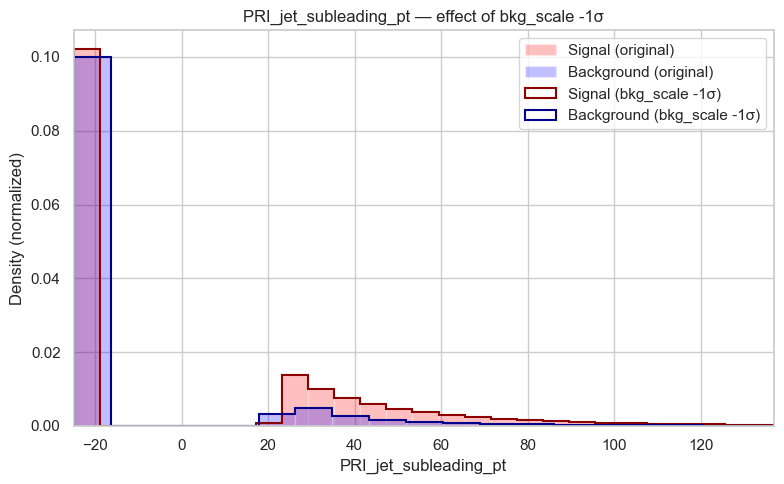

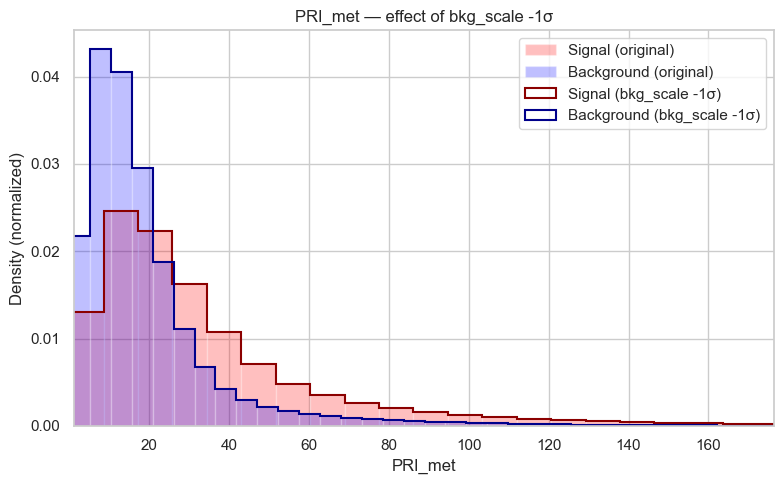

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from HiggsML.datasets import download_dataset
from HiggsML.systematics import systematics

# === Load dataset ===
data = download_dataset("blackSwan_data")
data.load_train_set()
original_df = data.get_train_set()
original_weights = original_df["weights"]
original_labels = original_df["labels"]

# === Define features to visualize ===
features = ["PRI_had_pt", "PRI_jet_leading_pt", "PRI_jet_subleading_pt", "PRI_met"]

# === Systematic bias config ===
biases = {
    "tes": {"mean": 1.0, "sigma": 0.01},
    "jes": {"mean": 1.0, "sigma": 0.01},
    "soft_met": {"mean": 0.0, "sigma": 1.0},  # log-normal
    "ttbar_scale": {"mean": 1.0, "sigma": 0.02},
    "diboson_scale": {"mean": 1.0, "sigma": 0.25},
    "bkg_scale": {"mean": 1.0, "sigma": 0.001}
}

# === For each bias, apply ±1σ (soft_met only +1σ), and plot for each feature ===
for bias_name, bias_info in biases.items():
    for shift in ["+1σ", "-1σ"]:
        if bias_name == "soft_met" and shift == "-1σ":
            continue

        # Set default values
        kwargs = {
            "tes": 1.0, "jes": 1.0, "soft_met": 0.0,
            "ttbar_scale": 1.0, "diboson_scale": 1.0, "bkg_scale": 1.0
        }
        value = bias_info["mean"] + bias_info["sigma"] if shift == "+1σ" else bias_info["mean"] - bias_info["sigma"]
        kwargs[bias_name] = value

        # Apply systematic
        biased_result = systematics(
            {"data": original_df.copy(), "weights": original_weights.copy()},
            **kwargs, dopostprocess=False
        )
        biased_df = biased_result["data"]
        biased_weights = biased_result["weights"]
        biased_labels = biased_df["labels"]

        for feat in features:
            if feat not in original_df.columns or feat not in biased_df.columns:
                continue

            # Smart x-axis
            all_vals = pd.concat([original_df[feat], biased_df[feat]]).dropna()
            x_min, x_max = np.percentile(all_vals, [0.5, 99.5])

            plt.figure(figsize=(8, 5))

            # Original
            plt.hist(original_df[feat][original_labels == 1], bins=120, weights=original_weights[original_labels == 1],
                     label="Signal (original)", color="red", alpha=0.25, density=True)
            plt.hist(original_df[feat][original_labels == 0], bins=120, weights=original_weights[original_labels == 0],
                     label="Background (original)", color="blue", alpha=0.25, density=True)

            # Biased
            plt.hist(biased_df[feat][biased_labels == 1], bins=120, weights=biased_weights[biased_labels == 1],
                     label=f"Signal ({bias_name} {shift})", histtype="step", color="darkred", linewidth=1.5, density=True)
            plt.hist(biased_df[feat][biased_labels == 0], bins=120, weights=biased_weights[biased_labels == 0],
                     label=f"Background ({bias_name} {shift})", histtype="step", color="darkblue", linewidth=1.5, density=True)

            plt.xlim(x_min, x_max)
            plt.title(f"{feat} — effect of {bias_name} {shift}")
            plt.xlabel(feat)
            plt.ylabel("Density (normalized)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from HiggsML.datasets import download_dataset
from HiggsML.systematics import systematics
import os

# === Load dataset ===
data = download_dataset("blackSwan_data")
data.load_train_set()
original_df = data.get_train_set()
original_weights = original_df["weights"]
original_labels = original_df["labels"]

# === Define features to visualize ===
features = ["PRI_had_pt", "PRI_jet_leading_pt", "PRI_jet_subleading_pt", "PRI_met"]

# === Systematic bias config ===
biases = {
    "tes": {"mean": 1.0, "sigma": 0.01},
    "jes": {"mean": 1.0, "sigma": 0.01},
    "soft_met": {"mean": 0.0, "sigma": 1.0},  # log-normal
    "ttbar_scale": {"mean": 1.0, "sigma": 0.02},
    "diboson_scale": {"mean": 1.0, "sigma": 0.25},
    "bkg_scale": {"mean": 1.0, "sigma": 0.001}
}

# === Output directories ===
os.makedirs("figures", exist_ok=True)
chi2_results = []

# === Add jet category column once ===
def categorize_jets(df):
    return df["PRI_n_jets"].apply(lambda x: "0j" if x == 0 else ("1j" if x == 1 else "2j+"))

original_df["jet_category"] = categorize_jets(original_df)

# === For each bias, apply ±1σ (soft_met only +1σ), and plot for each feature ===
for bias_name, bias_info in biases.items():
    for shift in ["+1σ", "-1σ"]:
        if bias_name == "soft_met" and shift == "-1σ":
            continue

        # Set bias kwargs
        kwargs = {key: val["mean"] for key, val in biases.items()}
        delta = bias_info["sigma"] if shift == "+1σ" else -bias_info["sigma"]
        kwargs[bias_name] += delta

        # Apply systematic bias
        biased_result = systematics(
            {"data": original_df.copy(), "weights": original_weights.copy()},
            **kwargs, dopostprocess=False
        )
        biased_df = biased_result["data"]
        biased_df["jet_category"] = categorize_jets(biased_df)
        biased_weights = biased_result["weights"]
        biased_labels = biased_df["labels"]

        suffix = f"{bias_name}_{'plus' if delta > 0 else 'minus'}1sigma"

        for feat in features:
            if feat not in original_df.columns or feat not in biased_df.columns:
                continue

            all_vals = pd.concat([original_df[feat], biased_df[feat]]).dropna()
            x_min, x_max = np.percentile(all_vals, [0.5, 99.5])
            bins = np.histogram_bin_edges(all_vals, bins="fd")

            for jet_cat in ["0j", "1j", "2j+"]:
                plt.figure(figsize=(8, 5))

                for label, color, name in [(1, "red", "Signal"), (0, "blue", "Background")]:
                    orig_mask = (original_labels == label) & (original_df["jet_category"] == jet_cat)
                    bias_mask = (biased_labels == label) & (biased_df["jet_category"] == jet_cat)

                    orig_vals = original_df[feat][orig_mask]
                    orig_wgts = original_weights[orig_mask]
                    bias_vals = biased_df[feat][bias_mask]
                    bias_wgts = biased_weights[bias_mask]

                    # Plot histograms
                    plt.hist(orig_vals, bins=bins, weights=orig_wgts, label=f"{name} (original)", color=color, alpha=0.3, density=False)
                    plt.hist(bias_vals, bins=bins, weights=bias_wgts, label=f"{name} ({bias_name} {shift})", histtype="step", color=color, linewidth=1.5, density=False)

                    # Compute chi-square (non-normalized)
                    h_orig, _ = np.histogram(orig_vals, bins=bins, weights=orig_wgts)
                    h_bias, _ = np.histogram(bias_vals, bins=bins, weights=bias_wgts)

                    # Adjust expected counts to match total counts for valid chi²
                    if h_orig.sum() > 0 and h_bias.sum() > 0:
                        h_exp = h_orig * (h_bias.sum() / h_orig.sum())
                        chi2, _ = chisquare(f_obs=h_bias, f_exp=h_exp)
                    else:
                        chi2 = np.nan

                    chi2_results.append({
                        "feature": feat,
                        "bias": bias_name,
                        "sigma": shift,
                        "jet_category": jet_cat,
                        "category": name,
                        "chi2": chi2
                    })

                    plt.title(f"{feat} — {jet_cat} — {name}\nBias: {bias_name} {shift} | Chi² = {chi2:.2f}")

                plt.xlabel(feat)
                plt.ylabel("Counts")
                plt.xlim(x_min, x_max)
                plt.grid(True)
                plt.legend()
                plt.tight_layout()
                filename = f"figures/{feat}_{jet_cat}_{bias_name}_{shift}.png"
                plt.savefig(filename)
                plt.close()

# Save chi² results
pd.DataFrame(chi2_results).to_csv("figures/chi2_results.csv", index=False)


2025-06-05 21:41:22,089 - HiggsML.datasets     - INFO     - Handling as dataset name: blackSwan_data
2025-06-05 21:41:22,090 - HiggsML.datasets     - INFO     - Current working directory: c:\Users\lenovo\Higgs_collaborations_Juefan
2025-06-05 21:41:22,094 - HiggsML.datasets     - INFO     - Total rows: 2000000
2025-06-05 21:41:22,095 - HiggsML.datasets     - INFO     - Test size: 600000
2025-06-05 21:41:22,157 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-06-05 21:41:23,137 - HiggsML.datasets     - INFO     - Data loaded successfully


2025-06-05 11:29:15,027 - HiggsML.datasets     - INFO     - Handling as dataset name: blackSwan_data
2025-06-05 11:29:15,028 - HiggsML.datasets     - INFO     - Current working directory: c:\Users\lenovo\Higgs_collaborations_Juefan
2025-06-05 11:29:15,033 - HiggsML.datasets     - INFO     - Total rows: 2000000
2025-06-05 11:29:15,034 - HiggsML.datasets     - INFO     - Test size: 600000
2025-06-05 11:29:15,099 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-06-05 11:29:15,885 - HiggsML.datasets     - INFO     - Data loaded successfully


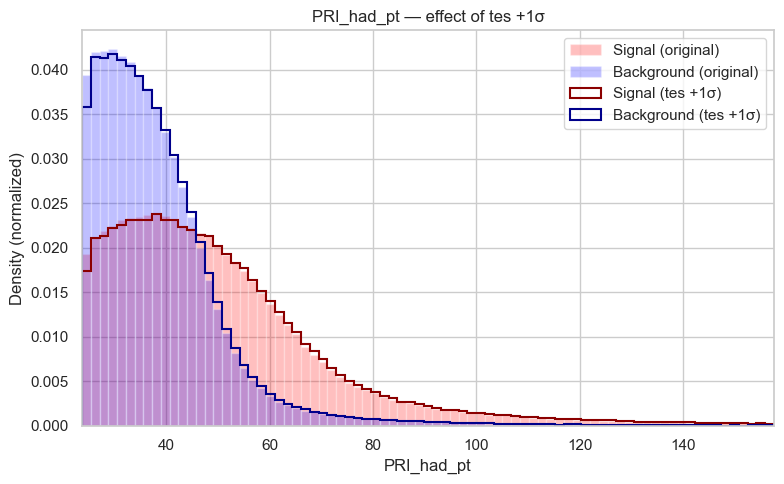

0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
0          47.221001
3          28.195000
4          31.306999
10         43.411999
11         41.036999
             ...    
1399986    44.304001
1399988    99.282997
1399991    63.943001
1399993    35.534000
1399998    74.473000
Name: PRI_had_pt, Length: 462981, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31.007000
1399996    35.183998
1399997    33.636002
1399999    35.353001
Name: PRI_had_pt, Length: 937019, dtype: float32
1          60.610001
2          42.337002
5          55.664001
6          45.139999
7          39.509998
             ...    
1399994    40.577000
1399995    31

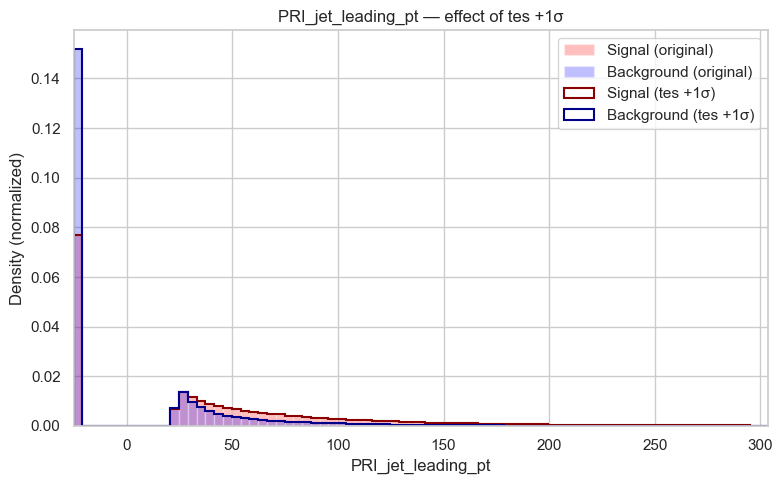

0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              ...    
1399994     23.239000
1399995     66.065002
1399996     24.084999
1399997     41.452999
1399999     55.109001
Name: PRI_jet_leading_pt, Length: 937019, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              .

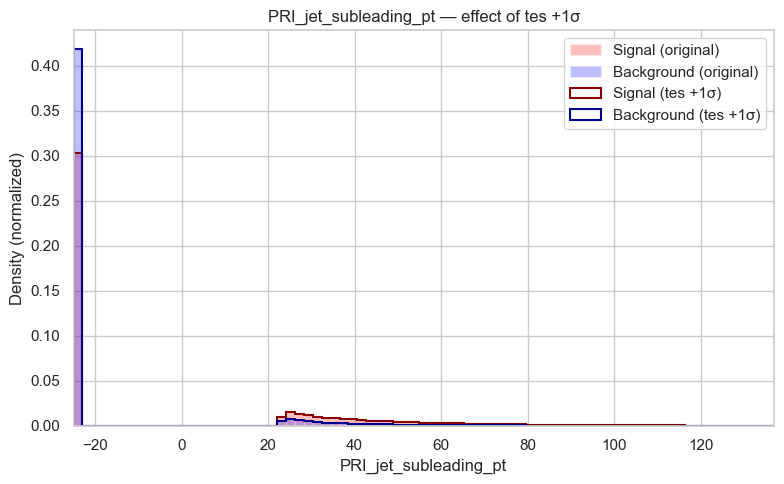

0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.000
1399997   -25.000
1399999   -25.000
Name: PRI_jet_subleading_pt, Length: 937019, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.00

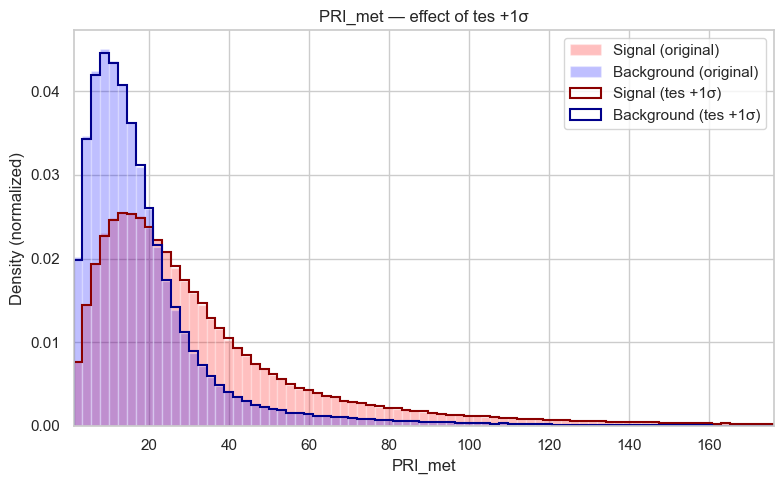

0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
0          19.486000
3          10.590000
4          37.752998
10         18.170000
11         24.399000
             ...    
1399986    17.384001
1399988    14.850000
1399991    17.245001
1399993    19.226000
1399998    24.837999
Name: PRI_met, Length: 462981, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1399996    25.952000
1399997    32.129002
1399999    45.842999
Name: PRI_met, Length: 937019, dtype: float32
1          53.745998
2          22.323000
5          49.227001
6           9.411000
7          27.565001
             ...    
1399994    22.902000
1399995    45.856998
1

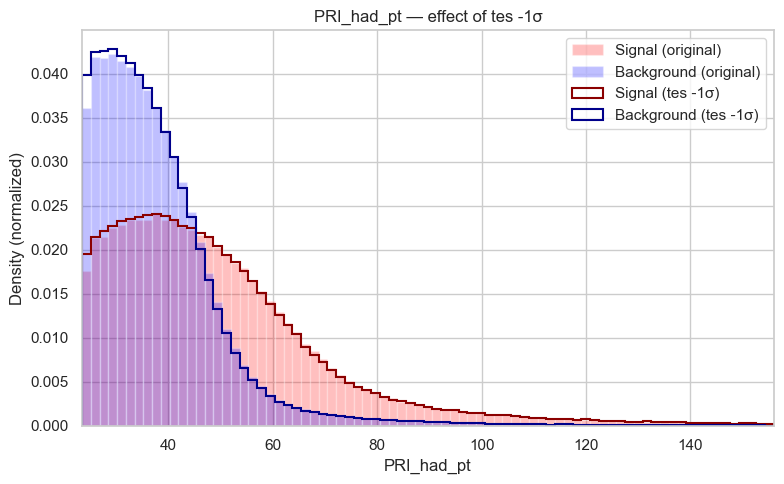

0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
0          46.285000
3          27.636999
4          30.687000
10         42.551998
11         40.224998
             ...    
1399986    43.425999
1399988    97.317001
1399991    62.676998
1399993    34.830002
1399998    72.999001
Name: PRI_had_pt, Length: 462981, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31.007000
1399996    35.183998
1399997    33.636002
1399999    35.353001
Name: PRI_had_pt, Length: 937019, dtype: float32
1          59.410000
2          41.499001
5          54.562000
6          44.245998
7          38.728001
             ...    
1399994    39.772999
1399995    30

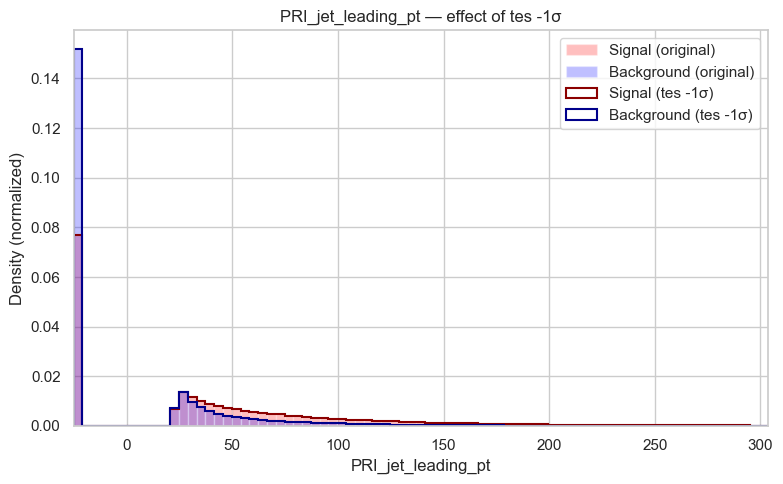

0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              ...    
1399994     23.239000
1399995     66.065002
1399996     24.084999
1399997     41.452999
1399999     55.109001
Name: PRI_jet_leading_pt, Length: 937019, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              .

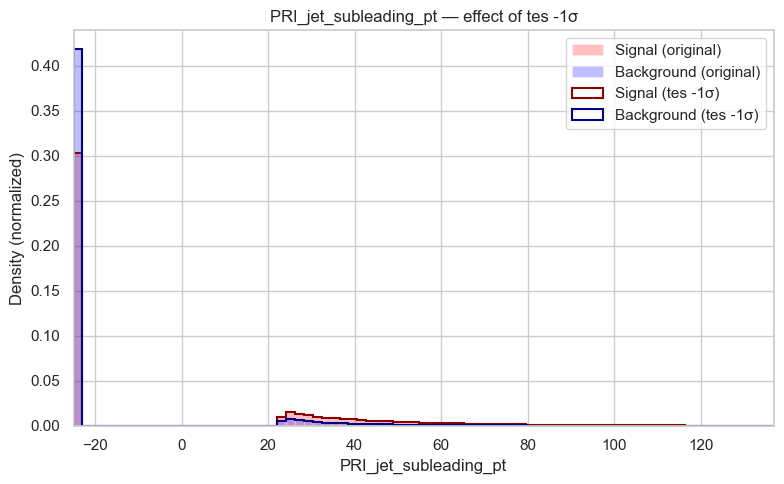

0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.000
1399997   -25.000
1399999   -25.000
Name: PRI_jet_subleading_pt, Length: 937019, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.00

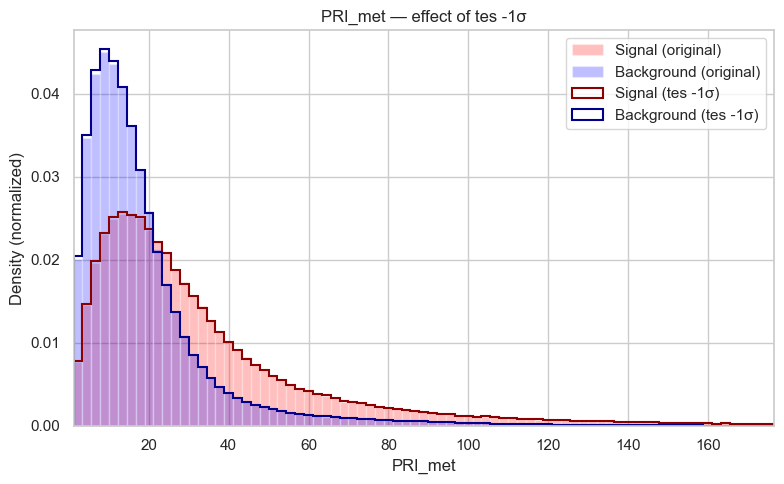

0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
0          20.409000
3          11.105000
4          38.373001
10         18.035999
11         25.162001
             ...    
1399986    18.261999
1399988    14.292000
1399991    16.139999
1399993    19.292999
1399998    25.642000
Name: PRI_met, Length: 462981, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1399996    25.952000
1399997    32.129002
1399999    45.842999
Name: PRI_met, Length: 937019, dtype: float32
1          54.716999
2          21.525999
5          49.712002
6           8.517000
7          27.157000
             ...    
1399994    22.382000
1399995    46.477001
1

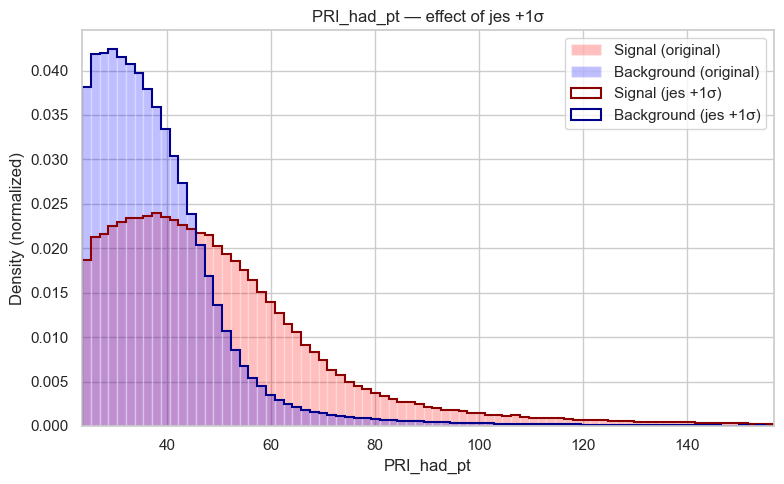

0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31.007000
1399996    35.183998
1399997    33.636002
1399999    35.353001
Name: PRI_had_pt, Length: 937019, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31

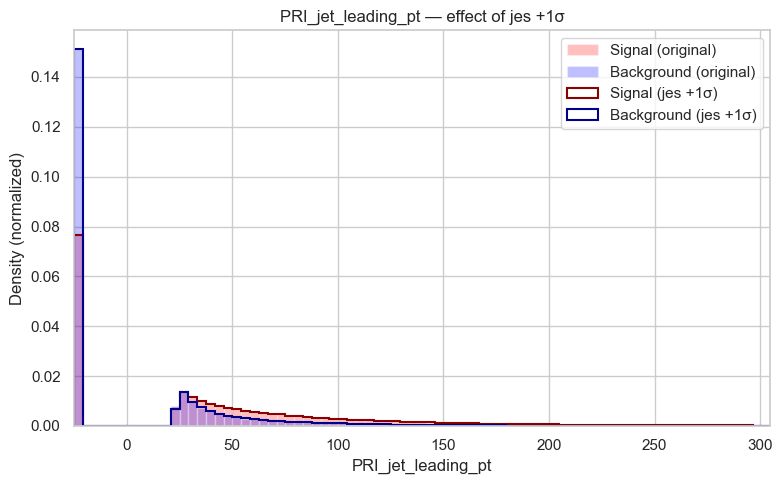

0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          73.813004
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    65.505997
1399991   -25.000000
1399993    47.452000
1399998    97.807999
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              ...    
1399994     23.239000
1399995     66.065002
1399996     24.084999
1399997     41.452999
1399999     55.109001
Name: PRI_jet_leading_pt, Length: 937019, dtype: float32
1          136.119003
2          -25.000000
5          138.214996
6          -25.000000
7          -25.000000
              .

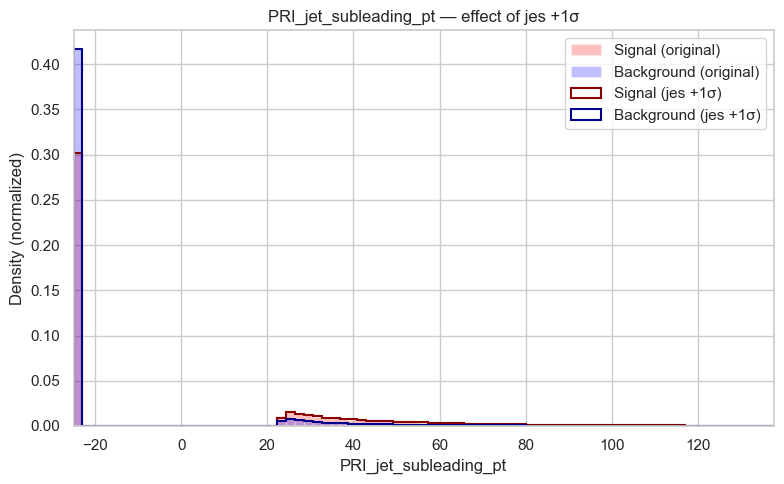

0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          31.587000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.516998
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.000
1399997   -25.000
1399999   -25.000
Name: PRI_jet_subleading_pt, Length: 937019, dtype: float32
1          50.169998
2         -25.000000
5         -25.000000
6         -25.000000
7         -25.000000
             ...    
1399994   -25.000000
1399995   -25

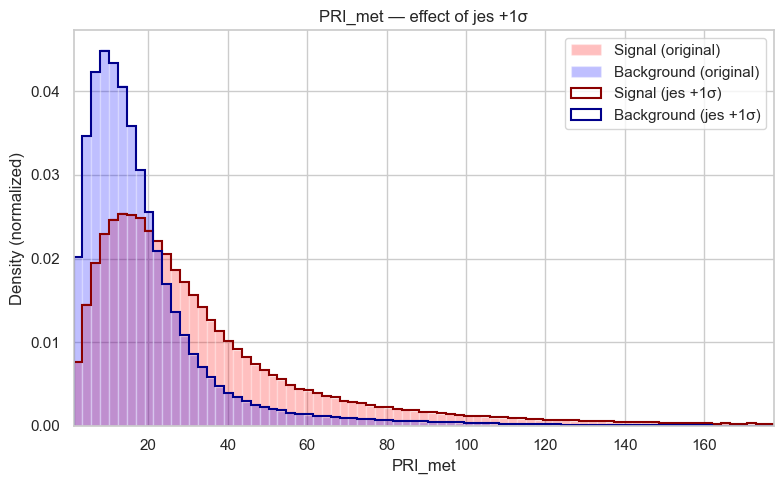

0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
0          19.947001
3          10.847000
4          38.862999
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.497000
1399991    16.690001
1399993    18.885000
1399998    26.195000
Name: PRI_met, Length: 462981, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1399996    25.952000
1399997    32.129002
1399999    45.842999
Name: PRI_met, Length: 937019, dtype: float32
1          55.537998
2          21.924000
5          50.681999
6           8.964000
7          27.358999
             ...    
1399994    22.768999
1399995    46.793999
1

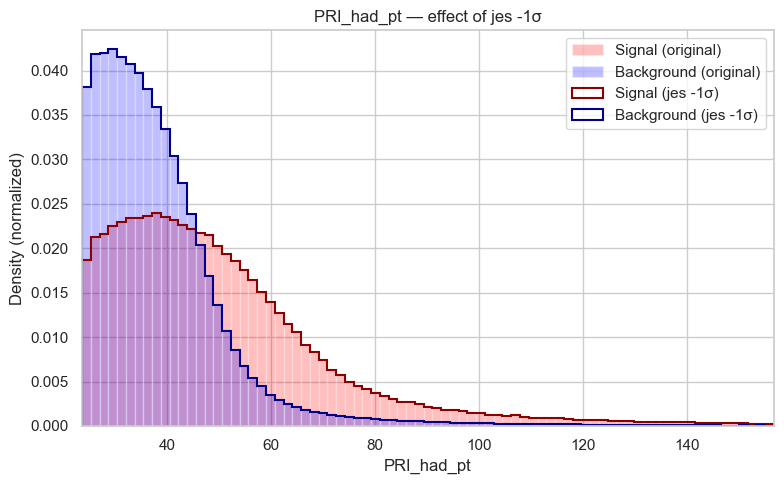

0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31.007000
1399996    35.183998
1399997    33.636002
1399999    35.353001
Name: PRI_had_pt, Length: 937019, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31

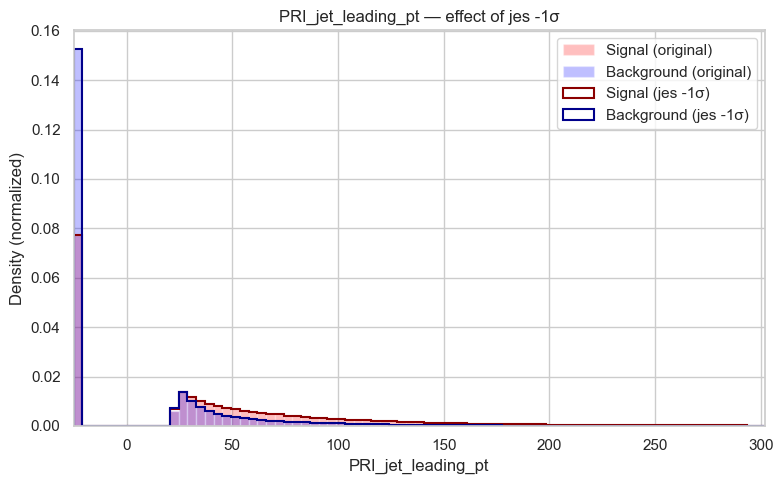

0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          72.350998
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.208000
1399991   -25.000000
1399993    46.512001
1399998    95.872002
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              ...    
1399994     23.239000
1399995     66.065002
1399996     24.084999
1399997     41.452999
1399999     55.109001
Name: PRI_jet_leading_pt, Length: 937019, dtype: float32
1          133.423004
2          -25.000000
5          135.479004
6          -25.000000
7          -25.000000
              .

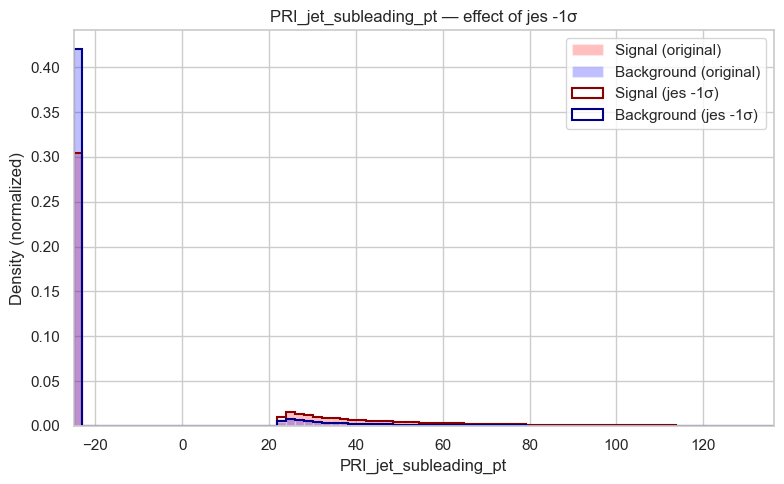

0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          30.961000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    32.853001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.000
1399997   -25.000
1399999   -25.000
Name: PRI_jet_subleading_pt, Length: 937019, dtype: float32
1          49.175999
2         -25.000000
5         -25.000000
6         -25.000000
7         -25.000000
             ...    
1399994   -25.000000
1399995   -25

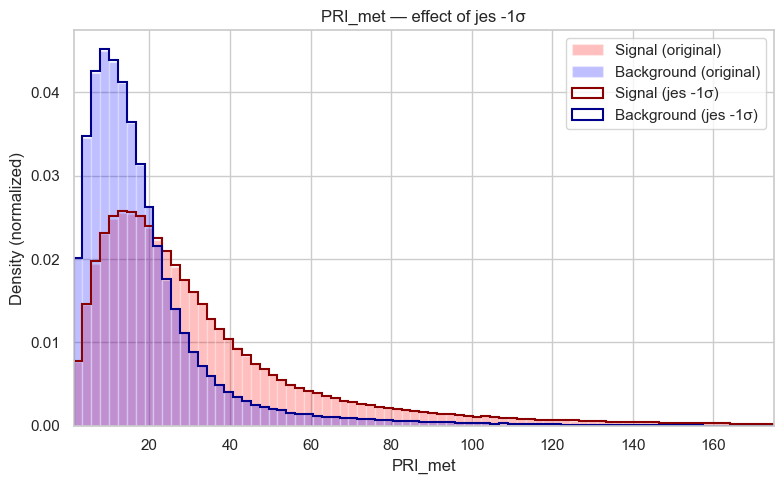

0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
0          19.947001
3          10.847000
4          37.266998
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.612000
1399991    16.690001
1399993    19.627001
1399998    24.268999
Name: PRI_met, Length: 462981, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1399996    25.952000
1399997    32.129002
1399999    45.842999
Name: PRI_met, Length: 937019, dtype: float32
1          52.923000
2          21.924000
5          48.259998
6           8.964000
7          27.358999
             ...    
1399994    22.513000
1399995    45.540001
1

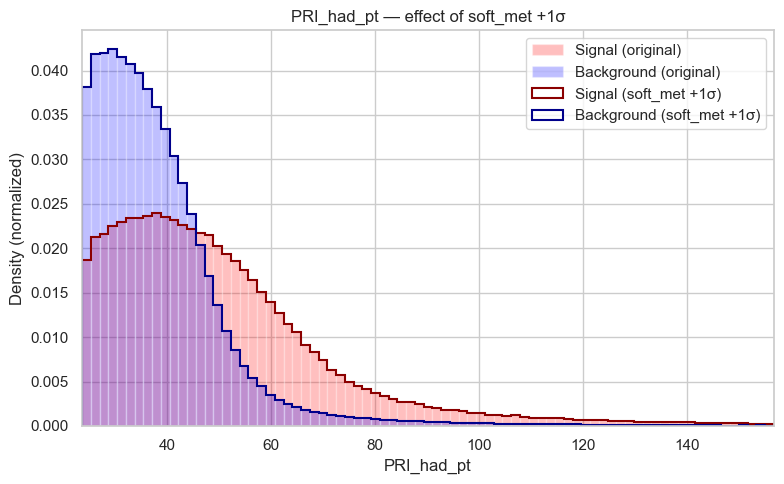

0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31.007000
1399996    35.183998
1399997    33.636002
1399999    35.353001
Name: PRI_had_pt, Length: 937019, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31

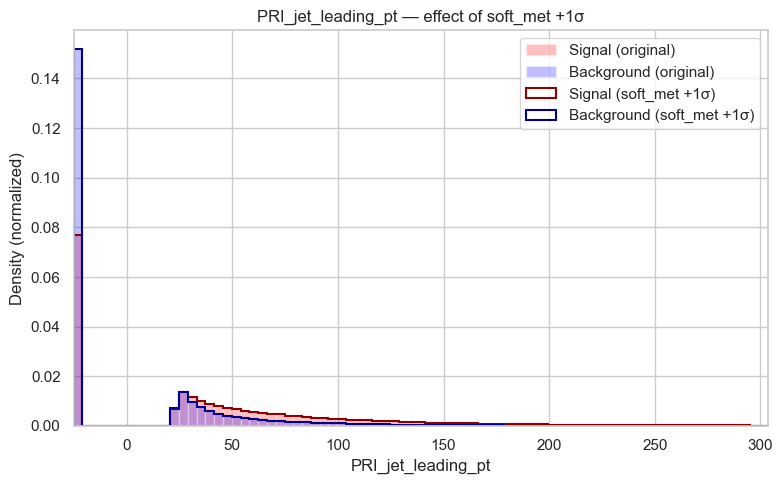

0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              ...    
1399994     23.239000
1399995     66.065002
1399996     24.084999
1399997     41.452999
1399999     55.109001
Name: PRI_jet_leading_pt, Length: 937019, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              .

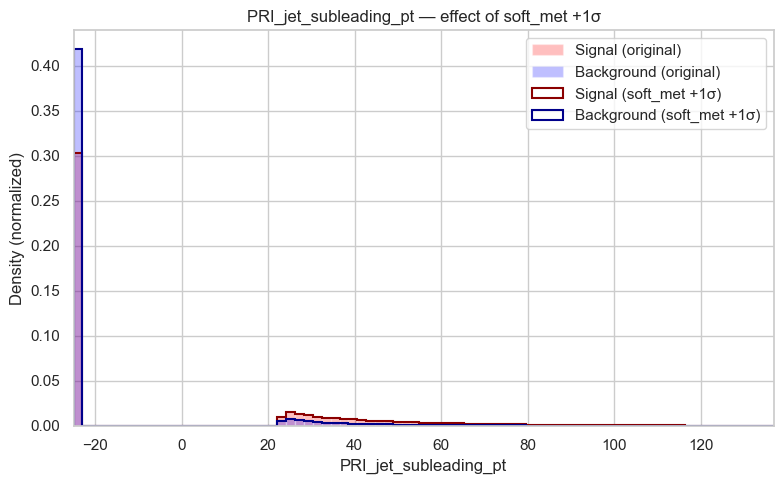

0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.000
1399997   -25.000
1399999   -25.000
Name: PRI_jet_subleading_pt, Length: 937019, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.00

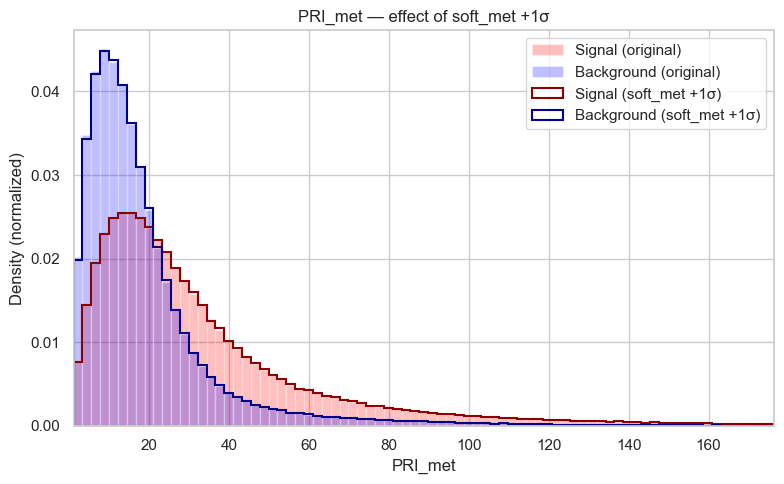

0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
0          19.834000
3          11.320000
4          38.993999
10         16.697001
11         24.444000
             ...    
1399986    19.363001
1399988    13.643000
1399991    16.677999
1399993    19.275000
1399998    24.806000
Name: PRI_met, Length: 462981, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1399996    25.952000
1399997    32.129002
1399999    45.842999
Name: PRI_met, Length: 937019, dtype: float32
1          55.161999
2          24.108000
5          50.599998
6           8.070000
7          25.294001
             ...    
1399994    23.487000
1399995    45.488998
1

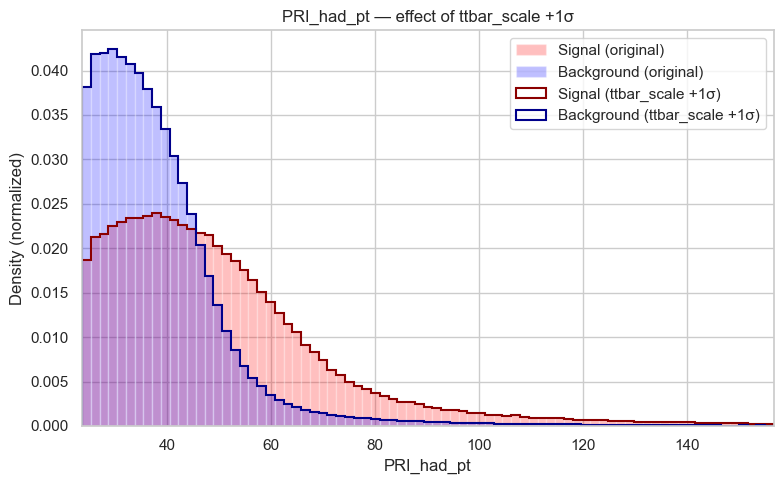

0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31.007000
1399996    35.183998
1399997    33.636002
1399999    35.353001
Name: PRI_had_pt, Length: 937019, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31

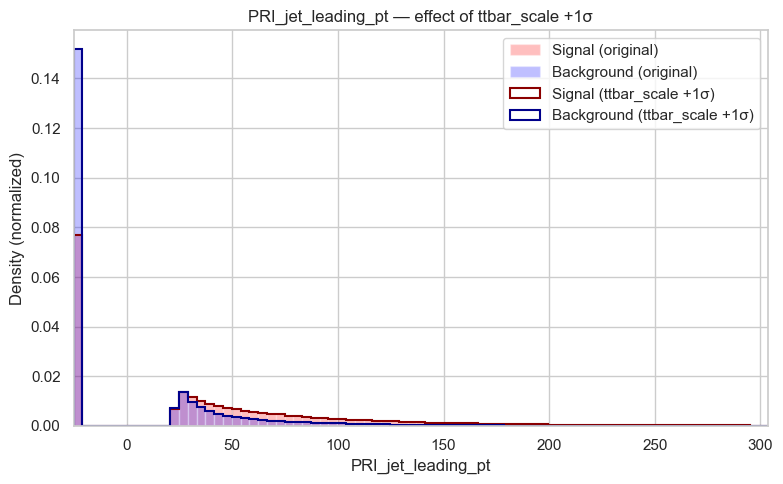

0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              ...    
1399994     23.239000
1399995     66.065002
1399996     24.084999
1399997     41.452999
1399999     55.109001
Name: PRI_jet_leading_pt, Length: 937019, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              .

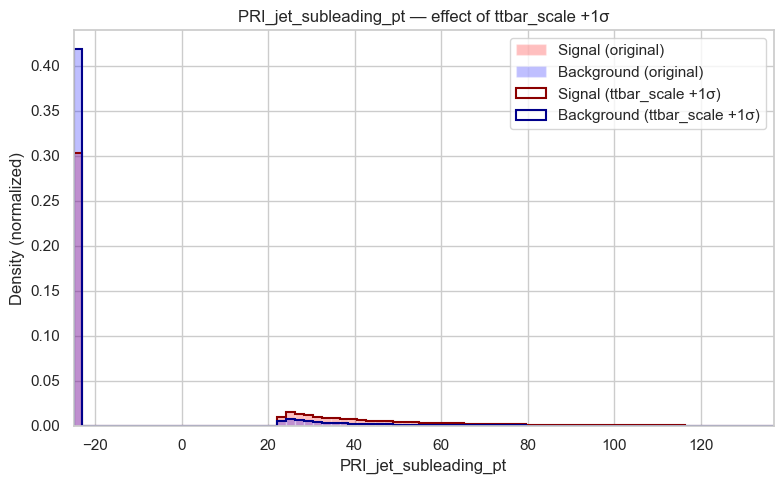

0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.000
1399997   -25.000
1399999   -25.000
Name: PRI_jet_subleading_pt, Length: 937019, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.00

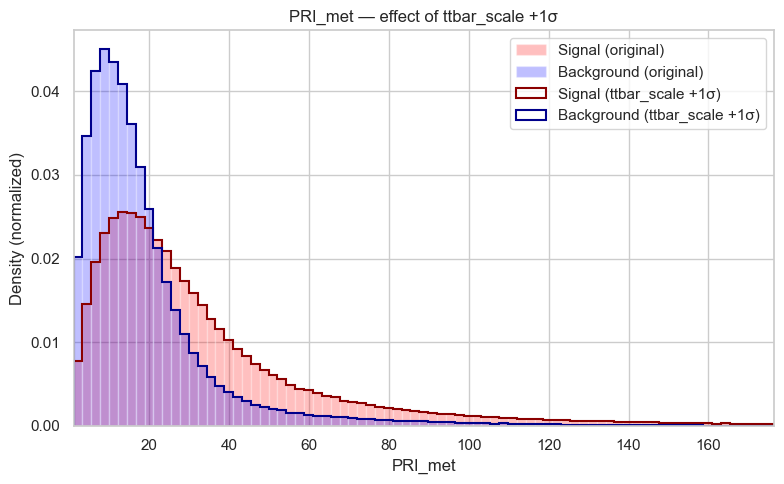

0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1399996    25.952000
1399997    32.129002
1399999    45.842999
Name: PRI_met, Length: 937019, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1

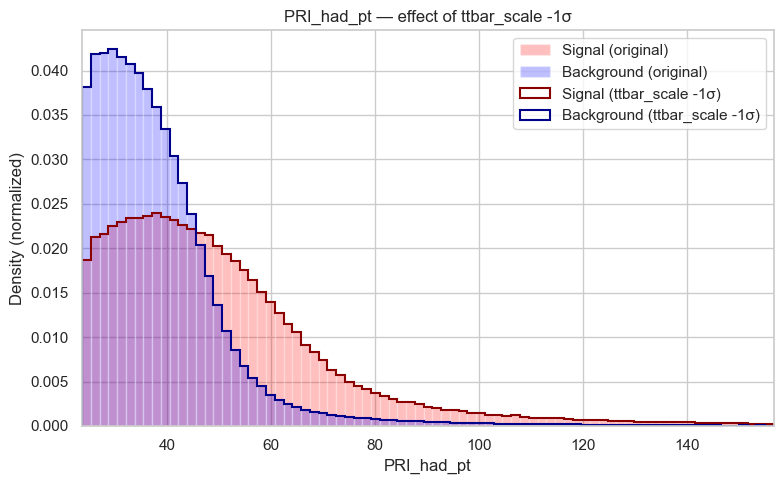

0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31.007000
1399996    35.183998
1399997    33.636002
1399999    35.353001
Name: PRI_had_pt, Length: 937019, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31

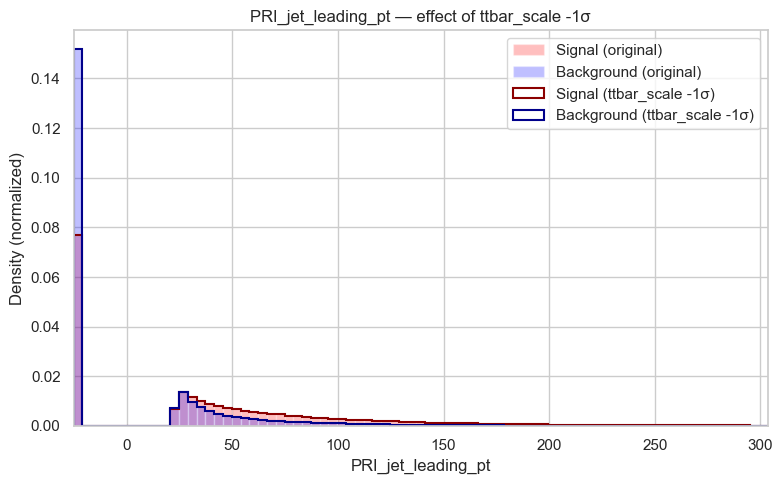

0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              ...    
1399994     23.239000
1399995     66.065002
1399996     24.084999
1399997     41.452999
1399999     55.109001
Name: PRI_jet_leading_pt, Length: 937019, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              .

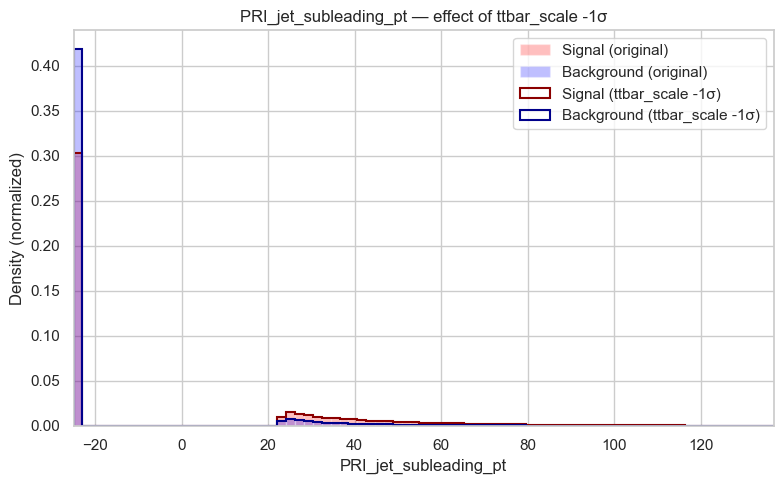

0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.000
1399997   -25.000
1399999   -25.000
Name: PRI_jet_subleading_pt, Length: 937019, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.00

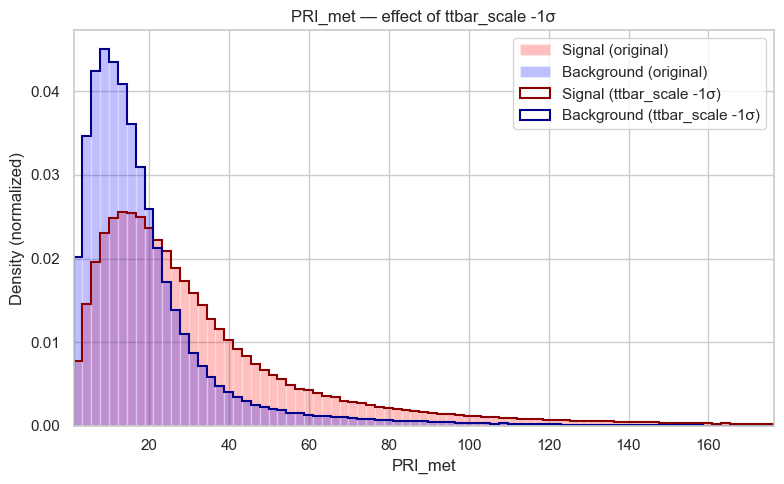

0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1399996    25.952000
1399997    32.129002
1399999    45.842999
Name: PRI_met, Length: 937019, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1

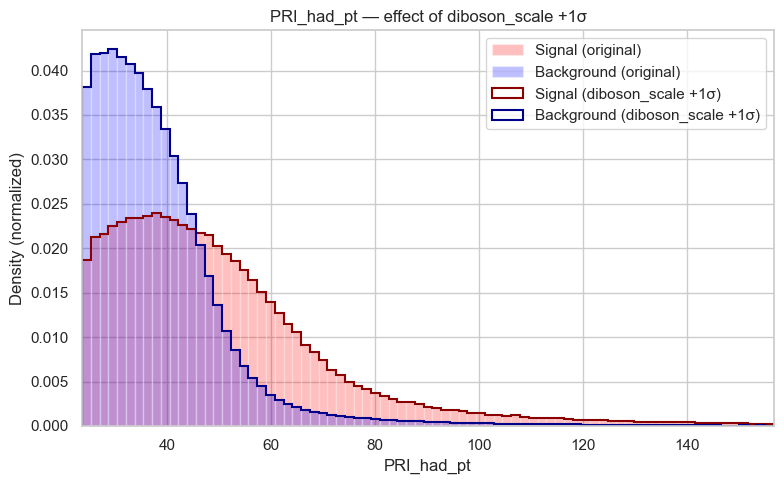

0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31.007000
1399996    35.183998
1399997    33.636002
1399999    35.353001
Name: PRI_had_pt, Length: 937019, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31

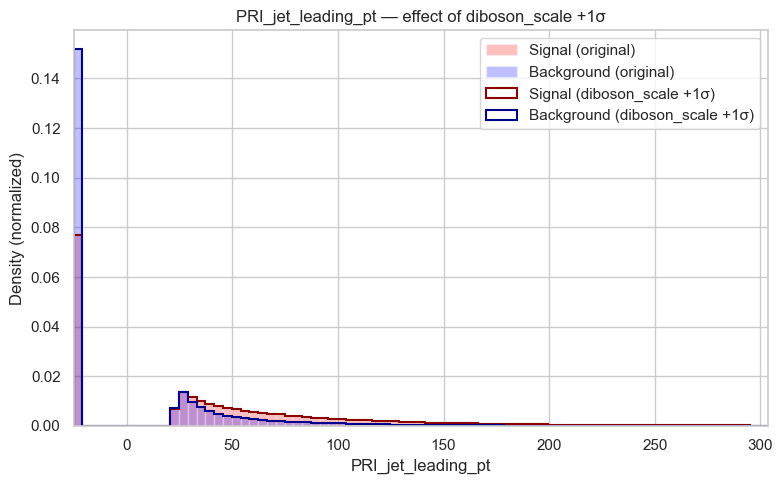

0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              ...    
1399994     23.239000
1399995     66.065002
1399996     24.084999
1399997     41.452999
1399999     55.109001
Name: PRI_jet_leading_pt, Length: 937019, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              .

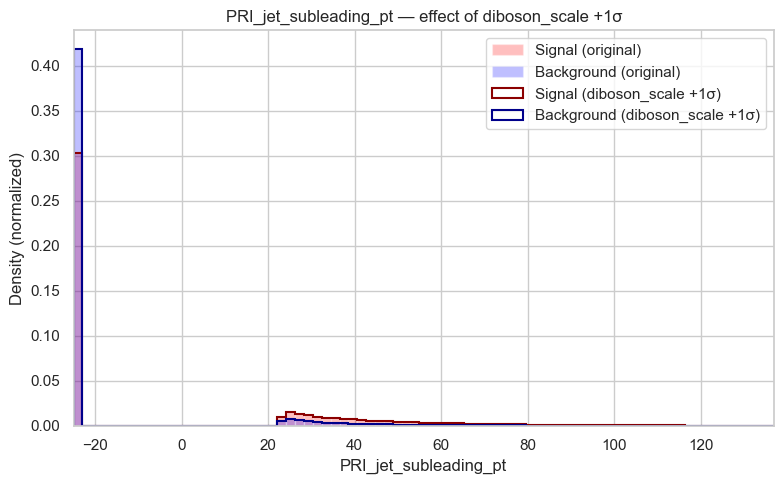

0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.000
1399997   -25.000
1399999   -25.000
Name: PRI_jet_subleading_pt, Length: 937019, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.00

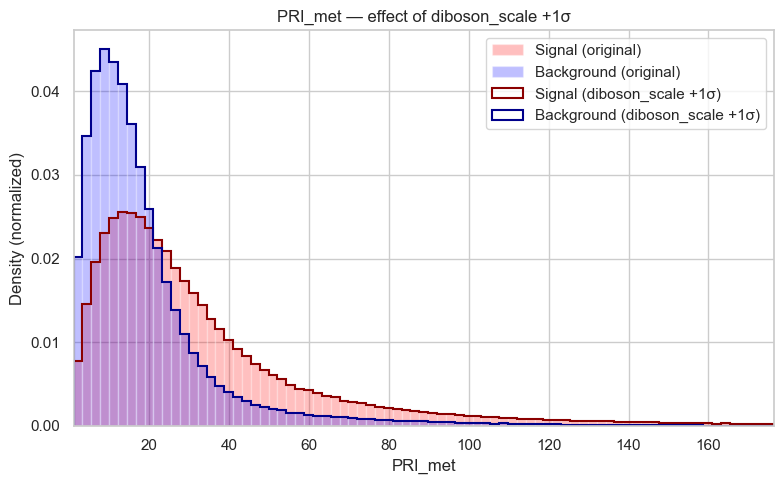

0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1399996    25.952000
1399997    32.129002
1399999    45.842999
Name: PRI_met, Length: 937019, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1

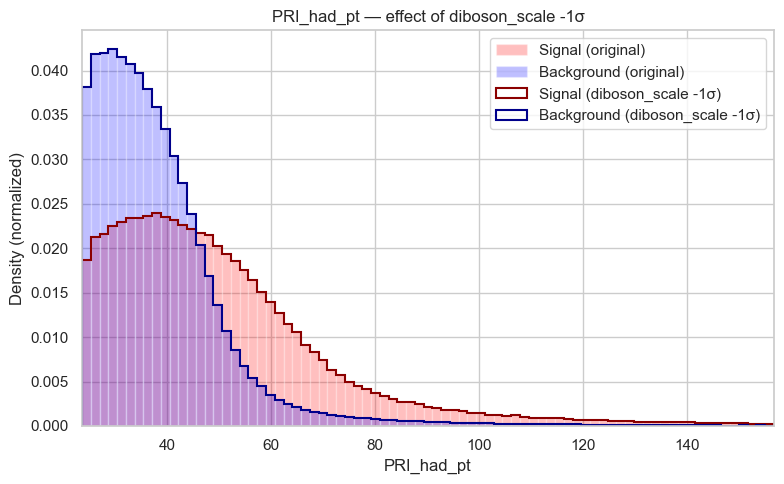

0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31.007000
1399996    35.183998
1399997    33.636002
1399999    35.353001
Name: PRI_had_pt, Length: 937019, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31

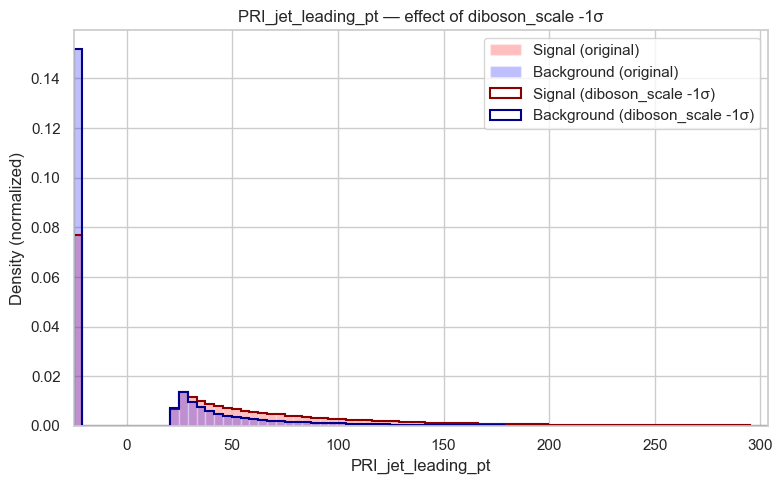

0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              ...    
1399994     23.239000
1399995     66.065002
1399996     24.084999
1399997     41.452999
1399999     55.109001
Name: PRI_jet_leading_pt, Length: 937019, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              .

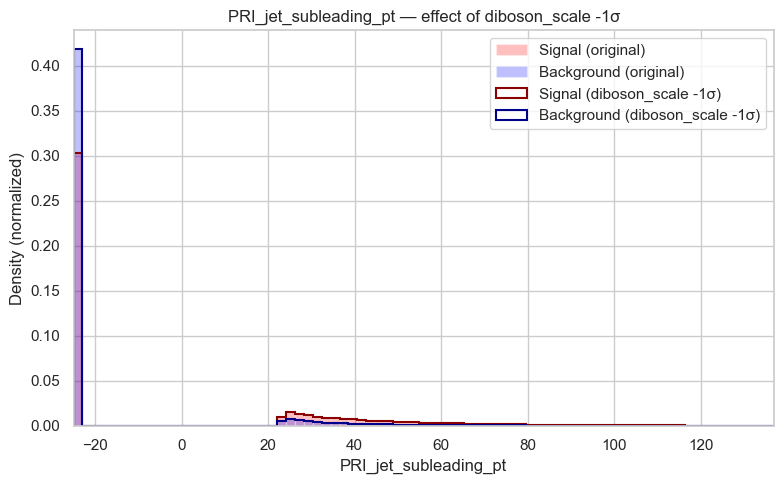

0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.000
1399997   -25.000
1399999   -25.000
Name: PRI_jet_subleading_pt, Length: 937019, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.00

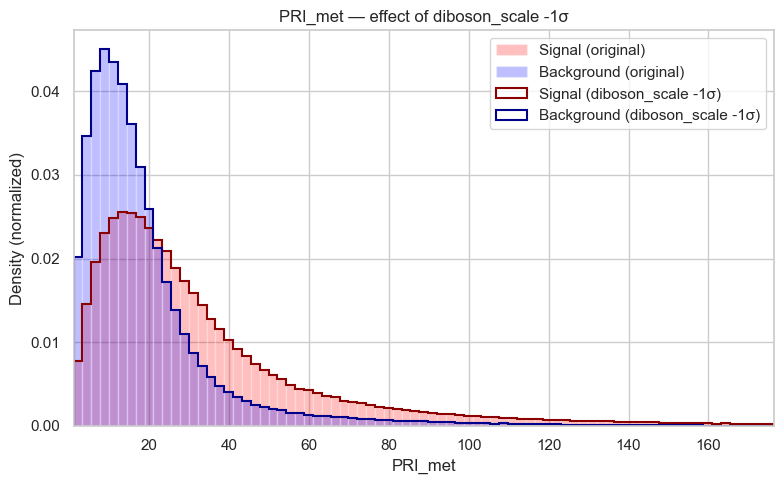

0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1399996    25.952000
1399997    32.129002
1399999    45.842999
Name: PRI_met, Length: 937019, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1

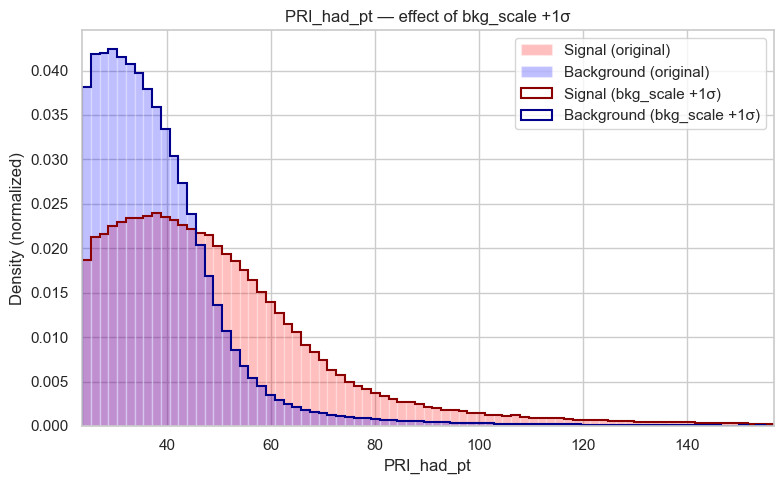

0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31.007000
1399996    35.183998
1399997    33.636002
1399999    35.353001
Name: PRI_had_pt, Length: 937019, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31

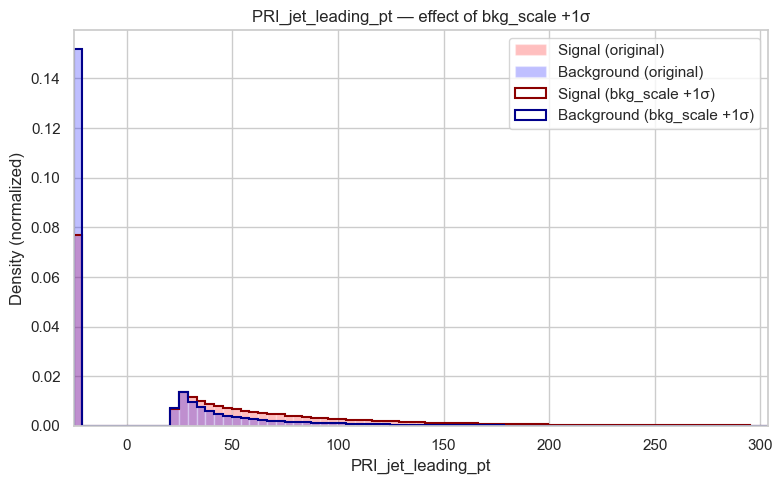

0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              ...    
1399994     23.239000
1399995     66.065002
1399996     24.084999
1399997     41.452999
1399999     55.109001
Name: PRI_jet_leading_pt, Length: 937019, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              .

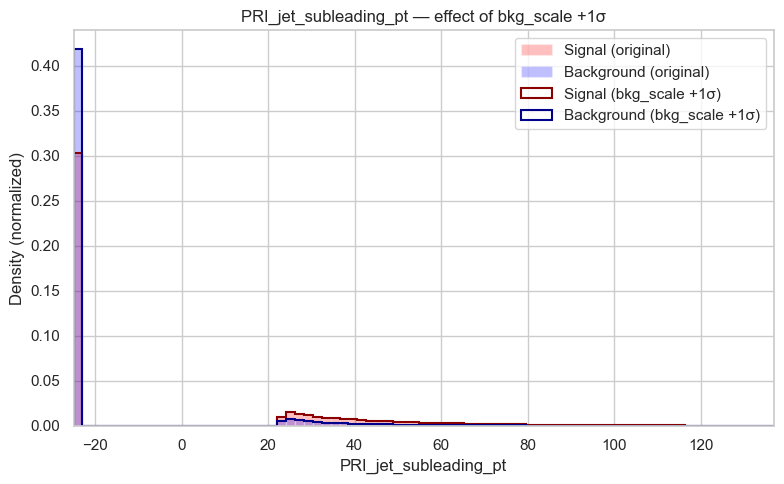

0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.000
1399997   -25.000
1399999   -25.000
Name: PRI_jet_subleading_pt, Length: 937019, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.00

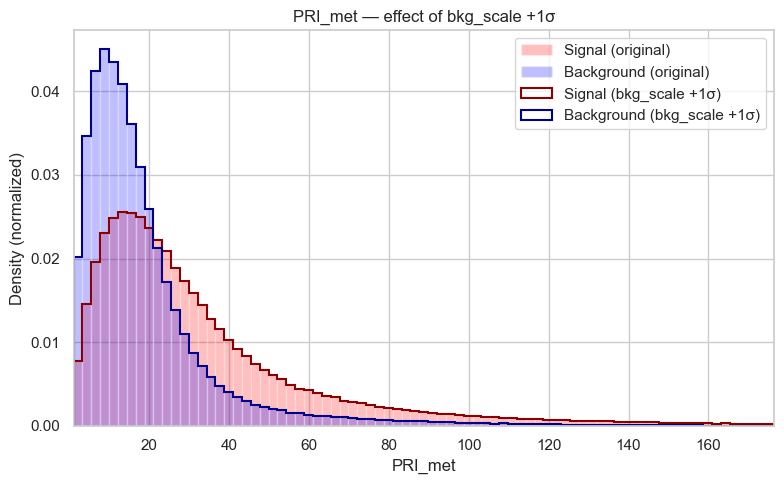

0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1399996    25.952000
1399997    32.129002
1399999    45.842999
Name: PRI_met, Length: 937019, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1

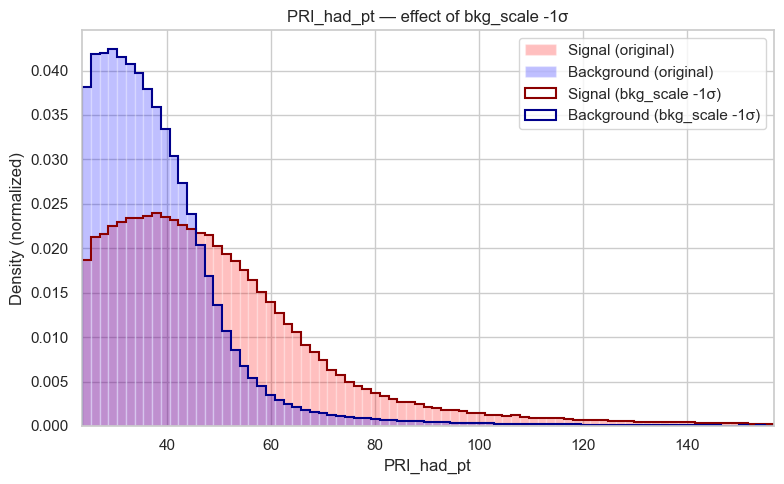

0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
0          46.752998
3          27.916000
4          30.997000
10         42.981998
11         40.631001
             ...    
1399986    43.865002
1399988    98.300003
1399991    63.310001
1399993    35.181999
1399998    73.736000
Name: PRI_had_pt, Length: 462981, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31.007000
1399996    35.183998
1399997    33.636002
1399999    35.353001
Name: PRI_had_pt, Length: 937019, dtype: float32
1          60.009998
2          41.917999
5          55.112999
6          44.693001
7          39.118999
             ...    
1399994    40.174999
1399995    31

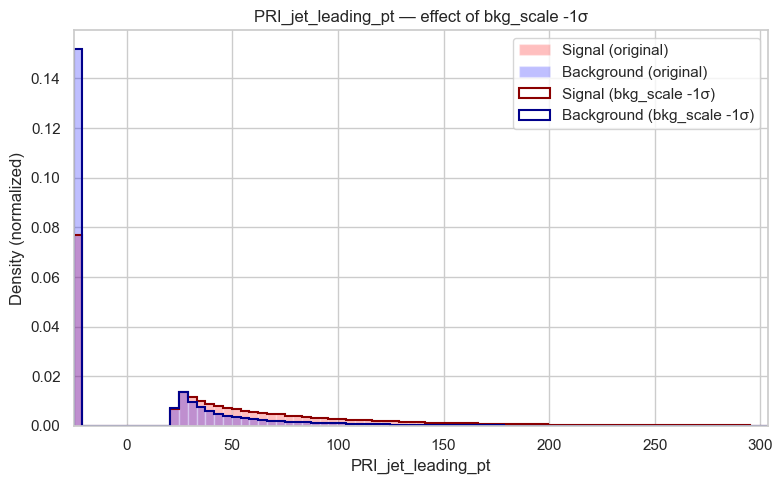

0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          73.082001
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988    64.857002
1399991   -25.000000
1399993    46.981998
1399998    96.839996
Name: PRI_jet_leading_pt, Length: 462981, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              ...    
1399994     23.239000
1399995     66.065002
1399996     24.084999
1399997     41.452999
1399999     55.109001
Name: PRI_jet_leading_pt, Length: 937019, dtype: float32
1          134.770996
2          -25.000000
5          136.847000
6          -25.000000
7          -25.000000
              .

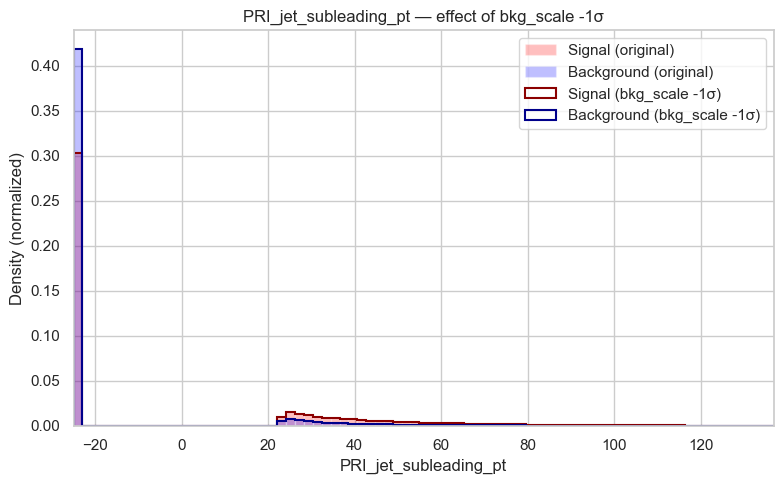

0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
0         -25.000000
3         -25.000000
4          31.274000
10        -25.000000
11        -25.000000
             ...    
1399986   -25.000000
1399988   -25.000000
1399991   -25.000000
1399993    33.185001
1399998   -25.000000
Name: PRI_jet_subleading_pt, Length: 462981, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.000
1399997   -25.000
1399999   -25.000
Name: PRI_jet_subleading_pt, Length: 937019, dtype: float32
1          49.673
2         -25.000
5         -25.000
6         -25.000
7         -25.000
            ...  
1399994   -25.000
1399995   -25.000
1399996   -25.00

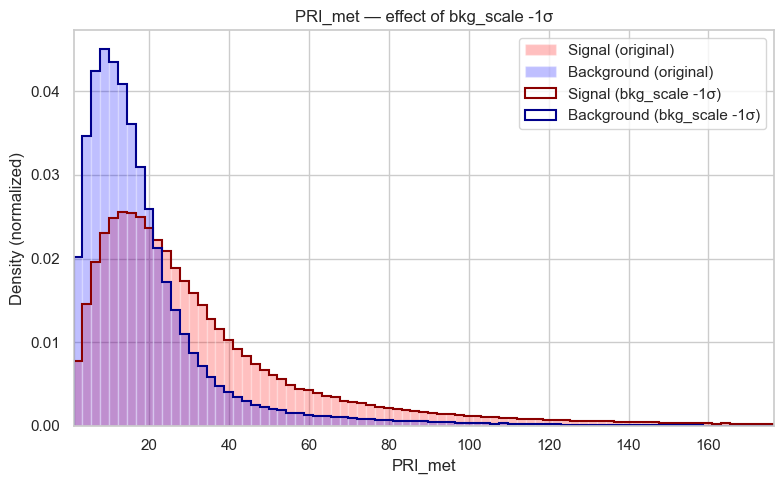

0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
0          19.947001
3          10.847000
4          38.063000
10         18.098000
11         24.780001
             ...    
1399986    17.823000
1399988    14.540000
1399991    16.690001
1399993    19.256001
1399998    25.232000
Name: PRI_met, Length: 462981, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1399996    25.952000
1399997    32.129002
1399999    45.842999
Name: PRI_met, Length: 937019, dtype: float32
1          54.230000
2          21.924000
5          49.466999
6           8.964000
7          27.358999
             ...    
1399994    22.639999
1399995    46.167000
1

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from HiggsML.datasets import download_dataset
from HiggsML.systematics import systematics

# === Load dataset ===
data = download_dataset("blackSwan_data")
data.load_train_set()
original_df = data.get_train_set()
original_weights = original_df["weights"]
original_labels = original_df["labels"]

# === Define features to visualize ===
features = ["PRI_had_pt", "PRI_jet_leading_pt", "PRI_jet_subleading_pt", "PRI_met"]

# === Systematic bias config ===
biases = {
    "tes": {"mean": 1.0, "sigma": 0.01},
    "jes": {"mean": 1.0, "sigma": 0.01},
    "soft_met": {"mean": 0.0, "sigma": 1.0},  # log-normal
    "ttbar_scale": {"mean": 1.0, "sigma": 0.02},
    "diboson_scale": {"mean": 1.0, "sigma": 0.25},
    "bkg_scale": {"mean": 1.0, "sigma": 0.001}
}

# === Chi-squared test helper ===
def chi2_stat(observed, expected):
    mask = expected > 0
    return np.sum((observed[mask] - expected[mask])**2 / expected[mask])

# === Main loop ===
for bias_name, bias_info in biases.items():
    for shift in ["+1σ", "-1σ"]:
        if bias_name == "soft_met" and shift == "-1σ":
            continue

        kwargs = {
            "tes": 1.0, "jes": 1.0, "soft_met": 0.0,
            "ttbar_scale": 1.0, "diboson_scale": 1.0, "bkg_scale": 1.0
        }
        value = bias_info["mean"] + bias_info["sigma"] if shift == "+1σ" else bias_info["mean"] - bias_info["sigma"]
        kwargs[bias_name] = value

        biased_result = systematics(
            {"data": original_df.copy(), "weights": original_weights.copy()},
            **kwargs, dopostprocess=False
        )
        biased_df = biased_result["data"]
        biased_weights = biased_result["weights"]
        biased_labels = biased_df["labels"]

        for feat in features:
            if feat not in original_df.columns or feat not in biased_df.columns:
                continue

            # Define common bins based on all data
            all_vals = pd.concat([original_df[feat], biased_df[feat]]).dropna()
            x_min, x_max = np.percentile(all_vals, [0.5, 99.5])
            bins = np.linspace(x_min, x_max, 80)

            # Histogram counts (not density) for chi-squared test
            orig_sig, _ = np.histogram(original_df[feat][original_labels == 1], bins=bins,
                                       weights=original_weights[original_labels == 1])
            bias_sig, _ = np.histogram(biased_df[feat][biased_labels == 1], bins=bins,
                                       weights=biased_weights[biased_labels == 1])

            orig_bkg, _ = np.histogram(original_df[feat][original_labels == 0], bins=bins,
                                       weights=original_weights[original_labels == 0])
            bias_bkg, _ = np.histogram(biased_df[feat][biased_labels == 0], bins=bins,
                                       weights=biased_weights[biased_labels == 0])

            # Chi-squared statistics
            chi2_sig = chi2_stat(bias_sig, orig_sig)
            chi2_bkg = chi2_stat(bias_bkg, orig_bkg)

            # Plot
            plt.figure(figsize=(8, 5))

            plt.hist(original_df[feat][original_labels == 1], bins=bins, weights=original_weights[original_labels == 1],
                     label="Signal (original)", color="red", alpha=0.25, density=True)
            plt.hist(original_df[feat][original_labels == 0], bins=bins, weights=original_weights[original_labels == 0],
                     label="Background (original)", color="blue", alpha=0.25, density=True)

            plt.hist(biased_df[feat][biased_labels == 1], bins=bins, weights=biased_weights[biased_labels == 1],
                     label=f"Signal ({bias_name} {shift})", histtype="step", color="darkred", linewidth=1.5, density=True)
            plt.hist(biased_df[feat][biased_labels == 0], bins=bins, weights=biased_weights[biased_labels == 0],
                     label=f"Background ({bias_name} {shift})", histtype="step", color="darkblue", linewidth=1.5, density=True)

            plt.xlim(x_min, x_max)
            plt.title(f"{feat} — effect of {bias_name} {shift}")
            plt.xlabel(feat)
            plt.ylabel("Density (normalized)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            print(original_df[feat][original_labels == 1])
            print(biased_df[feat][biased_labels == 1])
            print(original_df[feat][original_labels == 0])
            print(biased_df[feat][biased_labels == 0])
            print(biased_weights.sum())
            print(original_weights.sum())
            print(f"[{feat}] {bias_name} {shift} — χ² (signal): {chi2_sig:.2f}, χ² (background): {chi2_bkg:.2f}")


In [24]:
feat = "PRI_had_pt"  # 或 "PRI_jet_leading_pt", "PRI_had_pt" 等
print("Original mean:", original_df[feat].mean())
print("Biased mean:", biased_df[feat].mean())

Original mean: 43.10186
Biased mean: 43.10186


In [25]:
import inspect
from HiggsML import systematics
print(inspect.getsource(systematics.systematics))

def systematics(
    data_set=None,
    tes=1.0,
    jes=1.0,
    soft_met=0.0,
    seed=31415,
    ttbar_scale=None,
    diboson_scale=None,
    bkg_scale=None,
    dopostprocess=True,
):
    """
    Apply systematics to the dataset

    Args:
        * data_set (dict)/(df): The dataset to apply systematics to
        * tes (float): The factor applied to PRI_had_pt
        * jes (float): The factor applied to all jet pt
        * soft_met (float): The additional soft MET energy
        * seed (int): The random seed
        * ttbar_scale (float): The scaling factor for ttbar background
        * diboson_scale (float): The scaling factor for diboson background
        * bkg_scale (float): The scaling factor for other backgrounds

    Returns:
        dict: The dataset with applied systematics
    """
    if isinstance(data_set, pd.DataFrame):
        data_df = data_set.copy()
        data_type = "df"
    elif isinstance(data_set, dict):
        if "data" not in data_set.keys():
        

In [9]:
import sys
import os
import importlib
sys.path.append(os.getcwd())
import sample_code_submission.feature_analysis as fa
importlib.reload(fa)
 
print("Top 10 minimal dependent features:", fa.compute_feature_importance(data_set))

ModuleNotFoundError: No module named 'tensorflow'

### Test Settings
The Test setting sets the test conditions in ingestion.
This includes what systematics you want and how many psuedo experiments you want. 

In [ ]:
TEST_SETTINGS = {
    "systematics": {  # Systematics to use
        "tes": False,  # tau energy scale
        "jes": False,  # jet energy scale
        "soft_met": False,  # soft term in MET
        "ttbar_scale": False,  # W boson scale factor
        "diboson_scale": False,  # Diboson scale factor
        "bkg_scale": False,  # Background scale factor
    },
    "num_pseudo_experiments": 25,  # Number of pseudo-experiments to run per set
    "num_of_sets": 25,  # Number of sets of pseudo-experiments to run
}

RANDOM_SEED = 42

In [7]:
test_settings = TEST_SETTINGS.copy()

random_state = np.random.RandomState(RANDOM_SEED)
test_settings["ground_truth_mus"] = (
    random_state.uniform(0.1, 3, test_settings["num_of_sets"])
).tolist()

random_settings_file = os.path.join(output_dir, "test_settings.json")
with open(random_settings_file, "w") as f:
    json.dump(test_settings, f)

NameError: name 'np' is not defined

### Ingestion



In [18]:
from HiggsML.ingestion import Ingestion

ingestion = Ingestion(data)

In [19]:
# initialize submission
ingestion.init_submission(Model)

2025-05-29 12:09:09,590 - HiggsML.ingestion    - INFO     - Initializing Submmited Model
2025-05-29 12:09:09,592 - HiggsML.datasets     - INFO     - Selected train size: 5000
2025-05-29 12:09:09,936 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-05-29 12:09:09,948 - HiggsML.datasets     - INFO     - Selected train size: 5000


Training Data:  (5000, 28)
Training Labels:  (5000,)
Training Weights:  (5000,)
sum_signal_weights:  681.679730244239
sum_bkg_weights:  105037.32026975573


2025-05-29 12:09:10,297 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-05-29 12:09:10,312 - HiggsML.datasets     - INFO     - Selected train size: 5000



Valid Data:  (5000, 28)
Valid Labels:  (5000,)
Valid Weights:  (5000,)
sum_signal_weights:  671.3365715098221
sum_bkg_weights:  105047.66342849021


2025-05-29 12:09:10,657 - HiggsML.datasets     - INFO     - Data loaded successfully



Holdout Data:  (5000, 28)
Holdout Labels:  (5000,)
Holdout Weights:  (5000,)
sum_signal_weights:  648.5987569269887
sum_bkg_weights:  105070.40124307296
 
 
Training Data:  (5000, 28)
 Model is Sample Model


2025-05-29 12:09:10,702 - HiggsML.ingestion    - INFO     - Calling fit method of submitted model


score shape before threshold (4574,)
score shape after threshold (4574,)
saved_info {'beta': np.float64(94628.01905013468), 'gamma': np.float64(612.6940988245049), 'tes_fit': <function tes_fitter.<locals>.fit_function at 0x0000027E041FAA20>, 'jes_fit': <function jes_fitter.<locals>.fit_function at 0x0000027E0D185580>}
Train Results: 
	 mu_hat  :  1.0455462838324419
	 del_mu_stat  :  0.5036949792522856
	 del_mu_sys  :  0.0
	 del_mu_tot  :  0.5036949792522856
Holdout Results: 
	 mu_hat  :  0.9999999999999989
	 del_mu_stat  :  0.5036949792522856
	 del_mu_sys  :  0.0
	 del_mu_tot  :  0.5036949792522856
Valid Results: 
	 mu_hat  :  0.5568371306481116
	 del_mu_stat  :  0.5036949792522856
	 del_mu_sys  :  0.0
	 del_mu_tot  :  0.5036949792522856
[*] --- score histogram


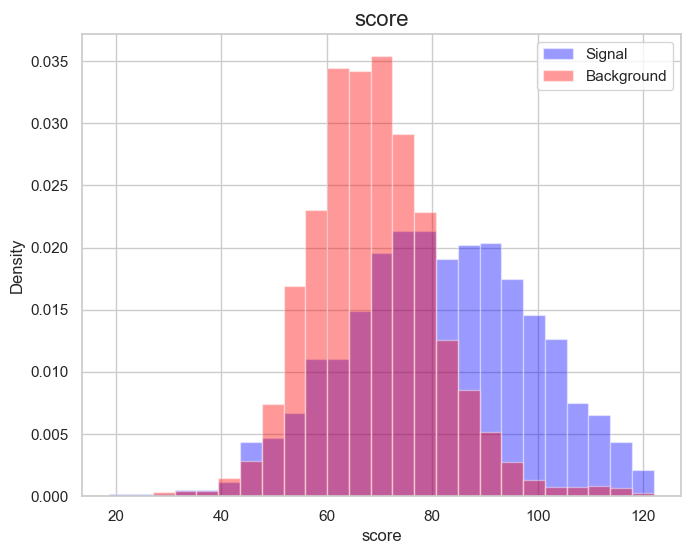

keys ['diboson' 'htautau' 'ttbar' 'ztautau']
keys 2 dict_keys(['diboson', 'htautau', 'ttbar', 'ztautau'])
htautau (30,)


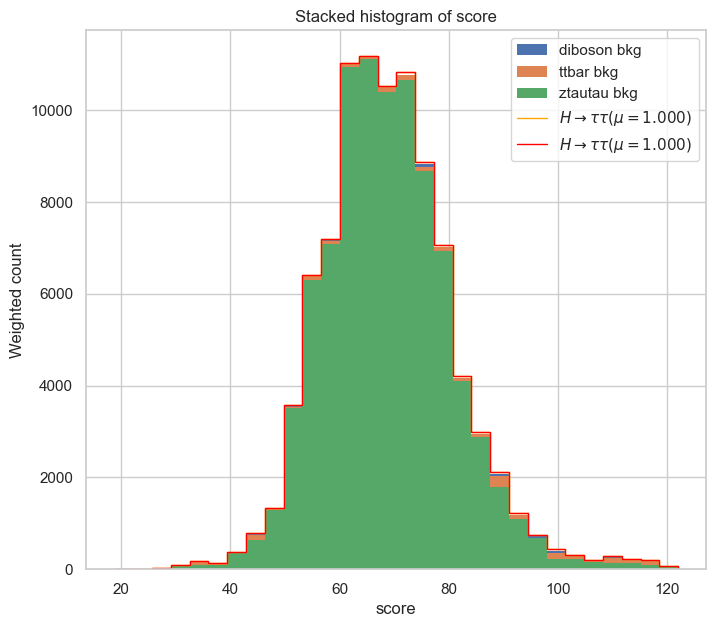

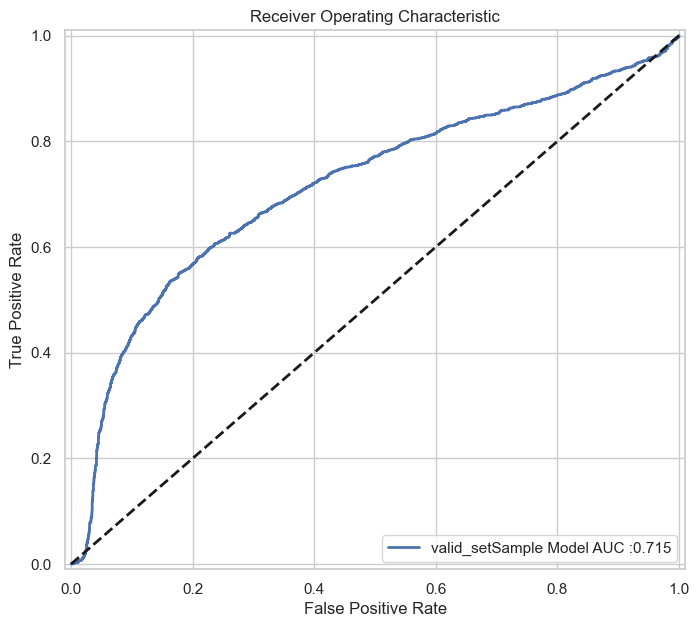

In [20]:
# fit submission
ingestion.fit_submission()

In [21]:
# load test set
data.load_test_set()

2025-05-29 12:09:12,382 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-05-29 12:09:12,665 - HiggsML.datasets     - INFO     - Test data loaded successfully


In [22]:
# predict submission
ingestion.predict_submission(test_settings)

2025-05-29 12:09:12,686 - HiggsML.ingestion    - INFO     - Calling predict method of submitted model with seed: 31415


Test Results:  {'mu_hat': np.float64(2.128274047958182), 'del_mu_stat': np.float64(0.5036949792522856), 'del_mu_sys': np.float64(0.0), 'del_mu_tot': np.float64(0.5036949792522856)}
Test Results:  {'mu_hat': np.float64(0.9058043009229042), 'del_mu_stat': np.float64(0.5036949792522856), 'del_mu_sys': np.float64(0.0), 'del_mu_tot': np.float64(0.5036949792522856)}
Test Results:  {'mu_hat': np.float64(2.890481487030912), 'del_mu_stat': np.float64(0.5036949792522856), 'del_mu_sys': np.float64(0.0), 'del_mu_tot': np.float64(0.5036949792522856)}
Test Results:  {'mu_hat': np.float64(1.8736608563193258), 'del_mu_stat': np.float64(0.5036949792522856), 'del_mu_sys': np.float64(0.0), 'del_mu_tot': np.float64(0.5036949792522856)}
Test Results:  {'mu_hat': np.float64(1.0690178853067864), 'del_mu_stat': np.float64(0.5036949792522856), 'del_mu_sys': np.float64(0.0), 'del_mu_tot': np.float64(0.5036949792522856)}
Test Results:  {'mu_hat': np.float64(3.7848919294545866), 'del_mu_stat': np.float64(0.503694

In [23]:
ingestion.process_results_dict()

In [24]:
# save result
ingestion.save_result(output_dir)

## Score
1. Compute Scores
2. Visualize Scores


In [25]:
from HiggsML.score import Scoring

In [26]:
# Initialize Score
score = Scoring()

In [27]:
print(output_dir)
score.load_ingestion_results(prediction_dir=output_dir, score_dir=output_dir)

d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission


2025-05-29 12:11:49,590 - HiggsML.score        - INFO     - Read ingestion results from d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission


2025-05-29 12:11:49,601 - HiggsML.score        - INFO     - Computing scores
c:\Users\Ragansu_User\AppData\Local\Programs\Python\Python313\Lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\Ragansu_User\AppData\Local\Programs\Python\Python313\Lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\Ragansu_User\AppData\Local\Programs\Python\Python313\Lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.1

[✔]


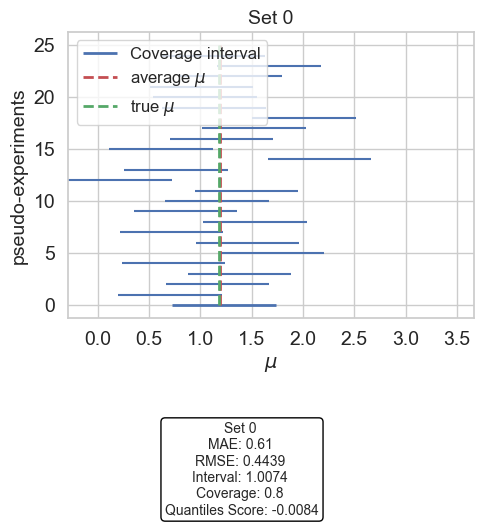

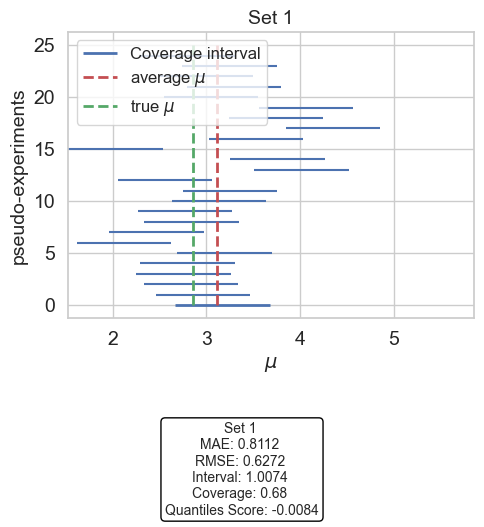

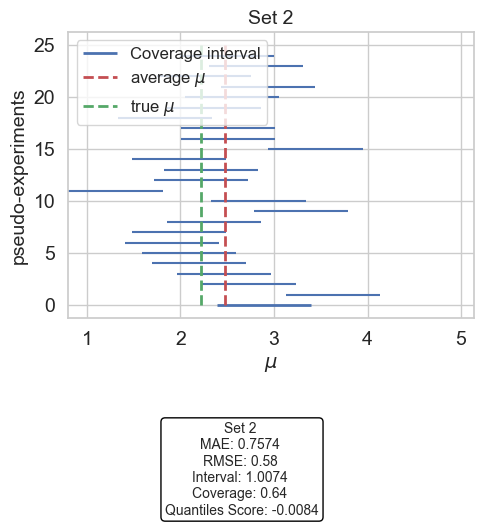

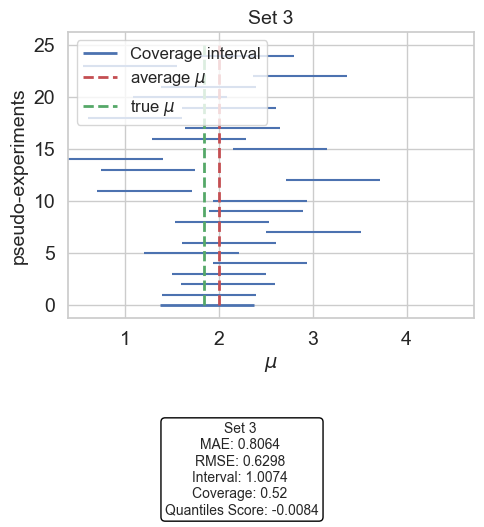

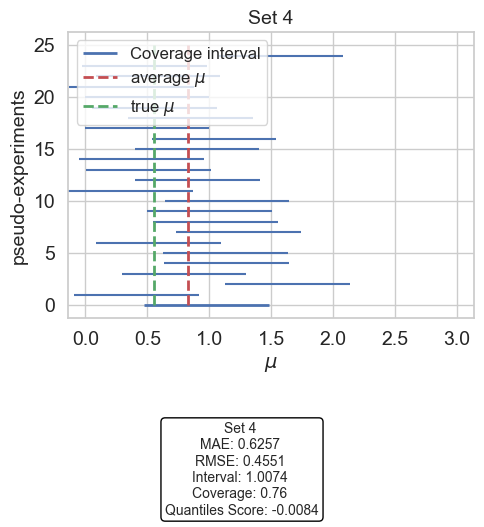

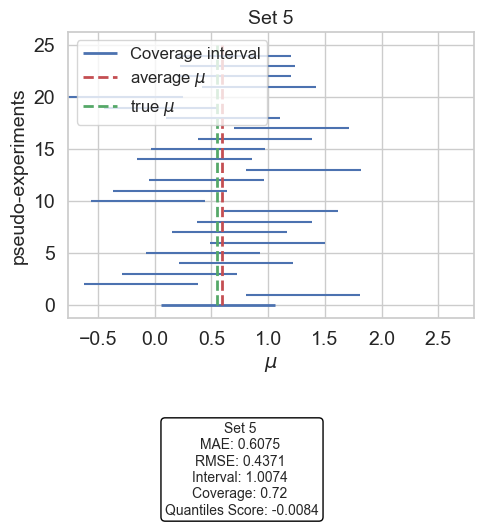

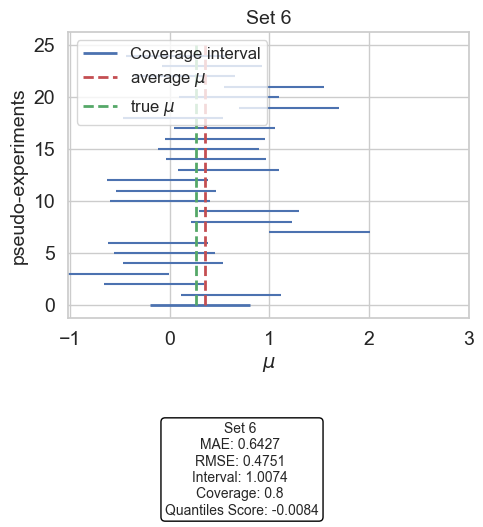

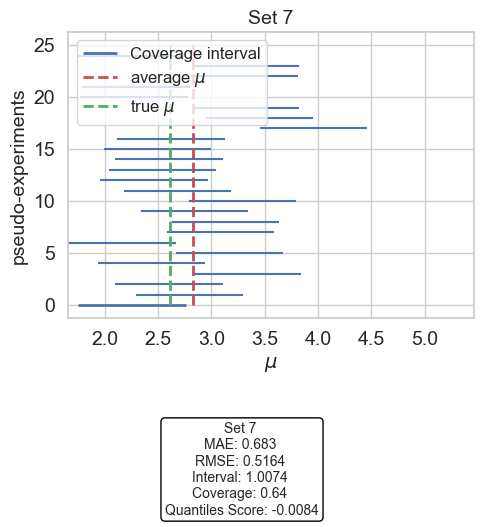

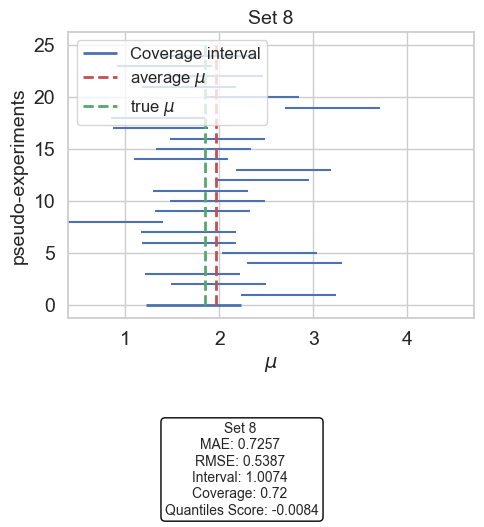

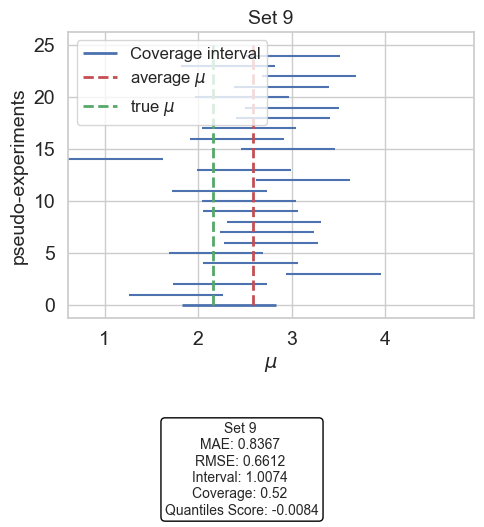

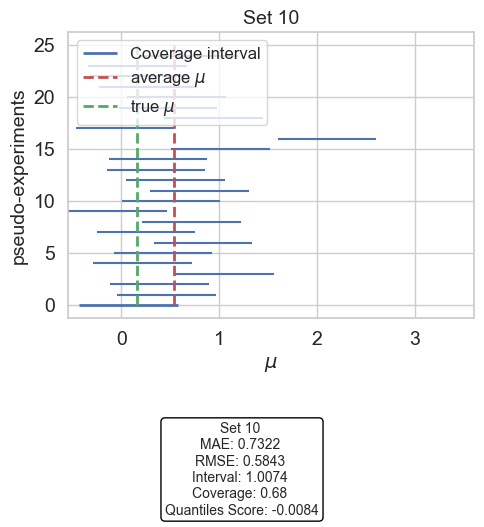

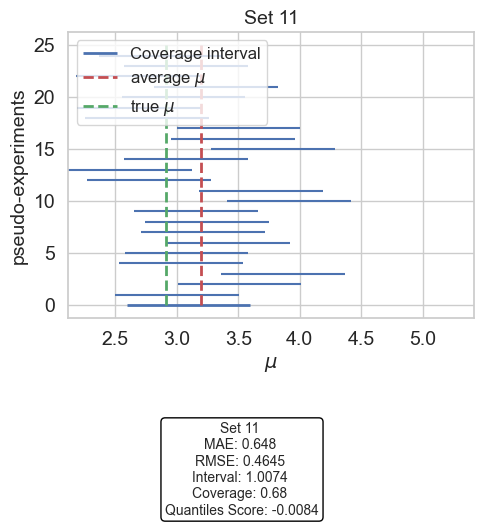

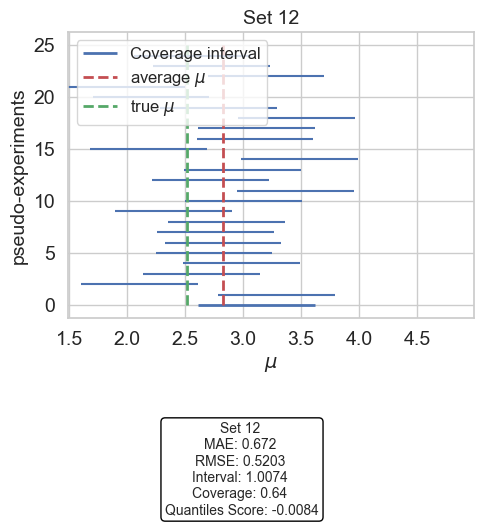

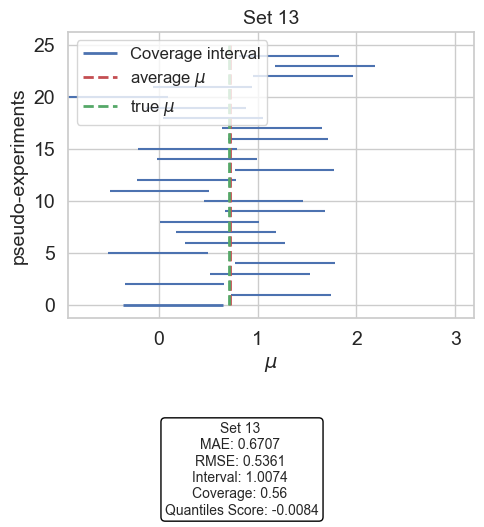

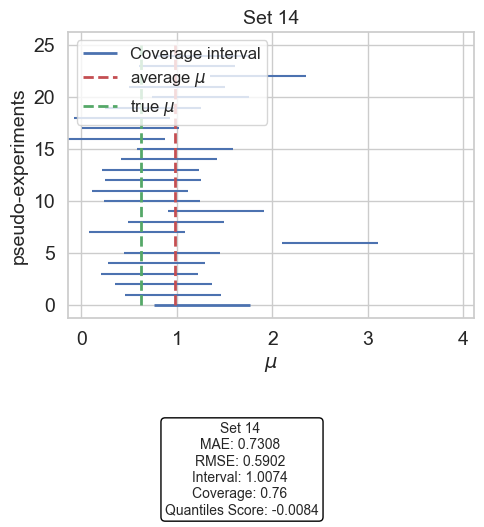

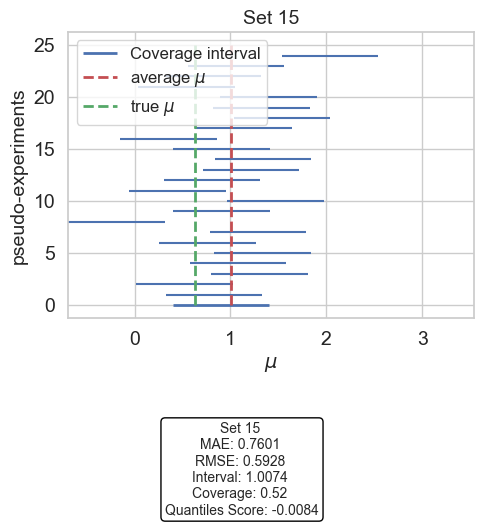

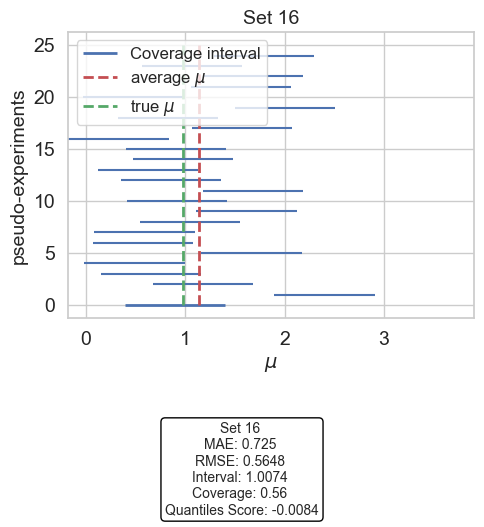

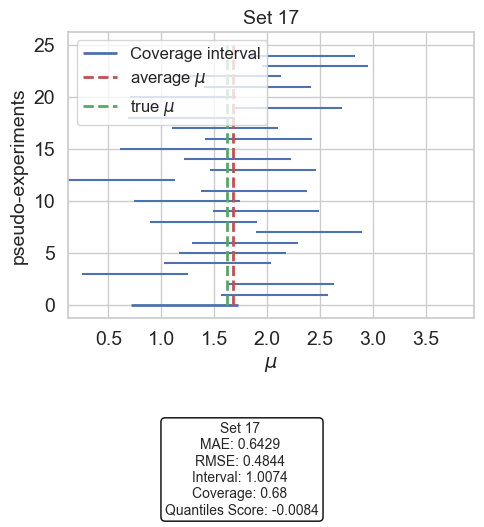

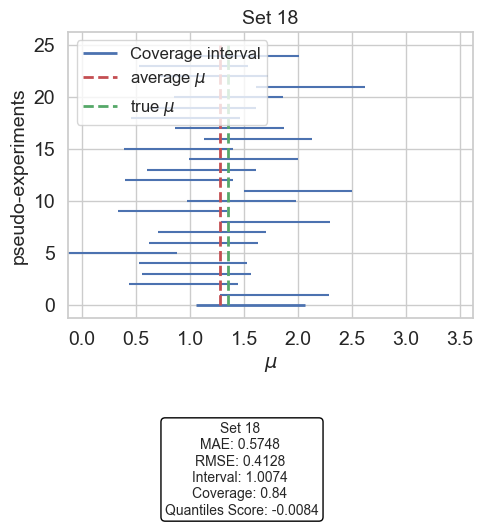

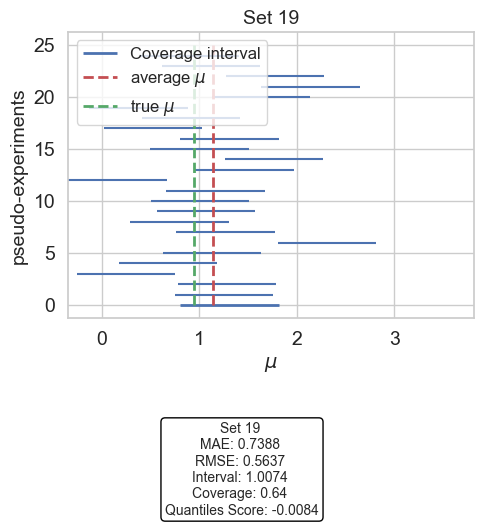

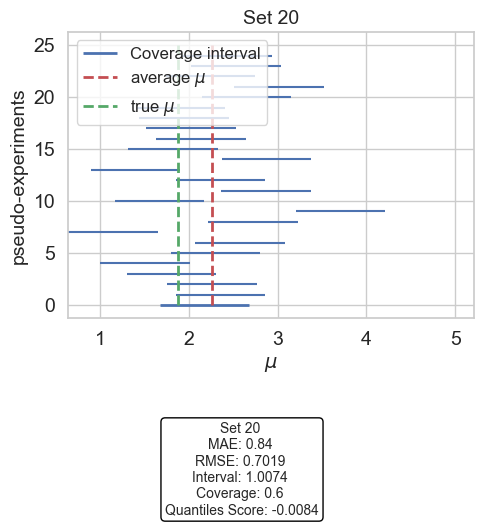

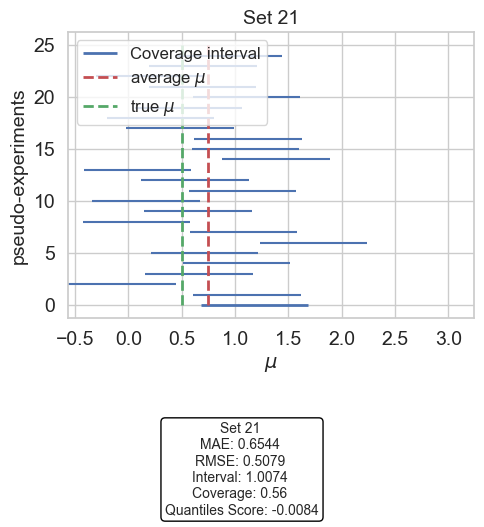

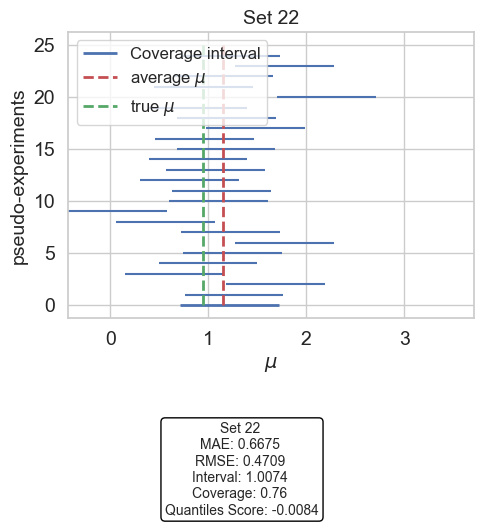

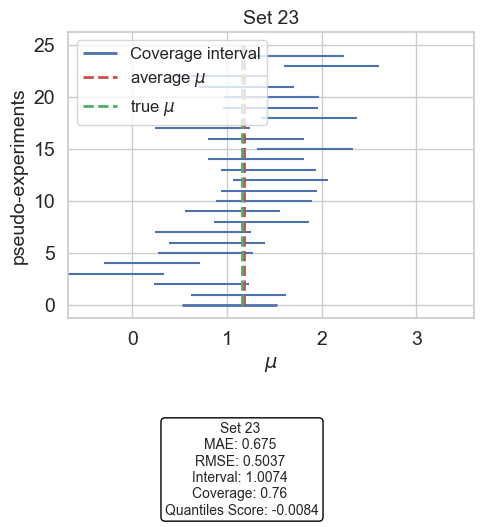

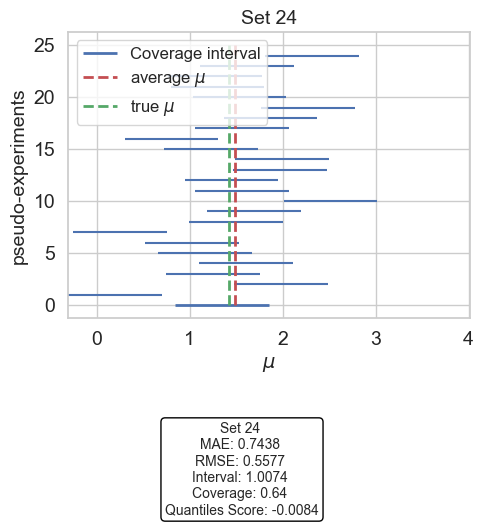

In [28]:
# Compute Score
score.compute_scores(test_settings)

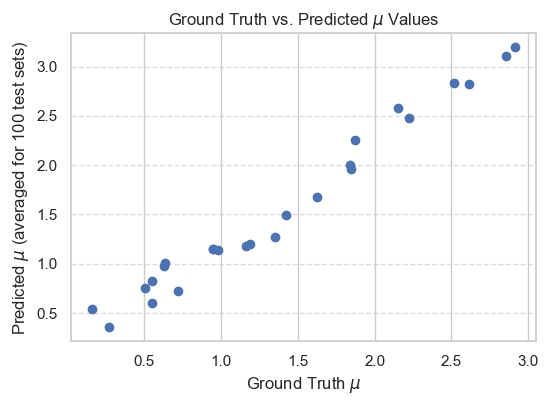

In [29]:
from HiggsML.visualization import visualize_scatter

# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(
    ingestion_result_dict=ingestion.results_dict,
    ground_truth_mus=test_settings["ground_truth_mus"],
)

In [30]:
!python -m HiggsML.score --prediction $output_dir --output $output_dir

############################################
### Scoring Program
############################################

d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission\test_settings.json
d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission
[✔]

----------------------------------------------
[✔] Scoring Program executed successfully!
----------------------------------------------




2025-05-29 12:11:59,777 - HiggsML.score        - INFO     - Reading ingestion duration from d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission\ingestion_duration.json
2025-05-29 12:11:59,777 - HiggsML.score        - WARNING  - File d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission\ingestion_duration.json not found. Setting ingestion duration to 0.
2025-05-29 12:11:59,782 - HiggsML.score        - INFO     - Read ingestion results from d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission
2025-05-29 12:11:59,782 - HiggsML.score        - INFO     - Computing scores
c:\Users\Ragansu_User\AppData\Local\Programs\Python\Python313\Lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\Ragansu_User\AppData\Local\P